# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

# Background:

The following report is commissioned on behalf of the Head of Data Science at Tasty Bytes. 

Context:
Tasty Bytes have been fully operational since 2021 as a monthly subscription meal plan service that focuses on healthy and balanced meals for every budget. 

Tasty Bytes have 2 product tiers in their monthly subscription service:
1. Basic: Customized healthy meal plans based on your budget, and family size 
2. Premium: Basic plan with the addition of ingredients delivered to your door

The product team has noticed that certain content featured on the home page can significantly increase website traffic by as much as 40%.

Increased traffic leads to increased subscriptions, an important KPI for the business. 


The team would like to understand the underlying traits of popular recipes, and be able to "predict which recipes will be popular 80% of the time and minimize the chance of showing unpopular recipes". 

Thus the model selection criterion places greater emphasis on identifying the positive class (high traffic recipes) correctly .  
As a result, the primary metric of evaluation is a model that produces:

- a precision score of at least 0.8 ( True positive rate = 0.8, where 80% of recipes that are classified as high traffic recipes are correctly classified as high traffic) 
- as a secondary metric we will also look to maximize the accuracy score

For comparison for their ease of interpretation and ability to implement, we have chosen the following classification models: 

1) logistic regression, 
2) SGD classifier (linear), 
3) Random forest classifier (non linear) 
4) Gradient boosting classifier 


An example recipe provided by the team shows that recipes can include a selection of the following information:
- recipe name
- servings
- time to make
- category
- cost per serving 
- nutritional information table: calories, carbohydrates(g), sugar(g) and protein(g) per serving
- ingredients
- method

The product team have provided the following data for our analysis, consisting of 8 fields which can be summarized as:
- recipe id,
- nutritional information: (calories, carbohydrates(g), sugar(g) and protein(g))
- category
- servings
- high_traffic.

The preliminary raw data gives us 6 raw features to work with (recipe id is unique key) and 1 target feature (high_traffic).

Although we are given information about what the recipes might look like on the website, it is not explicitly stated what information is captured on the home page recipe preview snippet, which would likely also have a significant bearing on traffic volume. 

We will conduct the analysis with the tacit understanding that the data provided is the information available on the recipe pages themselves, and not what can be seen on the home page recipe preview. 

This assumption implies that the popularity of the recipe is tied to the innate content of the recipe and is independent of the initial recipe presentation (home page previews).   




In [2]:
# Start coding here...
#import modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import  accuracy_score, confusion_matrix, make_scorer, precision_score, recall_score
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, OneHotEncoder 
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline    
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from itertools import product
import pingouin as ping
import statsmodels.api as sm 




In [3]:
#read in csv
df = pd.read_csv('recipe_site_traffic_2212.csv', na_values=np.nan)
#display first 5 rows
print(df.head())

#check for column data types and number of null values
print(df.info())

#proportion of missing values by columns
print(round(df.isna().sum()/df.shape[0],4)*100)

#actual missing values by column 
print(df.isna().sum())

   recipe  calories  carbohydrate  ...   category  servings high_traffic
0       1       NaN           NaN  ...       Pork         6         High
1       2     35.48         38.56  ...     Potato         4         High
2       3    914.28         42.68  ...  Breakfast         1          NaN
3       4     97.03         30.56  ...  Beverages         4         High
4       5     27.05          1.85  ...  Beverages         4          NaN

[5 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes

In [4]:
#data validation functions 

def check_prop(df, col):
    """returns normalized proportion of categories in a categorical variable"""
    col_clean = str(col).replace("_", ' ').title()
    title = 'Class % in Data' 
    return df[col].value_counts(dropna =False, normalize =True).mul(100).round(4).rename( title).sort_values(ascending =False)


def check_count(df, col):
    """returns count of categories in a categorical variable"""
    col_clean = str(col).replace("_", ' ').title()
    title = 'Count of Data by ' + str(col_clean)
    return df[col].value_counts(dropna =False).rename( title).sort_values(ascending =False)


def validate_col(df, col):
    """returns col: data type, numer of missing values and %, and number of unique values"""
    col_clean = str(col).replace("_", ' ').title()
    unique_values_num = df[col].nunique()
    uv = str(col_clean) + " has {unique_values_num:} unique values"
    print(uv.format(unique_values_num = unique_values_num))
    missing_values = df[col].isna().sum()
    mv = str(col_clean) + " has {missing_values} missing values"
    print(mv.format(missing_values = missing_values))
    missing_prop = missing_values/df.shape[0]
    mp = str(col_clean) + " missing values make up {missing_prop:.2f} % of data set"
    print(mp.format(missing_prop = missing_prop))
    val_type = df[col].dtype
    vt = str(col_clean) + " is {val_type} data type"
    print(vt.format(val_type = val_type))

    
    
def prop_graph(df, col):
    """"returns a graph of proportion by category of a categorical variable"""
    col_clean = str(col).replace("_", ' ').title()
    title = '% Proportion of Data by ' + str(col_clean) + " Class"
    check_prop(df,col).plot(kind = 'bar')
    plt.title(title)
    plt.xlabel(col_clean)
    plt.ylabel('% Proportion of Data')
    plt.show()

In [5]:
#validate recipe column: Numeric, unique identifier of recipie
validate_col(df, 'recipe')
#as per data dictionary recipe is numeric: Int64 and has 947 unique values
#no cleaning needed.

Recipe has 947 unique values
Recipe has 0 missing values
Recipe missing values make up 0.00 % of data set
Recipe is int64 data type


In [6]:
#validate servings column: Numeric, number of servings for the recipie
validate_col(df, 'servings')
#check proportion of servings proportion 
check_count(df, 'servings')

Servings has 6 unique values
Servings has 0 missing values
Servings missing values make up 0.00 % of data set
Servings is object data type


4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: Count of Data by Servings, dtype: int64

In [7]:
#servings data is not numeric as should be. 
#categories containing as snack will combined with their respective int values using below dict

servings_dict = {'6':'6',
                 '4':'4',
                 '1': '1',
                 '2': '2',
                 '4 as a snack': '4',
                 '6 as a snack': '4'}


In [8]:
#clean servings
df.servings = df.servings.map(servings_dict).astype(int)


In [9]:
#validate servings after cleaning 
validate_col(df, 'servings')
check_count(df, 'servings')



Servings has 4 unique values
Servings has 0 missing values
Servings missing values make up 0.00 % of data set
Servings is int64 data type


4    392
6    197
2    183
1    175
Name: Count of Data by Servings, dtype: int64

In [10]:
#validate high_traffic
validate_col(df, 'high_traffic')
check_count(df, 'high_traffic')


High Traffic has 1 unique values
High Traffic has 373 missing values
High Traffic missing values make up 0.39 % of data set
High Traffic is object data type


High    574
NaN     373
Name: Count of Data by High Traffic, dtype: int64

In [11]:
#check high traffic proportion by class
check_prop(df, 'high_traffic')

High    60.6125
NaN     39.3875
Name: Class % in Data, dtype: float64

In [12]:
#as per data dictionary high_traffic is a character data type with 1 unique value. 
#high_traffic has 373 missing values which we will assume means Low traffic volume
#fill nans with Low for cleanliness during data exploratory analyssis
df.high_traffic = df.high_traffic.fillna('Low')



In [13]:
#check high_traffic after cleaning
validate_col(df, 'high_traffic')
check_prop(df, 'high_traffic')



High Traffic has 2 unique values
High Traffic has 0 missing values
High Traffic missing values make up 0.00 % of data set
High Traffic is object data type


High    60.6125
Low     39.3875
Name: Class % in Data, dtype: float64

In [14]:
#validate category
validate_col(df, 'category')
check_count(df, 'category')



Category has 11 unique values
Category has 0 missing values
Category missing values make up 0.00 % of data set
Category is object data type


Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: Count of Data by Category, dtype: int64

In [15]:
#as per data dictionary category is a character data type 
#the raw data set has 11 unique value instead of the listed 10. 
#There are no missing values
#Chicken Breast should be combined with Chicken
print(df.category.unique())

#create dicionary mapping to map 'Chicken Breast' to 'Chicken' 
cateogry_dict = {'Pork':'Pork', 
                 'Potato':'Potato', 
                 'Breakfast': 'Breakfast',
                 'Beverages': 'Beverages', 
                 'One Dish Meal': 'One Dish Meal',
                 'Chicken Breast': 'Chicken', 
                 'Lunch/Snacks': 'Lunch/Snacks', 
                 'Chicken':'Chicken',
                 'Vegetable': 'Vegetable',
                 'Meat': 'Meat', 
                 'Dessert': 'Dessert'}


['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']


In [16]:
#map to category col to correct mapping and change to category type
df.category= df.category.map(cateogry_dict).astype('category')


In [17]:
#validate category after cleaning
validate_col(df, 'category')
check_prop(df, 'category')

#chicken (18.16%) is the common category almost double the size of all other types which are differ less than 4 percent each (7-11%)

Category has 10 unique values
Category has 0 missing values
Category missing values make up 0.00 % of data set
Category is category data type


Chicken          18.1626
Breakfast        11.1932
Beverages         9.7149
Lunch/Snacks      9.3981
Potato            9.2925
Pork              8.8701
Dessert           8.7645
Vegetable         8.7645
Meat              8.3421
One Dish Meal     7.4974
Name: Class % in Data, dtype: float64

In [18]:
#validate calories, carbohydrate, sugar and protein columns: Numeric, number of calories
#nutrional info at first glance appears as a set as same number missing through out
nums = ['calories','protein','sugar','carbohydrate']
df[nums].describe()

calories     protein       sugar  carbohydrate
count   895.000000  895.000000  895.000000    895.000000
mean    435.939196   24.149296    9.046547     35.069676
std     453.020997   36.369739   14.679176     43.949032
min       0.140000    0.000000    0.010000      0.030000
25%     110.430000    3.195000    1.690000      8.375000
50%     288.550000   10.800000    4.550000     21.480000
75%     597.650000   30.200000    9.800000     44.965000
max    3633.160000  363.360000  148.750000    530.420000

<AxesSubplot: >

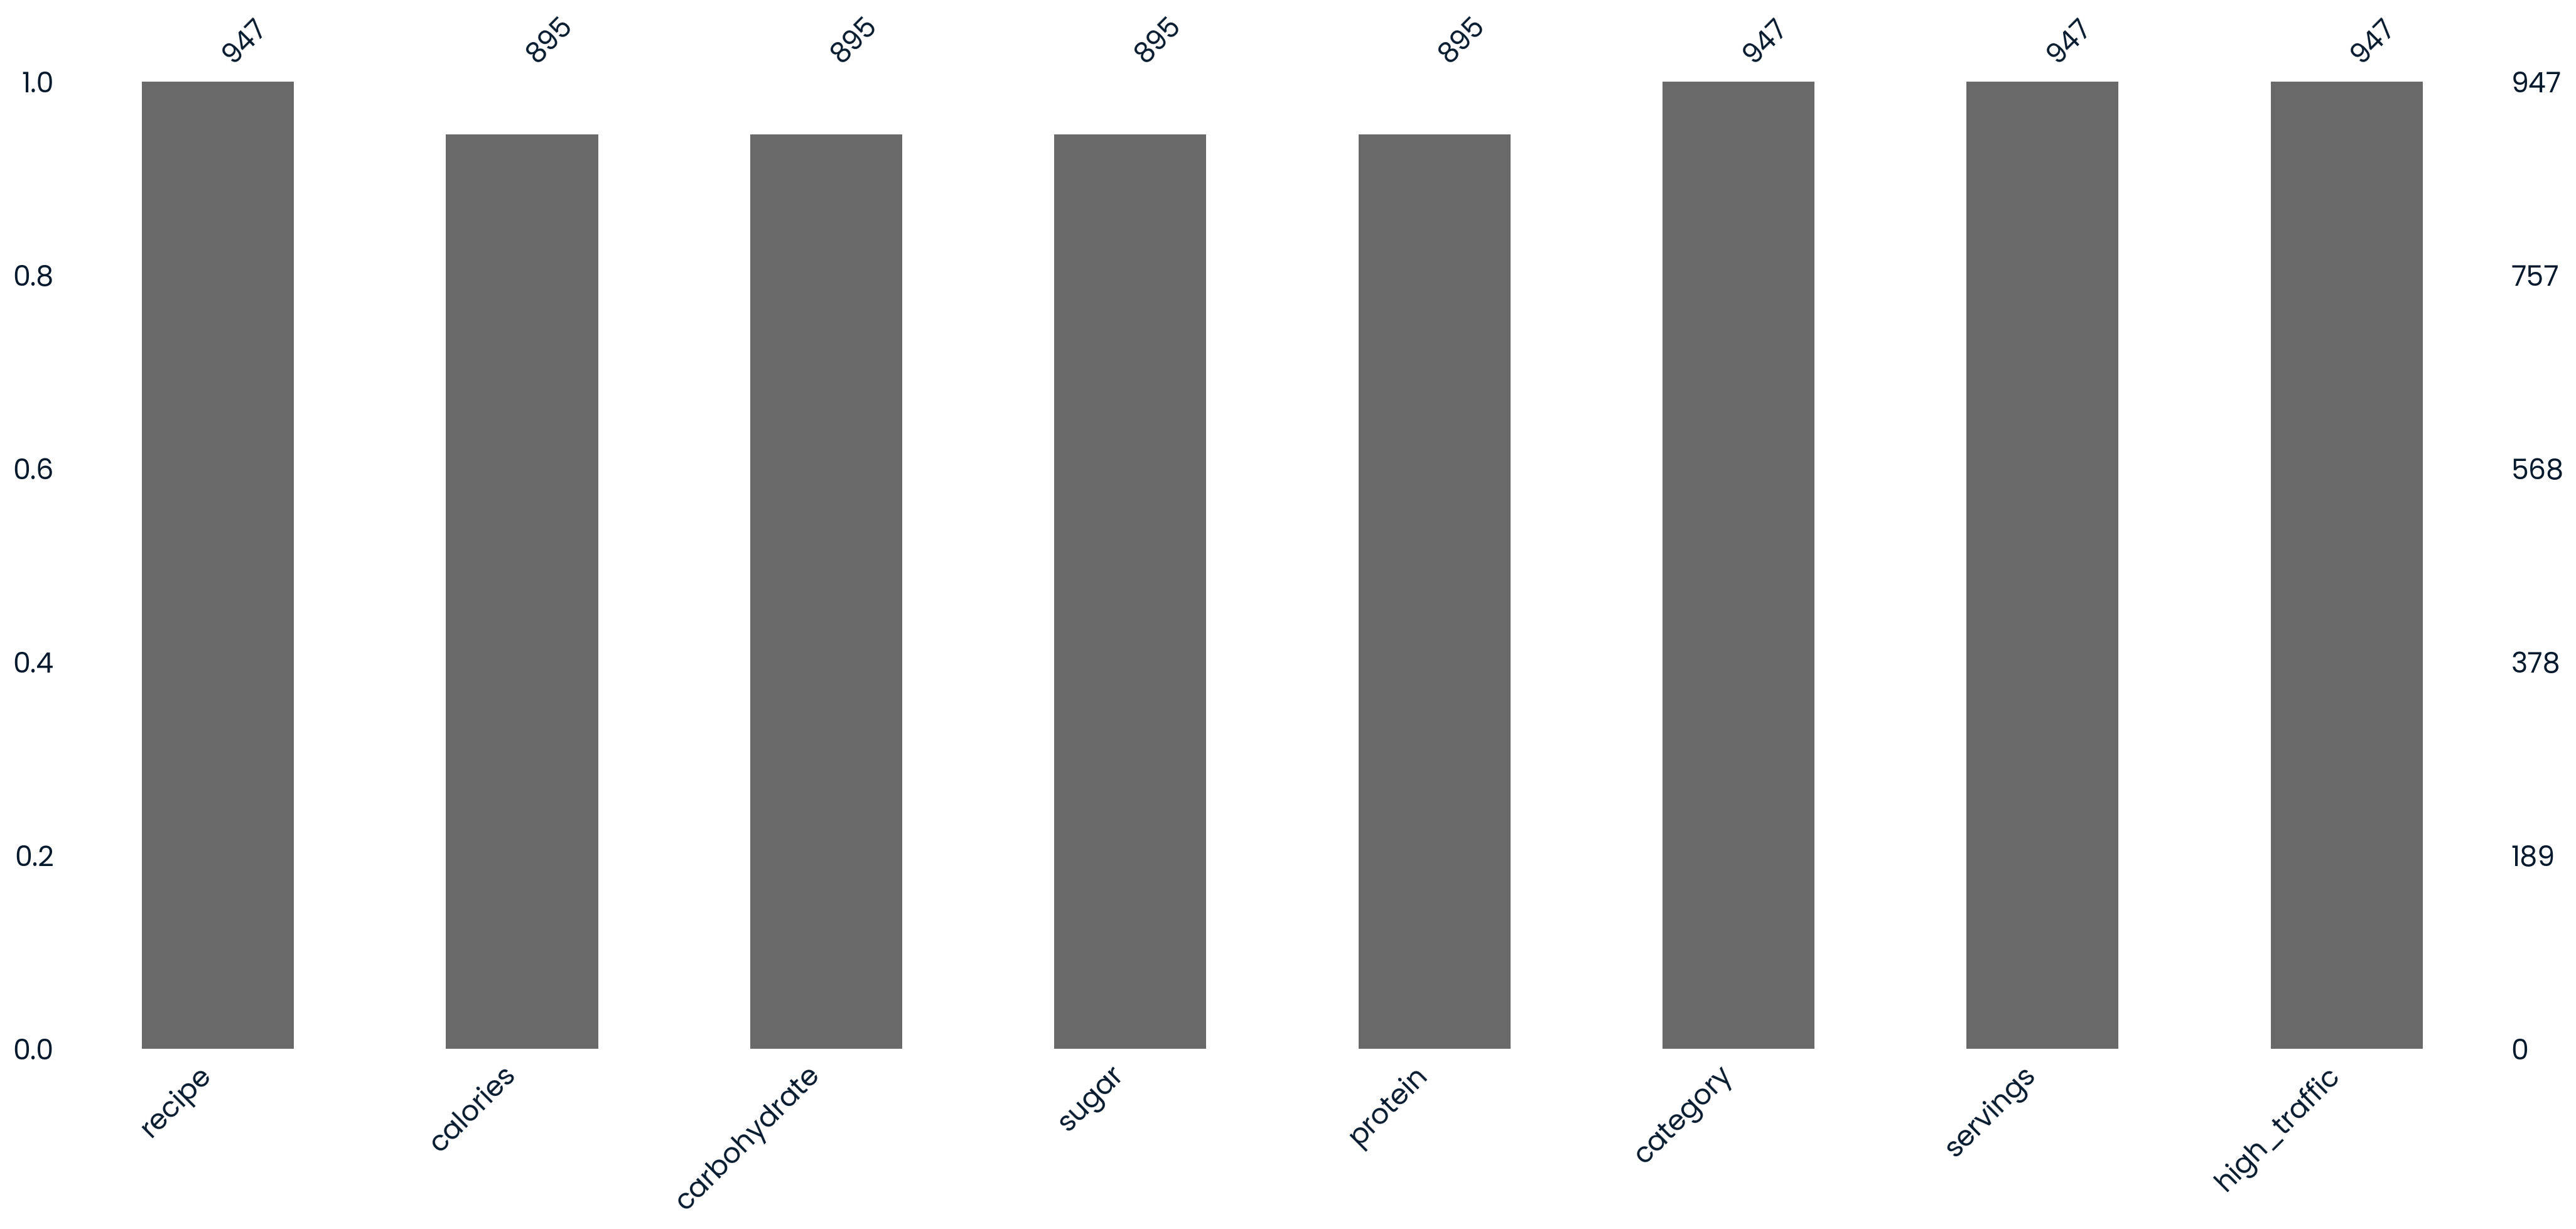

In [19]:
#view missing data
msno.bar(df)

<AxesSubplot: >

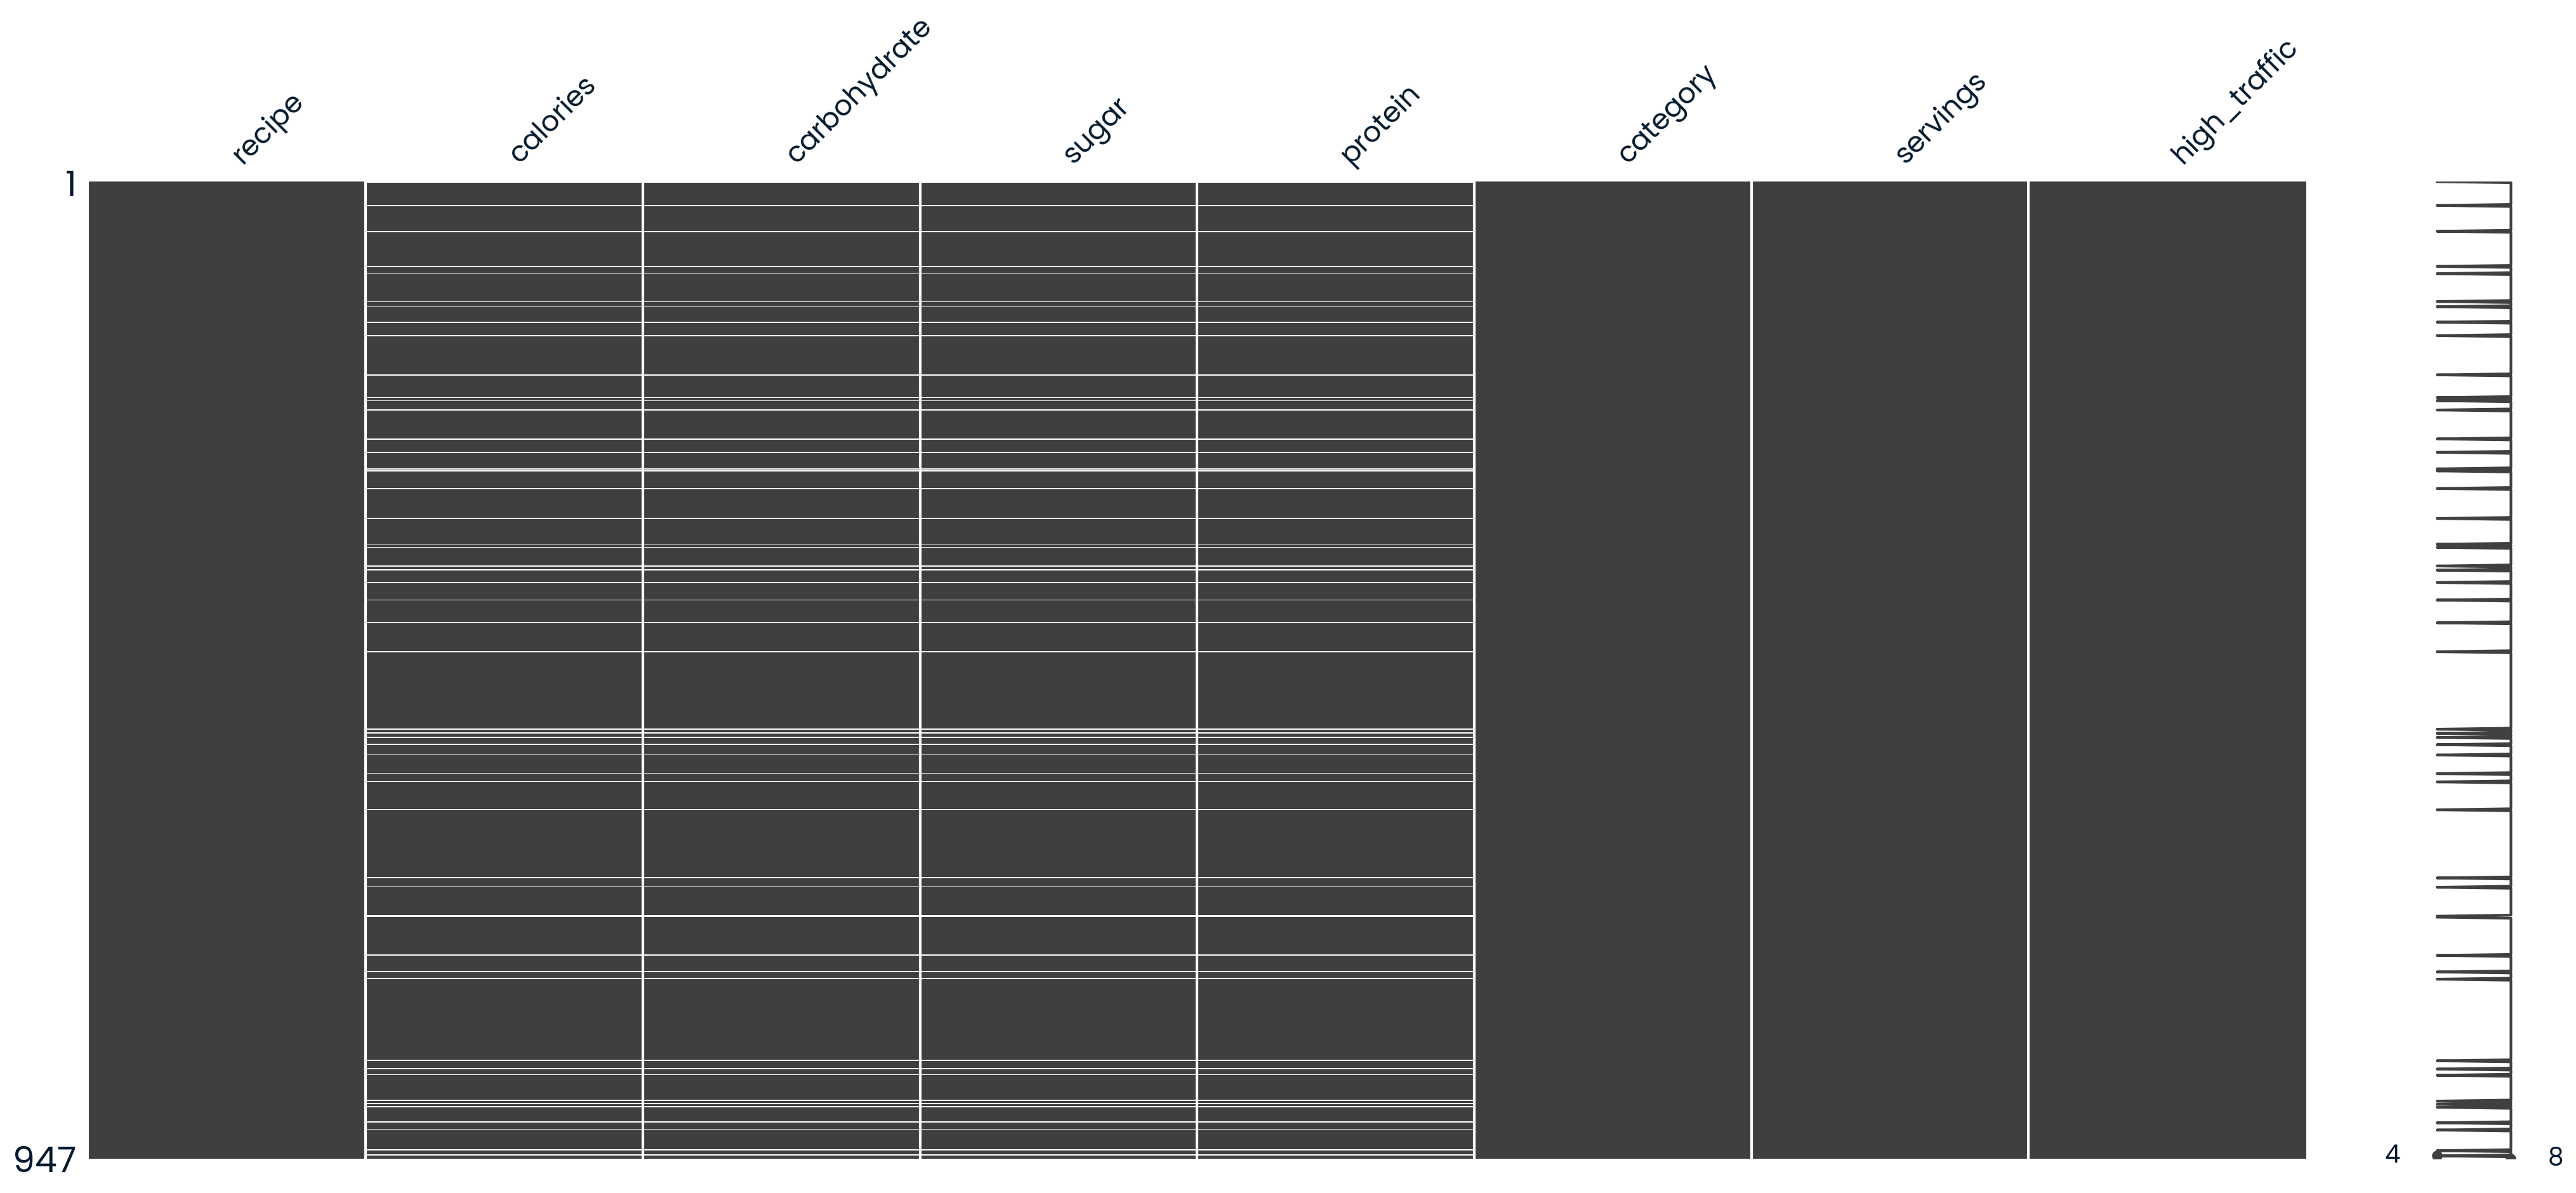

In [20]:
#view missing data for rows across cols

msno.matrix(df)
#appears that nutritional infor is a set and is missing in same cols , thus will use calories as substitute check col

In [21]:
def compare_missing(df, remove, check):
    """compares the % difference for the 'check' feature in the data set 
    to before and after the removal of the 'remove feature'
    
    df: (pands dataframe) : the dataframe in question
    remove (str): feild with missing values you want to remove rows from data set
    check (str): the filed you want to check the normalized distribution of categories in before and after removal 
 """
    remove_clean = str(remove).replace("_", ' ').title()
    check_clean = str(check).replace("_", ' ').title()
    #find missing values bool create mask
    mask = df[remove].isna()
    #create normalized view of colum of interest 'check' in df removed of missing values and turn from series to df
    missing = pd.DataFrame(df[~mask][check].value_counts(normalize = True, dropna=False).mul(100).round(4))
    #create normalized view of colum of interest 'check' in orginal df and turn from series to df
    full = pd.DataFrame(df[check].value_counts(normalize = True, dropna=False).mul(100).round(4))
    #merge dataframes on index 
    compare = full.merge(missing, how= 'left', left_index = True, right_index =True, suffixes = ['_full', '_missing'])
    #create %diff
    compare['diff'] = compare.iloc[:,0] - compare.iloc[:,1]
    #return difference by largest difference
    compare.sort_values('diff', ascending =False)
    compare.columns = ["Class % of " + check_clean + " in " + i for i in ["Original "+ str(remove_clean) , 'No nulls '+ str(remove_clean), 'Diff']]
    return compare

In [22]:
def plot_compare_missing(df, remove, check):
    
    """for given featues returns graphic comparision
    
    df: (pands dataframe) : the dataframe in question
    remove (str): feild with missing values you want to remove rows from data set
    check (str): the filed you want to check the normalized distribution of categories in before and after removal """
    
    plt.clf()
    remove_clean = str(remove).replace("_", ' ').title()
    check_clean = str(check).replace("_", ' ').title()   
    title = "Compare Missing " + str(remove_clean) + " Values Impact on Total " + str(check_clean) + " Distribution"
    
    cols = df.columns
    df.drop(cols[-1], axis = 1).mul(100).round(4).plot(kind = 'bar', color = ['green', 'blue'], label =["Original", 'No nulls'])
    plt.xticks(rotation = 90)
    plt.ylabel('% Proportion Data')
    plt.xlabel(check_clean)
    plt.legend(fontsize ='x-small')
    plt.title(title)
    plt.show()

In [23]:
def final_compare_missing(df, remove, check):
    """ 
    make graphc of compare_missing table
    
    df: (pands dataframe) : the dataframe in question
    remove (str): feild with missing values you want to remove rows from data set
    check (str): the filed you want to check the normalized distribution of categories in before and after removal"""
    
    table = compare_missing(df, remove, check)
    return plot_compare_missing(table, remove, check)

In [24]:
#see what the percentage difference of the class for high traffic is after removing null calorie rows 
compare_missing(df, 'calories', 'high_traffic')

Class % of High Traffic in Original Calories  ...  Class % of High Traffic in Diff
High                                       60.6125  ...                            0.836
Low                                        39.3875  ...                           -0.836

[2 rows x 3 columns]

<Figure size 640x480 with 0 Axes>

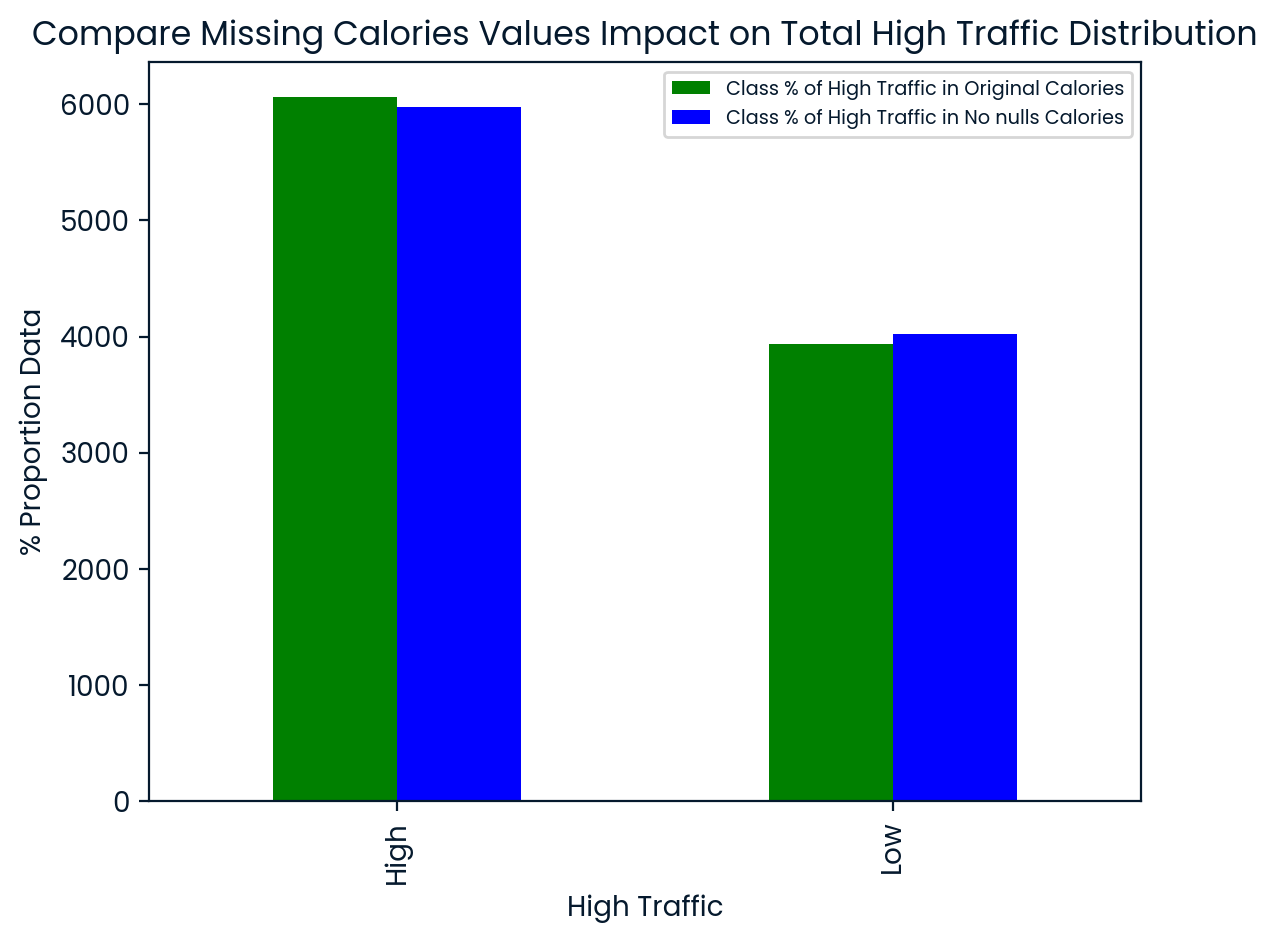

In [25]:
#see effect of removing calories on high traffic
final_compare_missing(df, 'calories', 'high_traffic')
        

In [26]:
#see what the percentage difference of the class for category is after removing null calorie rows 
compare_missing(df, 'calories', 'category')

Class % of Category in Original Calories  ...  Class % of Category in Diff
Chicken                                         18.1626  ...                      -0.0497
Breakfast                                       11.1932  ...                      -0.6504
Beverages                                        9.7149  ...                      -0.5644
Lunch/Snacks                                     9.3981  ...                       0.2361
Potato                                           9.2925  ...                       0.0188
Pork                                             8.8701  ...                       0.7137
Dessert                                          8.7645  ...                       0.1611
Vegetable                                        8.7645  ...                       0.0494
Meat                                             8.3421  ...                       0.0739
One Dish Meal                                    7.4974  ...                       0.0114

[10 rows x 3 columns]

<Figure size 640x480 with 0 Axes>

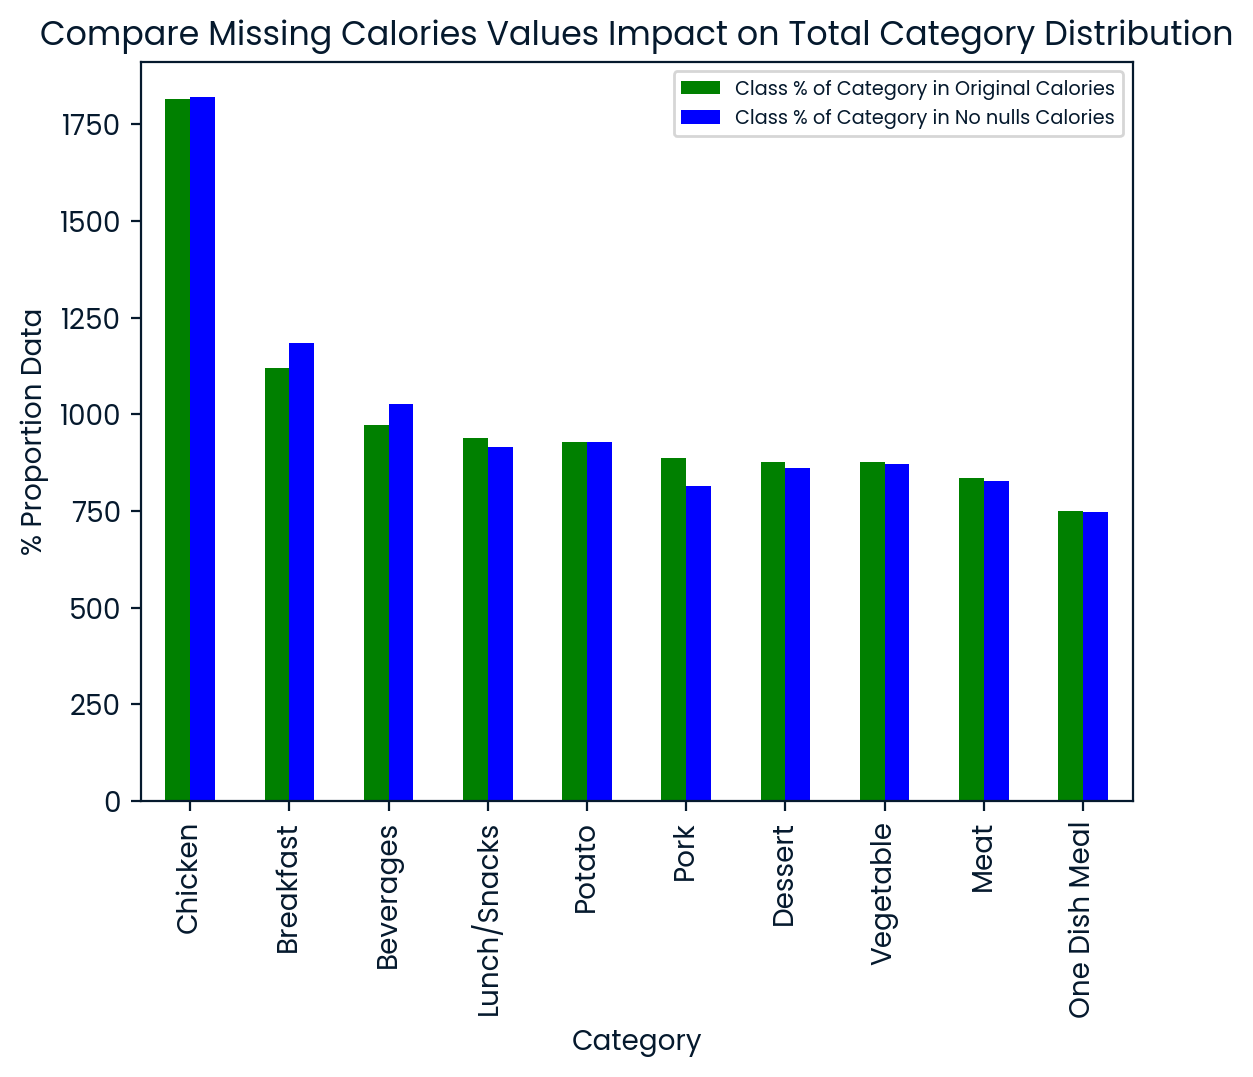

In [27]:
#see what the percentage difference of the class for category is after removing null calorie rows 
final_compare_missing(df, 'calories', 'category')

In [28]:
#see what the percentage difference of the class for servings is after removing null calorie rows 
compare_missing(df, 'calories', 'servings')

Class % of Servings in Original Calories  ...  Class % of Servings in Diff
4                                   41.3939  ...                       0.2766
6                                   20.8025  ...                       0.2438
2                                   19.3242  ...                      -0.1171
1                                   18.4794  ...                      -0.4033

[4 rows x 3 columns]

<Figure size 640x480 with 0 Axes>

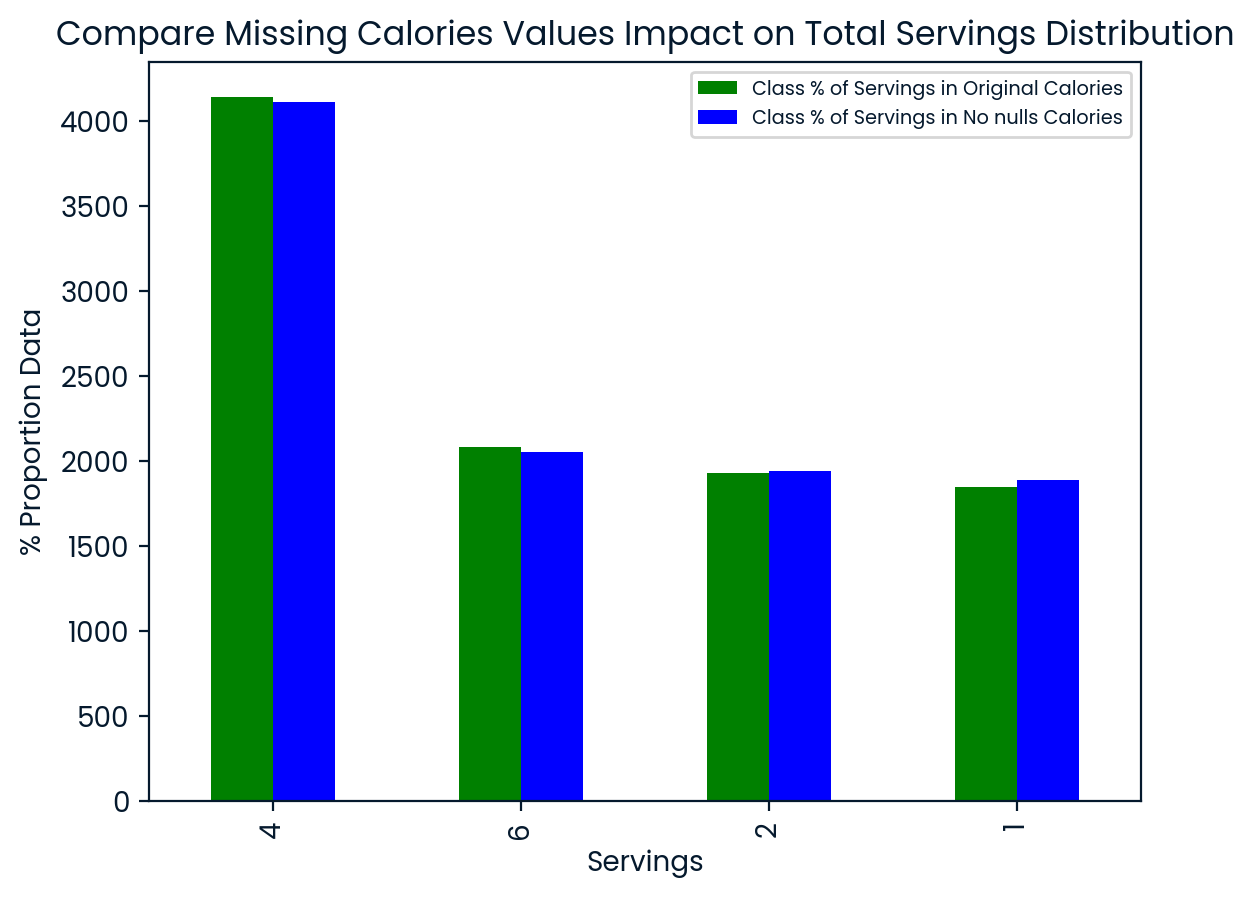

In [29]:
#see what the percentage difference of the class for servings is after removing null calorie rows 
final_compare_missing(df, 'calories', 'servings')

In [30]:
#use calories to check all the nutritional data validate
validate_col(df, 'calories')


Calories has 891 unique values
Calories has 52 missing values
Calories missing values make up 0.05 % of data set
Calories is float64 data type


In [31]:
#deleting the missing values in nutrional info doesn't really change the balance of classes in our target variable
#however it does impact the feild category 
#addtionally it would intersting to see if not having nutrtional infor deters people
#thus we will keep the missing values and replace them with zero 

#fill missing values with zero
df[['calories', 'carbohydrate', 'sugar', 'protein']] = df[['calories', 'carbohydrate', 'sugar', 'protein']].fillna(0)


In [32]:
#use calories to check all the nutritional data validate after cleansing, that there are no missing values and is numeric
validate_col(df, 'calories')

#the scale of the features differ will need to standardise
df[['calories', 'carbohydrate', 'sugar', 'protein']].describe()


Calories has 892 unique values
Calories has 0 missing values
Calories missing values make up 0.00 % of data set
Calories is float64 data type


calories  carbohydrate       sugar     protein
count   947.000000    947.000000  947.000000  947.000000
mean    412.001668     33.143992    8.549799   22.823252
std     451.463971     43.465360   14.418229   35.781906
min       0.000000      0.000000    0.000000    0.000000
25%      88.215000      6.770000    1.450000    2.290000
50%     264.130000     19.440000    4.140000    9.640000
75%     576.225000     42.590000    9.285000   28.530000
max    3633.160000    530.420000  148.750000  363.360000

# **Data Validation:**

## The recipe data set contains 946 rows and 8 columns. Below is a summary of the data validation findings against the provided data dictionary.
                    
### recipe       
- The recipe column contained 946 unique values, as described. No cleaning was done.


### calories, carbohydrates, protein and sugar:
- The nutritional columns: calories, carbohydrates, protein and sugar each had a total of 52 missing values out of a possible 946. 
- The remaining 895 values across all 4 columns were numeric continuous fields (float) as per the data dictionary 
- Furthermore these columns appear as a set in the data, such that if one of the columns is missing in a row, then all 4 columns will be missing. 
- This is congruent with the example recipe given in the brief which is displayed as a nutritional information table.        
- Missing nutritional values were filled in with zero
- The missing data only accounts for ~5% of the total data set
- Deletion of the data does not significantly shift the class balance of the target variable, or category and servings.
- However we have chosen to keep the data with the missing values because it would be interesting to understand if featuring vs not featuring nutritional information would impact user interest. 
- There were no negative values, though variances in calories differ significantly from the other 3 macronutrients. 


### category:
- The column category originally contained 11 unique values.
- All categories matched except "Chicken Breast" which was cleaned to be "Chicken" to match the 10 categories outlined in the data dictionary. 
- The final column was changed to a category data type to match the description in the data dictionary.

### servings:
- The column servings was originally a string data type with no missing data.
- The data contained a total of 3 fields with phrases which were: "4 as a snack" and "6 as a snack".
- Since there were only 3 fields, we did not try to retain the snack info, these were cleaned so that the fields with 'as a snack' were removed and adjoined to their respective int serving class (4 and 6) and made into an integer, as per the data dictionary.
- After cleaning there were 4 unique serving sizes with integer data type which are listed as follows: 1,2,4, and 6 

### high_traffic:
- The column high_traffic is our target feature and is a string binary class variable with only 1 value "High" as described by the data dictionary.
- Originally the high_traffic column had 373 missing values accounting for ~40% of the total data.
- We will assume that null values indicate comparatively lower traffic
- There is a small class in balance that favors the positive class (60:40). 
- This is strange considering the definition of the positive class is about having high traffic volume: which infers that it should be an innately less frequently occurring event. 
- Although this makes it easier for the algorithm to identify positive classes in our data set, it suggests that the data set may not be representative of real life context.
- It would be interesting in further iterations of analysis to understand how the threshold of high traffic volume was defined
- The character data type was preserved but empty values were initially replaced with "Low" for cleaner interpretation during exploratory data analysis. 




# Exploratory Analysis

Exploratory data analysis was conducted using various data visualizations to understand the underlying relationships between the features and the target variable (high_traffic).

The exploratory data analysis was also partially informed by research regarding nutritional information and prevailing diet trends [(Abbott,2024).](https://www.nutritionnews.abbott/healthy-living/diet-wellness/a-look-at-2024-nutrition-trends/)  , primarily: 
- low sugar
- low calorie
- high protein
- low carb

As a result of our research and initial exploratory analysis we have decided to create the following features, the detailed rationale for which can be found in their respective sections

### Created fields include:
- cal_size: categorical: 7 discrete caloric value bins calculated from calories to see if users favor a particular calorie portion : later made into boolean one hot encoded categorical variables 
- high_protien_meal: Boolean: meals with at least 40g of protein
- low_sugar: Boolean: Less than 5g sugar (excluding 0) for Beverages and less than 13g (excluding 0) for non beverage categories 
- low_carb: Boolean: Less than 5g carb (excluding 0) for Beverages and less than 40g (excluding 0) for non beverage categories




### Target Variable : Traffic Volume

- The target variable: traffic volume can be found in the data by the column: "high_traffic".
- high_traffic appears as a binary class categorical variable.

- After our initial cleansing we can see that there is minor class imbalance favoring the positive class (high:60%) 
- This is quite peculiar since one would intuitively expect that there would be a lower incidence of recipes that would meet this high threshold.

- Given the limited information provided, it is not clear exactly how high traffic is defined.
- However one could reasonably assume it would be based on a percentile threshold. 
 
- The high proportion of data considered high traffic indicates that the sample data provided might not be representative, since it suggests that recipes are more likely to be considered high traffic than low traffic. 
- In future analysis perhaps we could review the data with a higher threshold set for the target variable: high_traffic. 

- When splitting our data for testing it will be important to maintain this class balance difference by stratifying by the target variable.
- We will need to dummy encode high_traffic in order to perform predictions

- This makes the nature of our modeling problem a supervised learning classification problem. 


In [33]:
#sense check target var using raw data again 
b = pd.read_csv('recipe_site_traffic_2212.csv', na_values=np.nan)
#check class balance
print(b.high_traffic.value_counts(dropna= False, normalize = True))
#print out shape
print(b.shape[0])
#drop the missing nutri cols to see if this impacts the class balance, remains unchanged
b.dropna(subset = ['calories'], inplace =True, axis =0)
print(b.shape[0])
#display first 5 rows
print(b.high_traffic.value_counts(dropna= False, normalize = True))

High    0.606125
NaN     0.393875
Name: high_traffic, dtype: float64
947
895
High    0.597765
NaN     0.402235
Name: high_traffic, dtype: float64


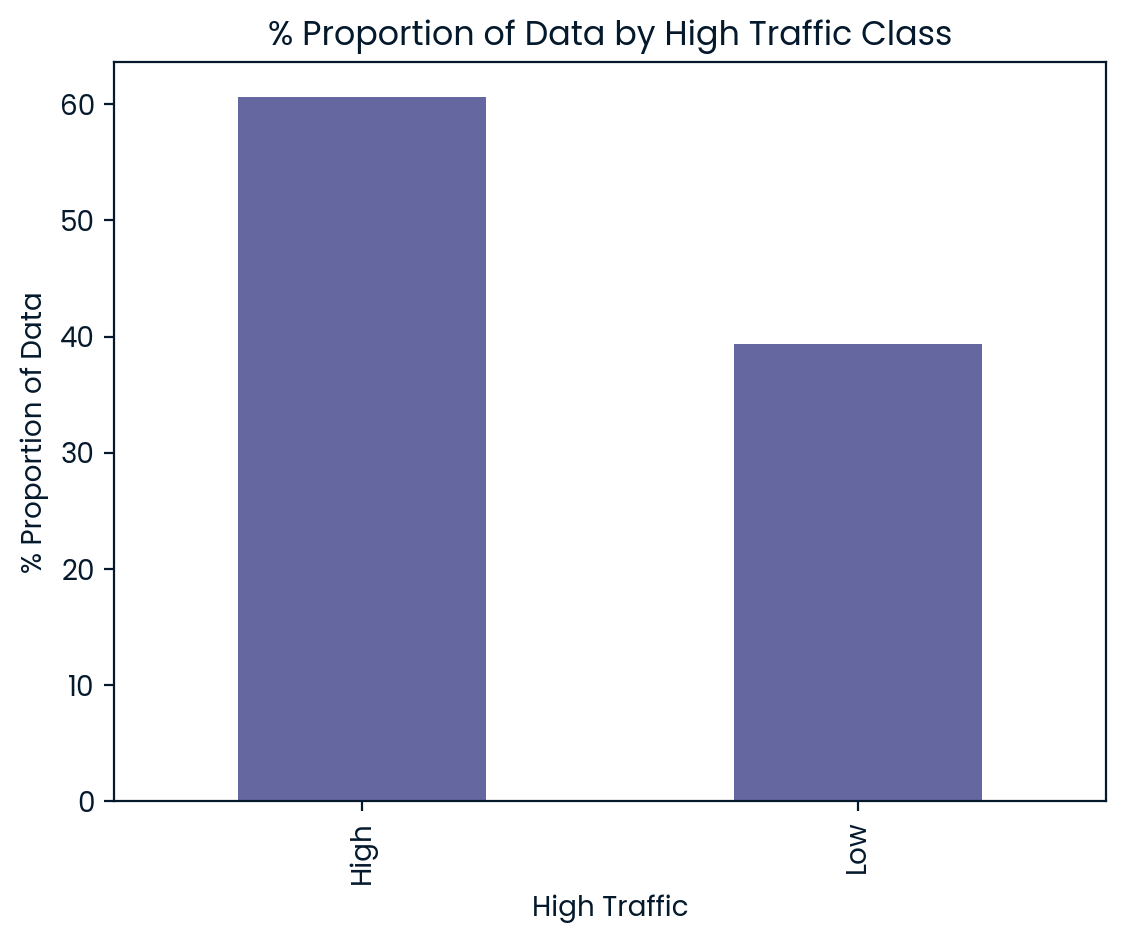

In [34]:
# see difference in classes for high_traffic as graph
prop_graph(df, 'high_traffic')

In [35]:
check_prop(df, 'high_traffic')

High    60.6125
Low     39.3875
Name: Class % in Data, dtype: float64

### Numeric Variables 

- There are 4 numeric features we can use to predict with in the data set which are as follows: calories, protein, sugar, and carbohydrate.

- These have considerably different scales as shown by the table below, which could impact analysis and would require scaling to accommodate for fair comparison across the features in linear and distance models.


In [36]:
numeric = df[['calories','protein','sugar','carbohydrate']]

numeric.describe()

calories     protein       sugar  carbohydrate
count   947.000000  947.000000  947.000000    947.000000
mean    412.001668   22.823252    8.549799     33.143992
std     451.463971   35.781906   14.418229     43.465360
min       0.000000    0.000000    0.000000      0.000000
25%      88.215000    2.290000    1.450000      6.770000
50%     264.130000    9.640000    4.140000     19.440000
75%     576.225000   28.530000    9.285000     42.590000
max    3633.160000  363.360000  148.750000    530.420000

- All 4 variables have a positive skew, suggesting that the majority of the values for each variable lies below the mean. 
- Thus the median would be more a representative measure of center and statistical analysis for differences should be conducted using the Wilcoxon-Mann-Whitney test.


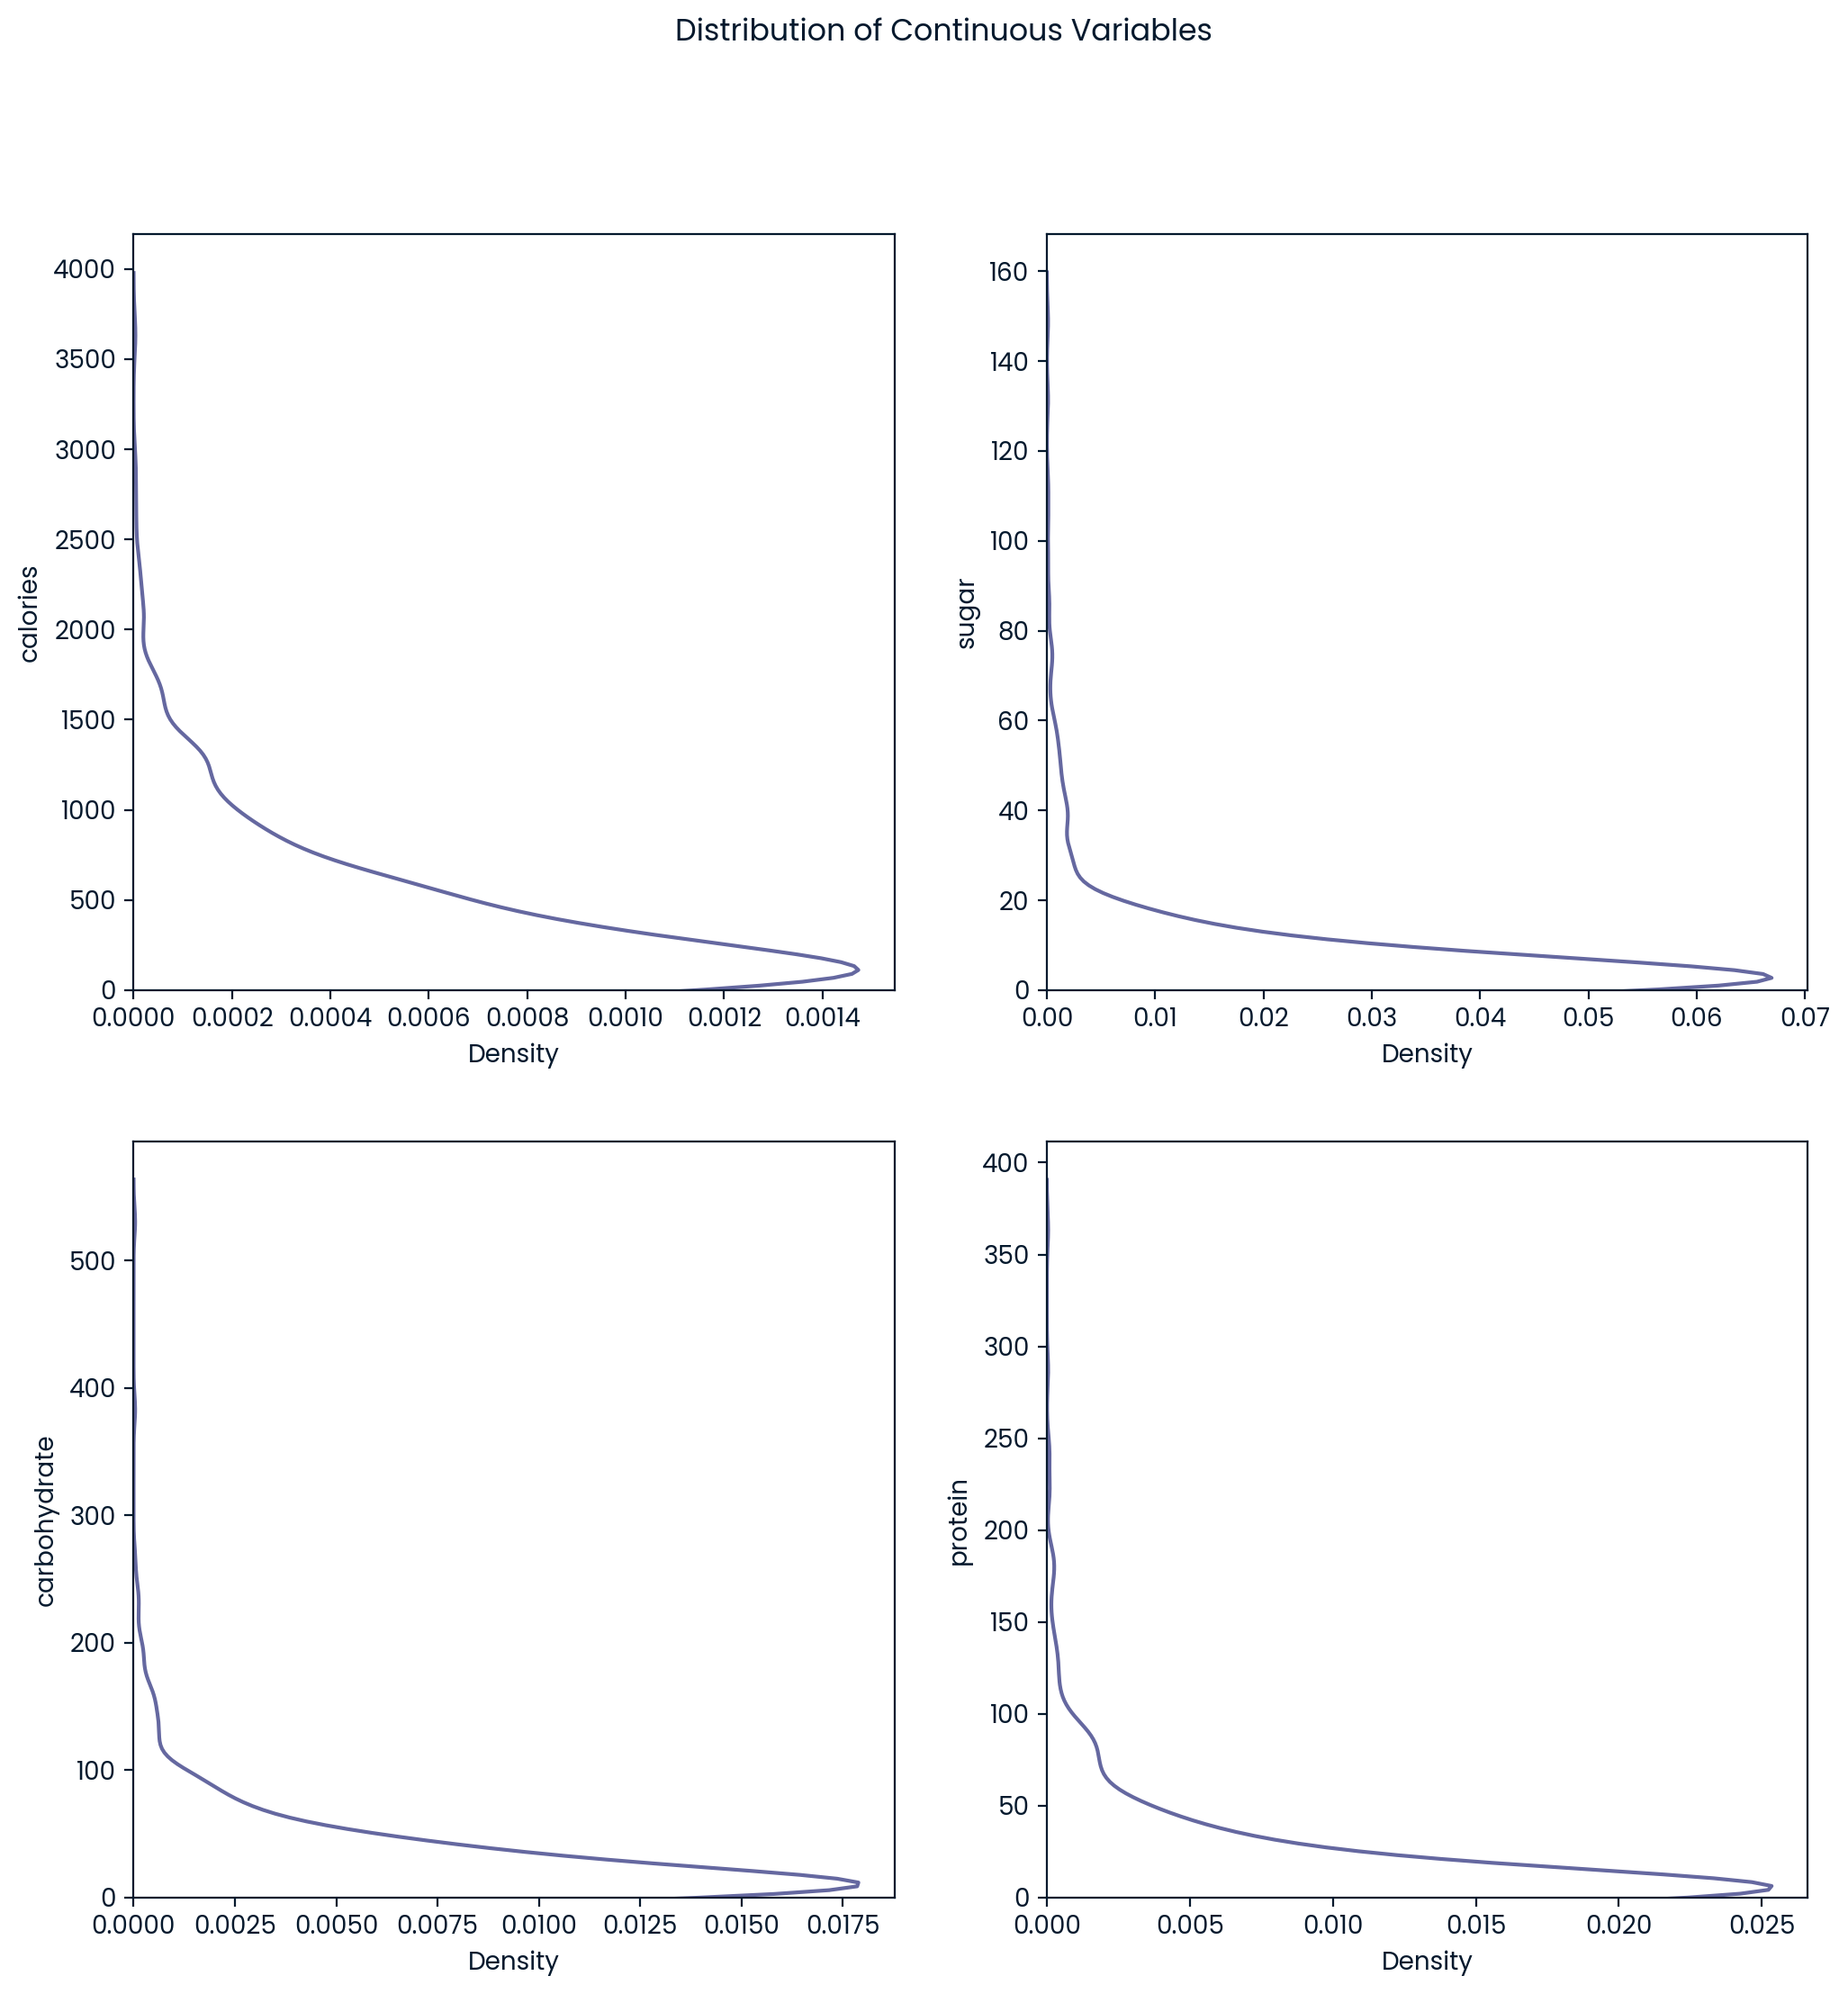

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=False,figsize=(12, 12))
sns.kdeplot(data = df, y = 'calories', ax=axes[0,0] ,common_norm = False ).set(ylim = (0))
sns.kdeplot(data = df, y = 'sugar',  ax=axes[0,1],common_norm = False ).set(ylim = (0))
sns.kdeplot(data = df, y = 'carbohydrate', ax=axes[1,0],common_norm = False ).set(ylim = (0))
sns.kdeplot(data = df, y = 'protein', ax=axes[1,1],common_norm = False ).set(ylim = (0))

plt.suptitle("Distribution of Continuous Variables")
plt.show()

- When visually comparing the standardized traffic volume type (to account for differences in size) for the 4 continuous variables the differences in size appear most significantly different for sugar and carbs.
- However when comparing differences by traffic volume type, all 4 variables show a 95% significant difference in values (Wilcoxon-Mann-Whitney test p-val <.05). 
- In 95% of cases high traffic recipes have on average statistically higher values across all 4 continuous variables than low traffic recipes. 
- The slight class imbalance might explain this result. 


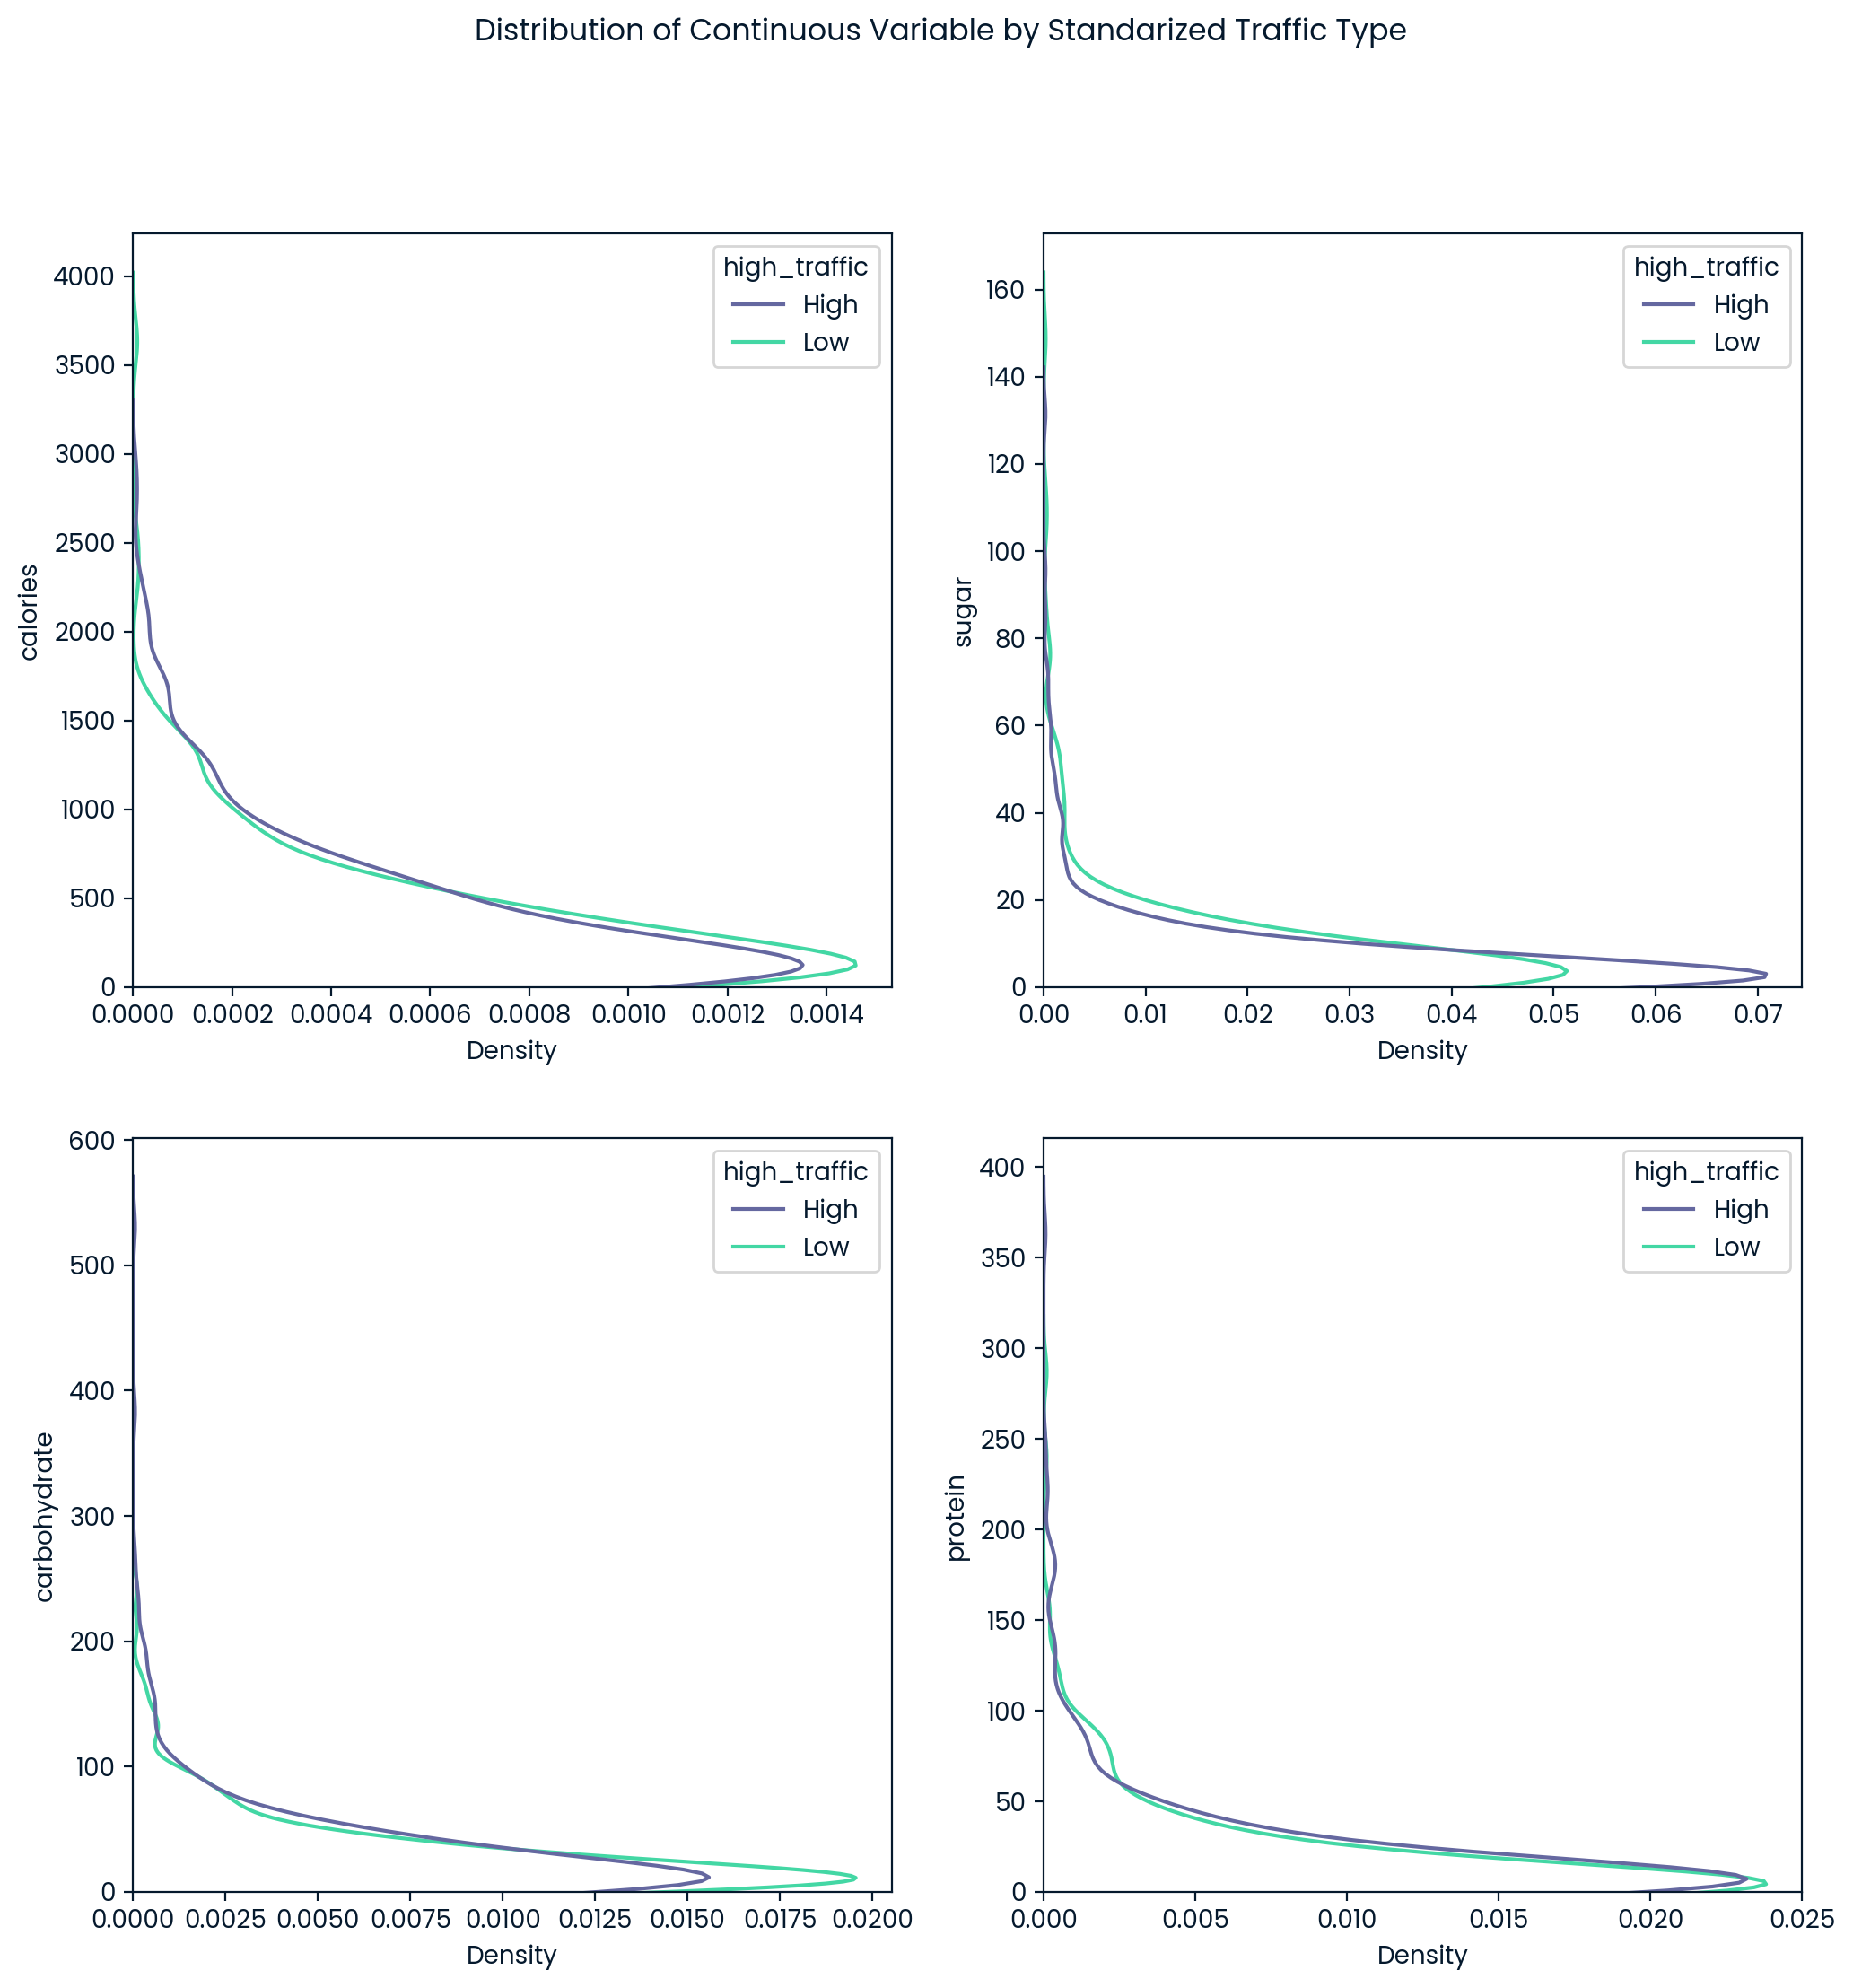

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=False,figsize=(12, 12))
sns.kdeplot(data = df, y = 'calories', hue = 'high_traffic', ax=axes[0,0] ,common_norm = False ).set(ylim = (0))
sns.kdeplot(data = df, y = 'sugar', hue = 'high_traffic', ax=axes[0,1],common_norm = False ).set(ylim = (0))
sns.kdeplot(data = df, y = 'carbohydrate', hue = 'high_traffic', ax=axes[1,0],common_norm = False ).set(ylim = (0))
sns.kdeplot(data = df, y = 'protein', hue = 'high_traffic', ax=axes[1,1],common_norm = False ).set(ylim = (0))

plt.suptitle("Distribution of Continuous Variable by Standarized Traffic Type")
plt.show()

In [39]:
def diff_means_check(df,cat, cont):
    """runs non parametric difference of means test between 2 independent groups at 95% conf """
   
    subset = pd.pivot(df, columns = cat, values = cont).fillna(0)
    a = subset.iloc[:,0].name
    b = subset.iloc[:,1].name
    val = str(cat)
    more = ping.mwu(subset.iloc[:,0], subset.iloc[:,1], alternative = 'greater')['p-val'][0]
    
    less = ping.mwu(subset.iloc[:,0], subset.iloc[:,1], alternative = 'less')['p-val'][0]

    more_result = [print("In 95% of cases " + a + " are likley to have more " + cont +  " than " + b + " (Wilcoxon-Mann-Whitney pval:" + str(more) + ")" ) if more <.05  else print("In 95% of cases " + a + " is unlikley to have more " + cont +  " than " + b + " (Wilcoxon-Mann-Whitney pval:" + str(more) + ")") ]
    less_result = [print("In 95% of cases " + a + " are likley to have less " + cont +  " than " + b + " (Wilcoxon-Mann-Whitney pval:" + str(less) + ")" ) if less  <.05  else print("In 95% of cases " + a + " is unlikley to have less " + cont +  " than " + b + " (Wilcoxon-Mann-Whitney pval:" + str(less) + ")" )]
    

In [40]:
diff_means_check(df,'high_traffic', 'calories')


In 95% of cases High are likley to have more calories than Low (Wilcoxon-Mann-Whitney pval:7.825005666376981e-17)
In 95% of cases High is unlikley to have less calories than Low (Wilcoxon-Mann-Whitney pval:0.9999999999999999)


In [41]:
diff_means_check(df,'high_traffic', 'protein')


In 95% of cases High are likley to have more protein than Low (Wilcoxon-Mann-Whitney pval:9.256545478362492e-19)
In 95% of cases High is unlikley to have less protein than Low (Wilcoxon-Mann-Whitney pval:1.0)


In [42]:
diff_means_check(df,'high_traffic', 'sugar')


In 95% of cases High are likley to have more sugar than Low (Wilcoxon-Mann-Whitney pval:5.0468516066464865e-12)
In 95% of cases High is unlikley to have less sugar than Low (Wilcoxon-Mann-Whitney pval:0.9999999999949564)


In [43]:
diff_means_check(df,'high_traffic', 'carbohydrate')

In 95% of cases High are likley to have more carbohydrate than Low (Wilcoxon-Mann-Whitney pval:1.1339231456914965e-16)
In 95% of cases High is unlikley to have less carbohydrate than Low (Wilcoxon-Mann-Whitney pval:0.9999999999999999)


- The correlation heatmap below shows no significant linear relationship between the variables in their raw state, so there should be no issue with multicollinearity and it would be possible to have all 4 features as part of a linear algorithm. 
- However we know from the literature that macros are also a subset of energy measure just like calories 


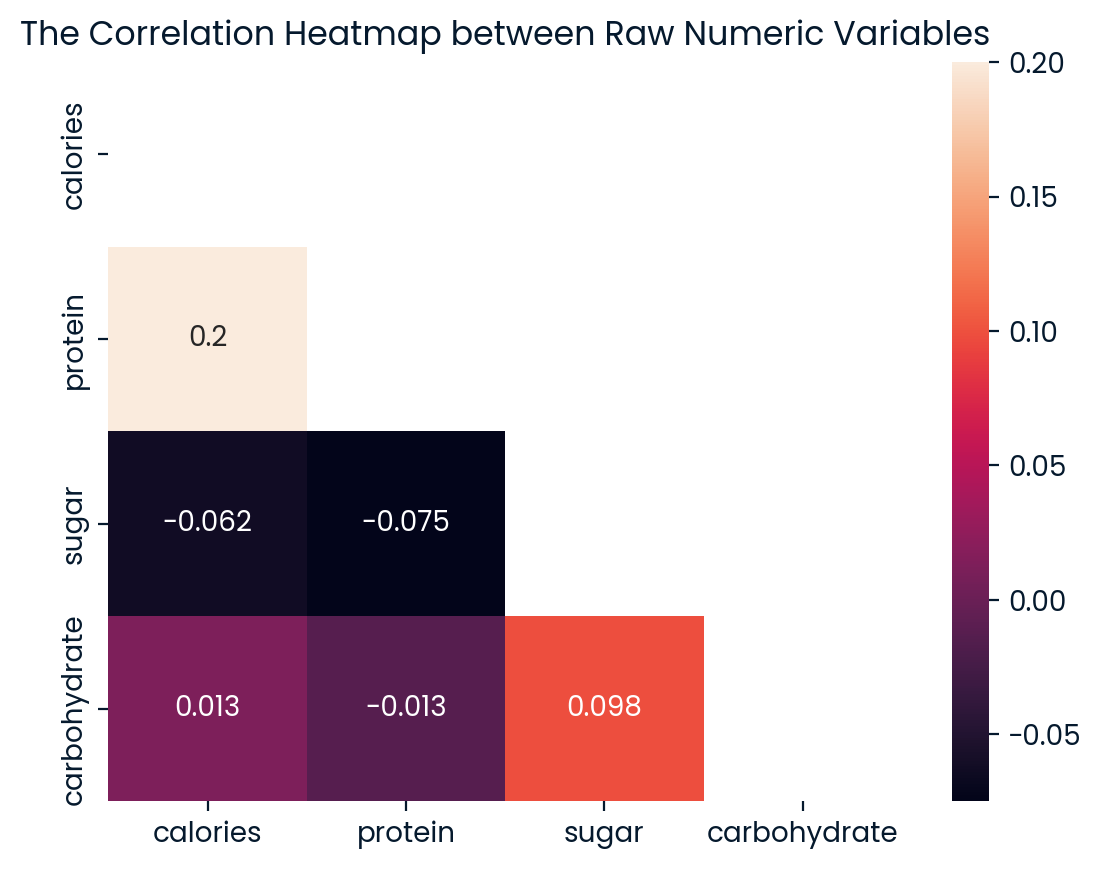

In [44]:
num_corr = numeric.corr()
mask = np.triu(np.ones_like(num_corr, dtype = bool))
sns.heatmap(num_corr, mask = mask,annot=True).set(title='The Correlation Heatmap between Raw Numeric Variables');

In [45]:
#import minmax scaler to scale cont vars to see if this helps highlight the linear reletionship of vars better
minmax = MinMaxScaler()

#transform the numeric cont.data
minimax_num = minmax.fit_transform(numeric ) 

minimax_num_df = pd.DataFrame(minimax_num, columns = ['calories','protein','sugar','carbohydrate'])

minimax_num_df.describe()



calories     protein       sugar  carbohydrate
count  947.000000  947.000000  947.000000    947.000000
mean     0.113400    0.062812    0.057478      0.062486
std      0.124262    0.098475    0.096929      0.081945
min      0.000000    0.000000    0.000000      0.000000
25%      0.024281    0.006302    0.009748      0.012763
50%      0.072700    0.026530    0.027832      0.036650
75%      0.158602    0.078517    0.062420      0.080295
max      1.000000    1.000000    1.000000      1.000000

- Even after standardizing to account for differences in scale the correlation still appears very week so there should be no issue with multicollinearity

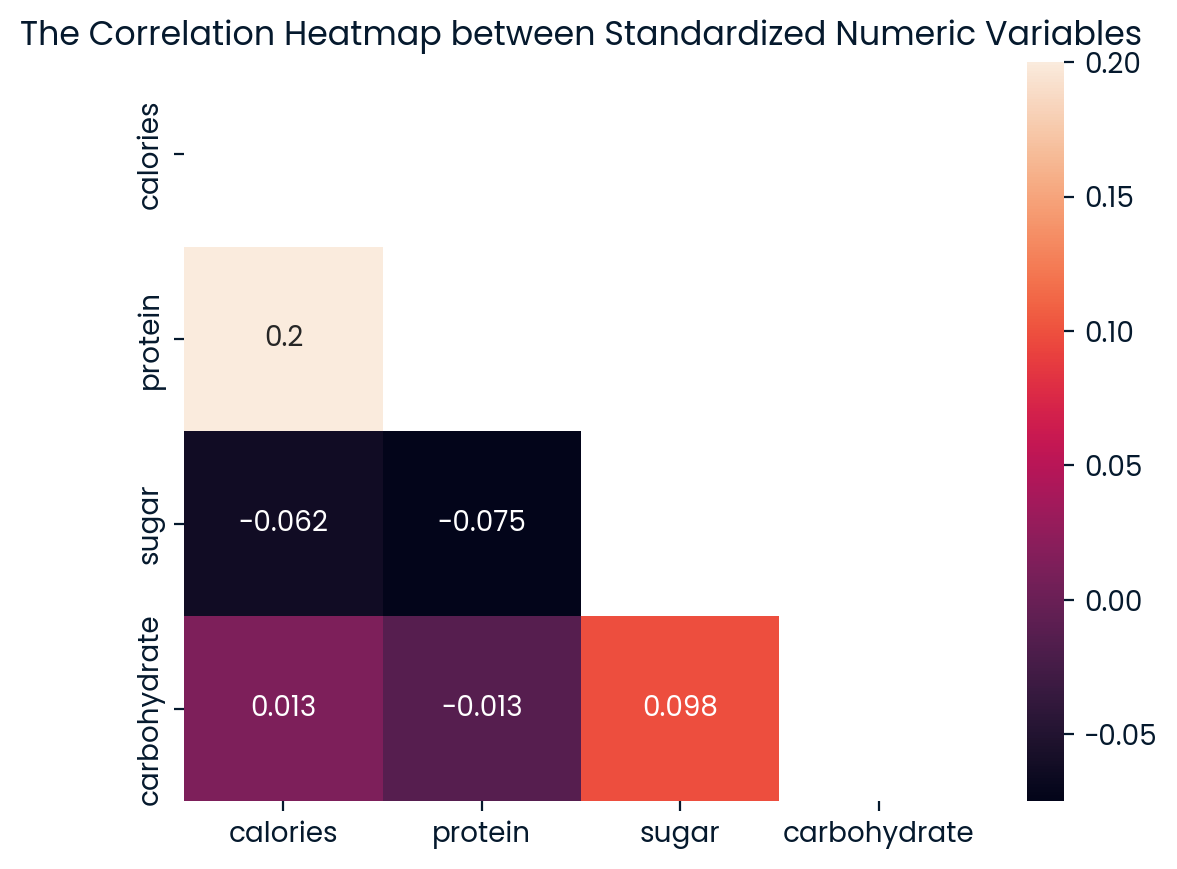

In [46]:
#show heatmap corr
minimax_num_cor =minimax_num_df.corr()
mask = np.triu(np.ones_like(minimax_num_cor, dtype = bool))
sns.heatmap(minimax_num_cor, mask = mask,annot=True).set(title='The Correlation Heatmap between Standardized Numeric Variables');


# Category

- The most common category in our data set is Chicken (18%), which accounts for almost 2x as many recipes in our sample than the other categories.
- The remaining categories appear to be relatively evenly distributed (between 7-11%) with a difference of less than 4% in size. 


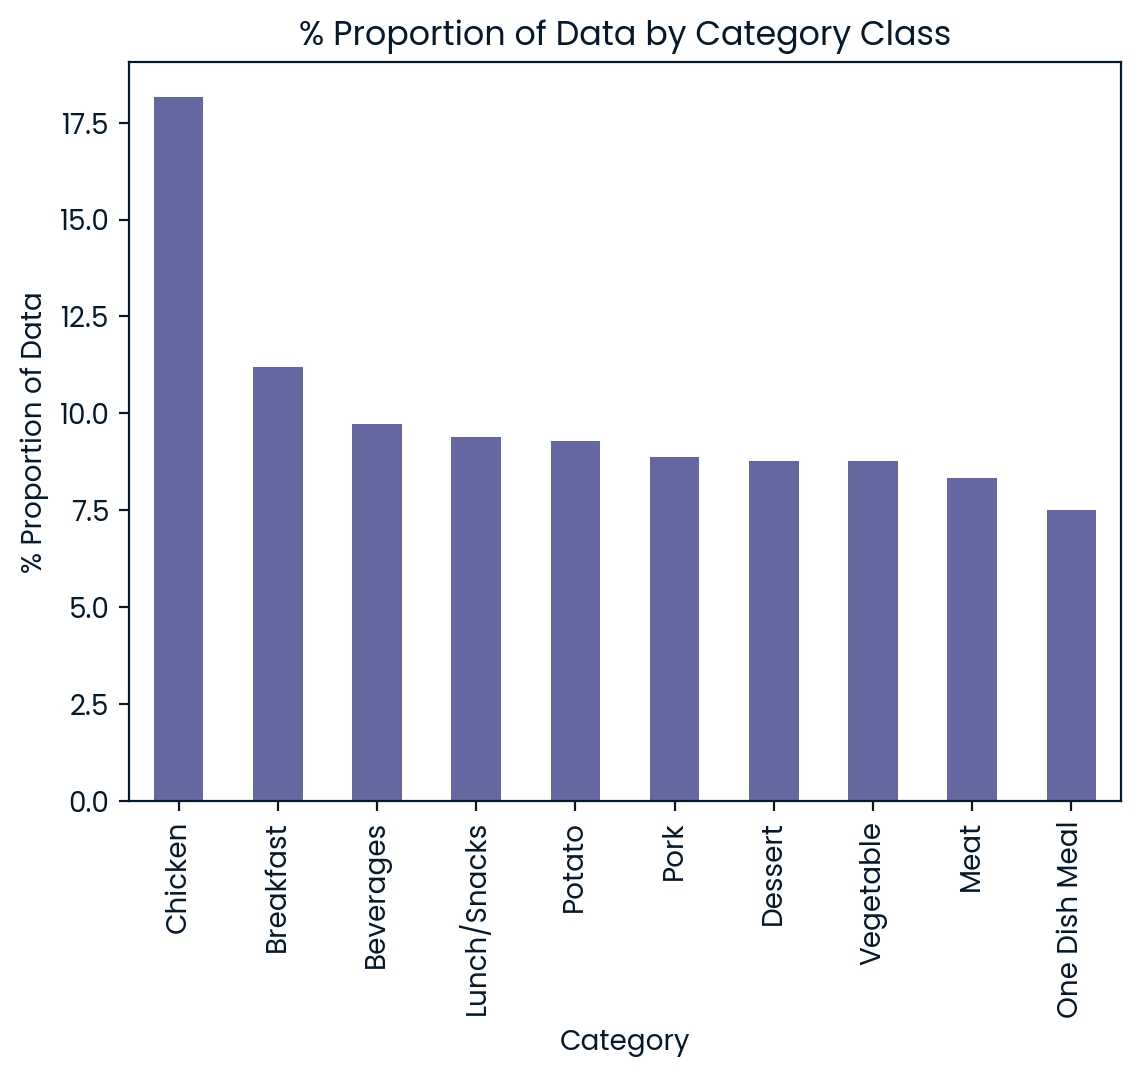

In [47]:
#show cateogry visualisation
prop_graph(df, 'category')



In [48]:
#check category distribution
check_prop(df, 'category')

Chicken          18.1626
Breakfast        11.1932
Beverages         9.7149
Lunch/Snacks      9.3981
Potato            9.2925
Pork              8.8701
Dessert           8.7645
Vegetable         8.7645
Meat              8.3421
One Dish Meal     7.4974
Name: Class % in Data, dtype: float64

In [49]:
# code for cross category comparison with or target variable


def compare_traffic_norm_diff(df, var1):
    """returns normalized comparision of High and Low traffic by selected feature
     df: (pandas dataframe): dataframe with data
     var1 (str): categorical feature you want see the % proportion break down by each traffic class
    
    """
    table = pd.crosstab(df[var1], columns = df.high_traffic,  normalize ='columns').mul(100).round(4).sort_values('High',     ascending = False)
    #rename columns
    table.columns = ['% of '+ i + ' by Class'  for i in table.columns]
    #calc difference between the amount the cateogry contributes to high vs low traffic
    table['% High MINUS % Low Diff'] = table.iloc[:,0] -table.iloc[:,1]

    #get % high traffic makes up category 
    cat_traffic_split = pd.crosstab(df[var1], columns = df.high_traffic,  normalize ='index', margins =True).iloc[:,0].mul(100).round(4).rename('% of High Traffic in Class')
    #merge the table and cat_traffic_split
    table = table.merge(cat_traffic_split, how = 'left', left_index =True, right_index=True).merge(check_prop(df, var1), how = 'left', left_index =True, right_index=True)
    return table

def compare_traffic_norm(df, var1):
    """returns normalized comparision of High and Low traffic by selected feature
     df: (pandas dataframe): dataframe with data
     var1 (str): categorical feature you want see the % proportion break down by each traffic class
    
    """
    table = pd.crosstab(df[var1], columns = df.high_traffic,  normalize ='columns', margins=True).mul(100).round(4).sort_values('High',     ascending = False)
    return table




def traffic_comp_graph(df,var1, diff=True):
    """returns graph of normalized comparision of High and Low traffic by selected feature
     df: (pandas dataframe): dataframe with data
     var1 (str): categorical feature you want see the % proportion break down by each traffic class"""
    
    
    if diff == True :
        var_clean = str(var1).replace("_", ' ').title()
        title = "% Proportion of Traffic Volume Type by " + var_clean 
        compare_traffic_norm_diff(df, var1).iloc[:,:-2].plot(kind ='bar')
        plt.xticks(rotation =90)
        plt.xlabel(var_clean)
        plt.ylabel('% Contribution for Each Traffic Volume Class')
        plt.title(title )
        plt.legend(fontsize = 'x-small')
        plt.show()

    else:
        var_clean = str(var1).replace("_", ' ').title()
        title = "% Proportion of Traffic Volume Type by " + var_clean 
        compare_traffic_norm(df, var1).plot(kind ='bar')
        plt.xticks(rotation =90)
        plt.xlabel(var_clean)
        plt.ylabel('% Contribution')
        plt.title(title )
        plt.legend(fontsize = 'x-small')
        plt.show()
    
    
    
    


- The 3 most common low traffic categories were:
    1. Chicken (26.5%) 
    2. Beverages (23.3%) 
    3. Breakfast (19.57%)  


  <br />
- Preliminary analysis suggests a user preference for vegetarian cuisine, and low interest in beverages and breakfast since all categories excluding chicken are relatively evenly represented with less than 4% difference (11.19-7.49) in size.


- It is interesting to note that high traffic accounts for over 60% of recipes across all categories except for: Beverages, Breakfast, and Chicken (the categories with highest proportion of low traffic).
- The class balance favoring the positive class might explain this result
- A chi-squared independence test found a significant p-val (p value: 3.41e-63) suggesting a high probability that category value is likely to affect traffic volume. 


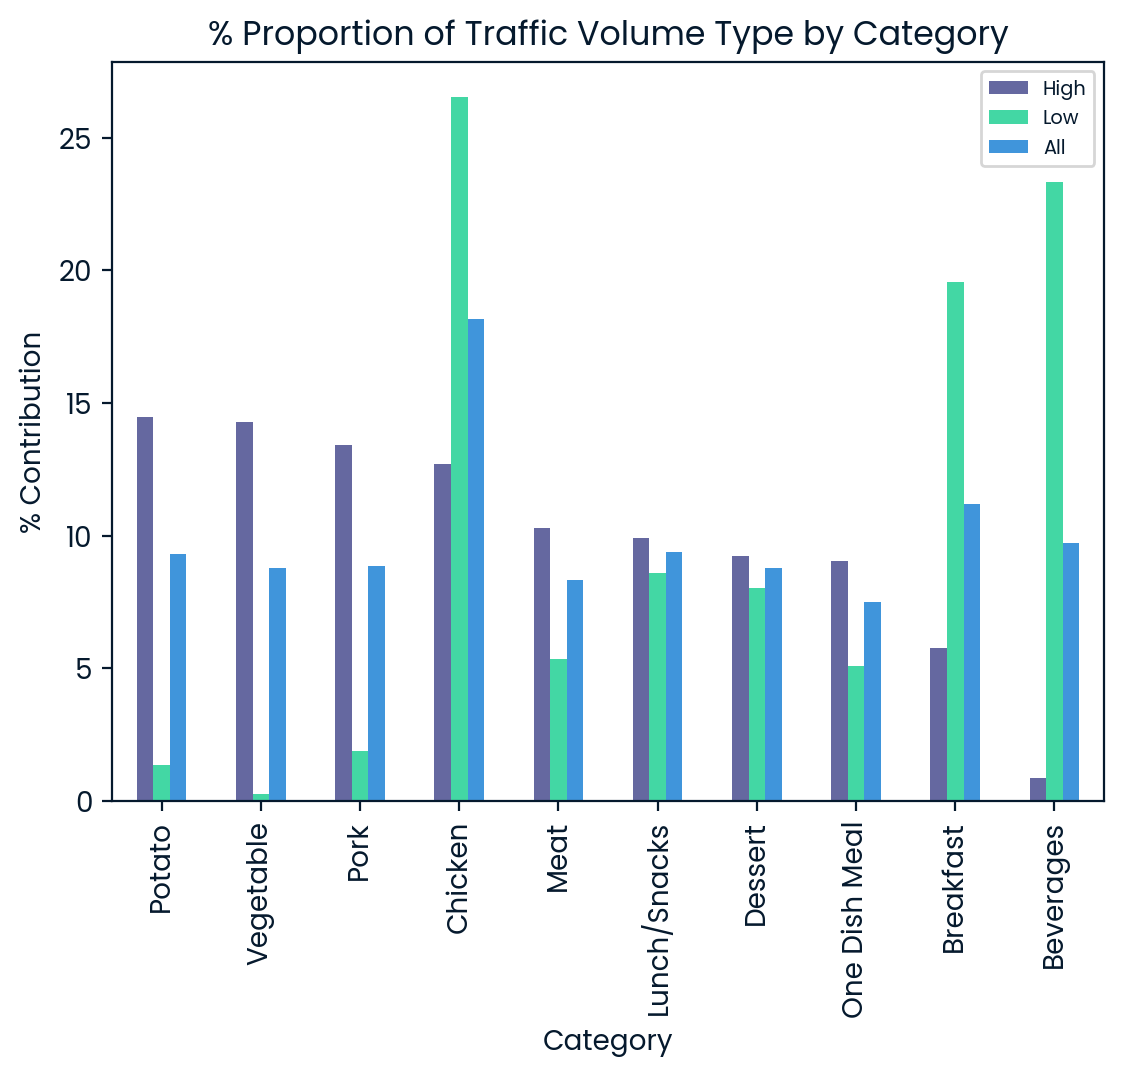

In [50]:
traffic_comp_graph(df,'category',diff=False)

In [51]:
compare_traffic_norm_diff(df, 'category')


% of High by Class  ...  Class % in Data
category                           ...                 
Potato                    14.4599  ...           9.2925
Vegetable                 14.2857  ...           8.7645
Pork                      13.4146  ...           8.8701
Chicken                   12.7178  ...          18.1626
Meat                      10.2787  ...           8.3421
Lunch/Snacks               9.9303  ...           9.3981
Dessert                    9.2334  ...           8.7645
One Dish Meal              9.0592  ...           7.4974
Breakfast                  5.7491  ...          11.1932
Beverages                  0.8711  ...           9.7149

[10 rows x 5 columns]

In [52]:
def diff_cat_check(df,y, x):
    """runs difference of chi square indepedednce between groups and tells 95% conf significance"""
   
    exp, obs, stats = ping.chi2_independence(data = df, y = y, x = x)
    pval = stats[stats.test == 'pearson']['pval'][0]
    [print(x.replace("_", ' ').title() + " is likely associated with " + y.replace("_", ' ').title() + " status (chi2 independence test pval:" + str(pval) + ")") if pval <.05 else print(x.replace("_", ' ').title() + " is not likely associated with " + y.replace("_", ' ').title() + " status (chi2 independence test pval:" + str(pval) + ")")  ]
    

In [53]:
diff_cat_check(df,'high_traffic', 'category')

Category is likely associated with High Traffic status (chi2 independence test pval:3.417304408371102e-63)


### Nutritional information:

- High protein, low sugar and low calorie meals are persisting popular diet trends associated with healthy meals  [(Abbott,2024).](https://www.nutritionnews.abbott/healthy-living/diet-wellness/a-look-at-2024-nutrition-trends/). 
- Thus we have engineered the following fields from the raw data








### Notes on data calorie accuracy: 
- The nutritional information provided consisted of calories, carbohydrates, protein and sugar. 
- The later macro nutrients each contribute 4 calories to the overall caloric value [Healthline, 2022](https://www.healthline.com/nutrition/how-to-count-macros#macros). 
- Possible macro nutrients that also contribute caloric value not listed include: fats and alcohol.
- Each gram of sugar, carb and protein contributes 4 calories.
- Thus the caloric value provided must be at least equal to or more than the calculated caloric value which equates to 4 times the sum of (sugar, carbohydrate, protein), to account for the missing macros(fats, alcohol) not listed.
- Upon initial analysis we found that only ~60% of the data has a calculated caloric value equal to or less than the provided caloric value (df.calories).
- Since the data comes as a set of 4, we will assume that the macros are correctly inputted but the calorie column has mistakes.
- For comparison we have created a calculated calorie field "calc_cal" that takes the greater of raw calories vs calories imputed from macros.
- However since the calorie value was what was displayed and thus more likely what the visitor based their decision on, we will continue to use this for the rest of our analysis.
- Additionally the calc_cal transformation also changes the underlying the shape of the calorie distribution.




In [54]:
#calories for protien sugar and carbs are 4 per gram 
#create calories by macro nutrient

macros = ['carbohydrate', 'sugar', 'protein']

def macro_cals(x):
    return x*4

#create calcuated calories by macro nutrients by mulitplying macro field by 4
df[['carbohydrate_cal', 'sugar_cal', 'protein_cal']] = df[['carbohydrate', 'sugar', 'protein']].apply(lambda x: macro_cals(x))

#create calculated calories count by summming macros
df['calc_cal_raw'] = df[['carbohydrate_cal', 'sugar_cal', 'protein_cal']].sum(axis =1)


#define true false values for calories, if the calc_cal is more than calories then its likely that nutritional info is not correct 
#if calc_cal is less than calories than the difference could be becuase of fat or alchol, which have a caloric value of 9 and 7 respectively and we can round average this to 8
df['cal_diff_bool'] =  df.calories >= df.calc_cal_raw 



In [55]:
#% data where raw calories are equal to or greater than macro calculated calories
#only 60% of the data seems to have accurate calorie info.
check_prop(df, 'cal_diff_bool').rename('% data where raw calories are equal to or greater than macro calculated calories')

True     60.2957
False    39.7043
Name: % data where raw calories are equal to or greater than macro calculated calories, dtype: float64

In [56]:
#difference in calories minus calories caluated from macros
df['cal_diff'] =  df.calories - df.calc_cal_raw 

In [57]:
def cal_diff(x):
    
    if x == 0:
        return "Raw calories equal to calculated macro calories"
    elif x >0:
        return "Raw calories greater than calculated macro calories"
    else:
        return "Raw calories than calculated macro calories"
    
df['cal_vs_calc_diff_bin'] =df['cal_diff'].apply(lambda x: cal_diff(x))


#check impmented correctly
#df[['cal_diff','calories','calc_cal_raw','carbohydrate_cal', 'sugar_cal', 'protein_cal','carbohydrate', 'sugar', 'protein']]

In [58]:
#% data where raw calories are equal to or greater than macro calculated calories
check_prop(df, 'cal_vs_calc_diff_bin').rename('% data where raw calories are equal to or greater than macro calculated calories')


Raw calories greater than calculated macro calories    54.8046
Raw calories than calculated macro calories            39.7043
Raw calories equal to calculated macro calories         5.4910
Name: % data where raw calories are equal to or greater than macro calculated calories, dtype: float64

In [59]:
# create calc cal field that takes the biggger value of the raw calorie value or the calcluated macro calorie value
df['calc_cal'] = df[['calc_cal_raw', 'calories']].max(axis =1) 


#check implemetned correctly
#df[['calories','calc_cal_raw' ,'cal_vs_calc_diff_bin','calc_cal']]

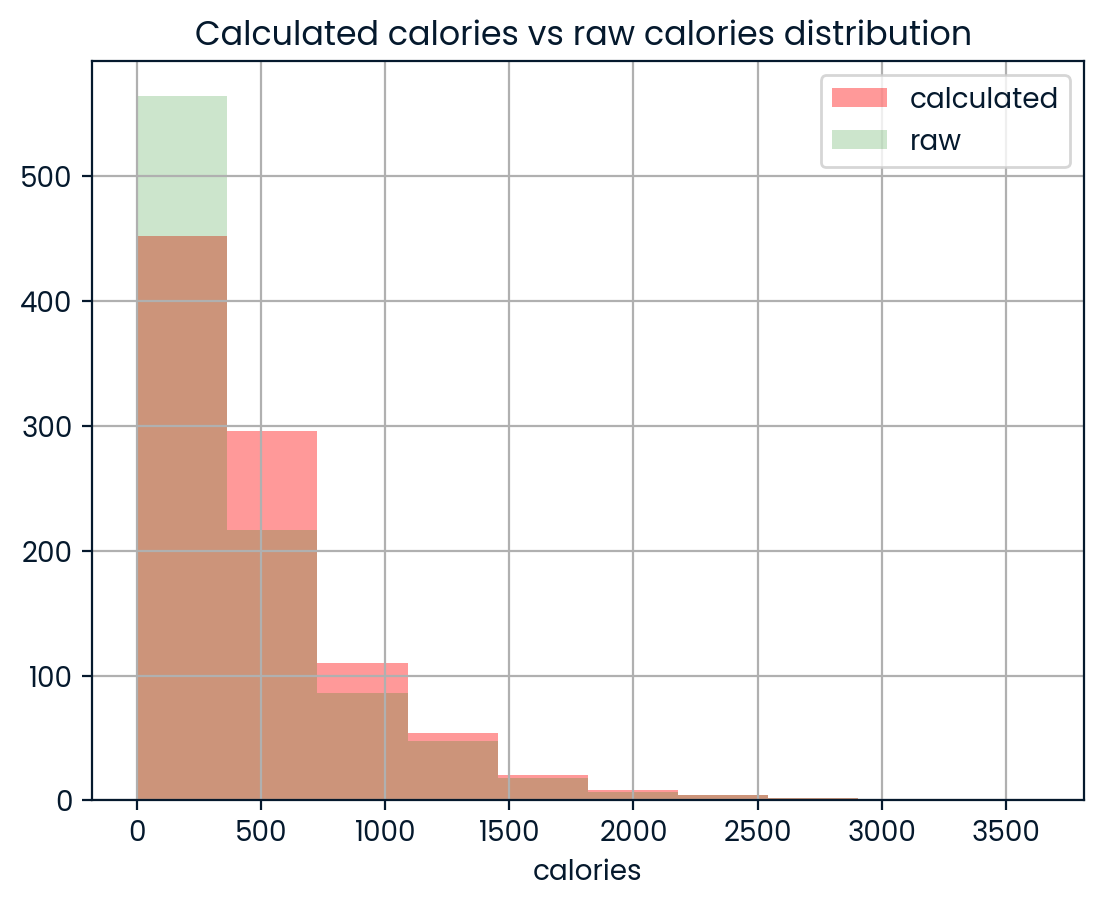

In [60]:
plt.clf()
df.calc_cal.hist( color = 'r', alpha = .4)
df.calories.hist( color = 'g', alpha = .2)
plt.xlabel('calories')
plt.title('Calculated calories vs raw calories distribution ')
plt.legend(["calculated", "raw"], loc="upper right")
plt.show()

- Not all fields in the raw data have nutritional value (52 fields are missing). 
- Based on the limited information given, it is difficult to infer the nutritional info since recipes are inherently varied based on ingredient and amount 
- Additionally people more intuitively digest caloric value as a ballpark figure rather than exact values
- Thus we have created 7 discrete calorie bins in varying increments with greater differentiation for lower caloric values, which are as follows:   

1. 'no_nutri'  
2. 'under_200'
3. '200_to_300'
4. '300_to_400'
5. '400_to_600'
6. '600_to_800' 
7. 'greater_than_800'



- There are more than 2x as many recipes that appear under 200 calories on the website, than the other calorie bin categories
- Just Under 6% of recipes have no nutritional value (5.49%) listed.
- Recipes under 300 calories make up over just 54% of the data.


In [61]:
#create calc size bins compare raw cal vs actual for bins 

df['cal_size'] = pd.cut(df.calories, bins = [0, 0.01,200,300,400,600,800, np.inf],
                        labels=['no_nutri','under_200', '200_to_300', '300_to_400',
                          '400_to_600', '600_to_800', 'greater_than_800'],include_lowest=True, ordered=True)

#convert to ordered categories
df['cal_size'] = pd.Categorical(df['cal_size'], categories = ['no_nutri','under_200', '200_to_300', '300_to_400',
                          '400_to_600', '600_to_800', 'greater_than_800'], ordered= True)
#sense check
#df[['cal_size', 'calories']]

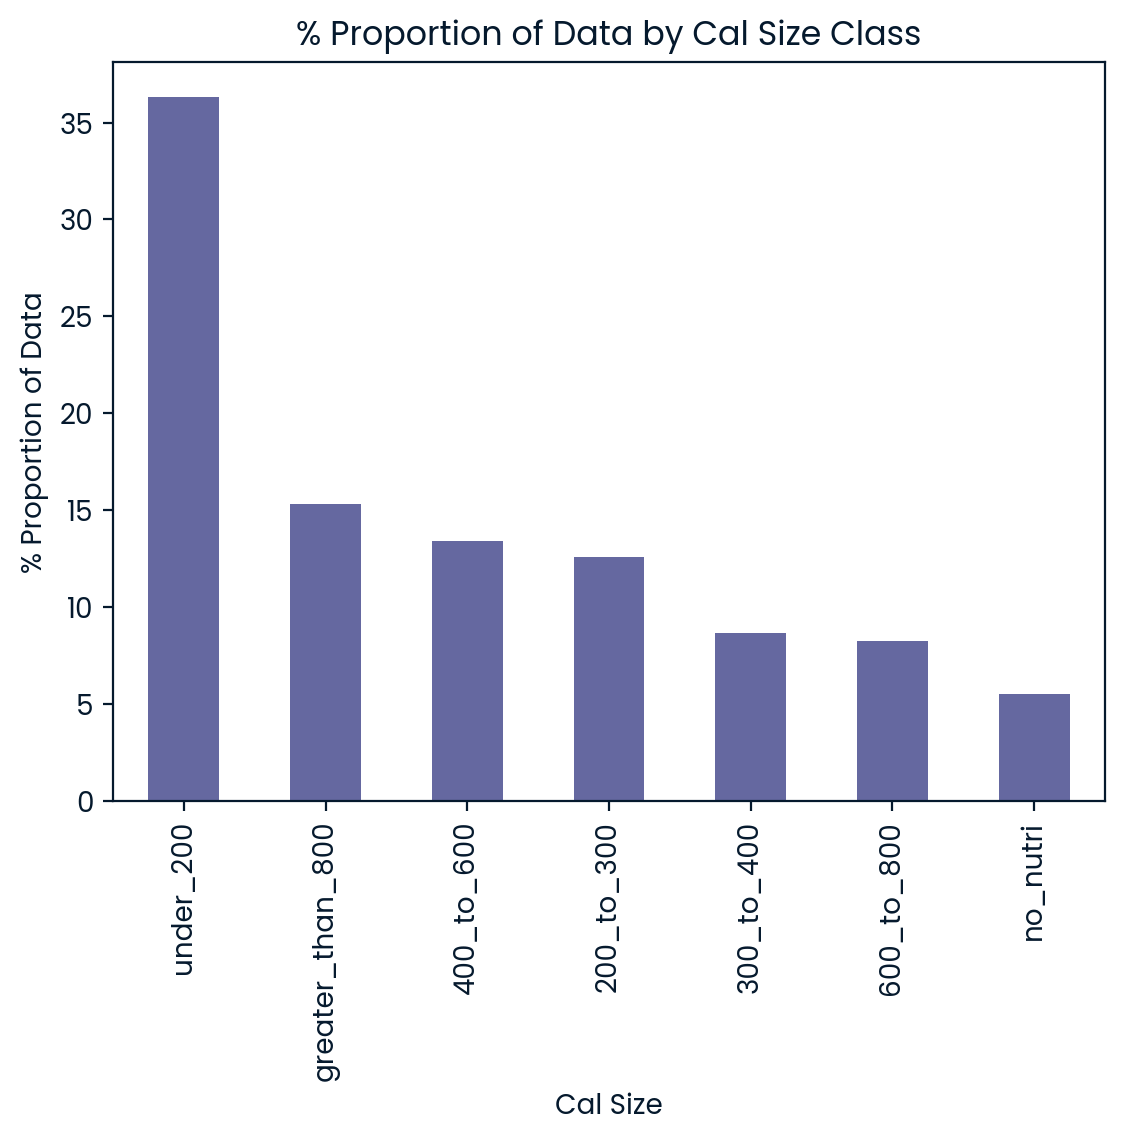

In [62]:
prop_graph(df, 'cal_size')

In [63]:
check_prop(df,'cal_size').sort_index()

no_nutri             5.4910
under_200           36.3252
200_to_300          12.5660
300_to_400           8.6589
400_to_600          13.4108
600_to_800           8.2365
greater_than_800    15.3115
Name: Class % in Data, dtype: float64

- Similar to our research findings suggesting a preference for lower calories, over a third of recipes are under 200 calories (36.36%)
- Although our research suggested that general health advice and consumer interest steer towards lower calorie foods, interestingly, at first glance our sample suggests the opposite.
- Recipes with no nutritional information and recipes with greater than 600 calories have proportionately more recipes considered high traffic volume than smaller calorie bin sizes. 
- This could indicate people do not choose recipes based on a preference for lower calories, or perhaps as mentioned in the prelude the nutritional info is not depicted on the recipe home page preview, but only on the recipe page itself.
- In further iterations of analysis it would be good to know what information is captured in the home page preview.
- Sense checking using the chi-squared independence test gave a p-value greater than .05 significance level (p value : 0.11) suggesting that preference for a specific calorie portion is not likely to impact traffic volume.

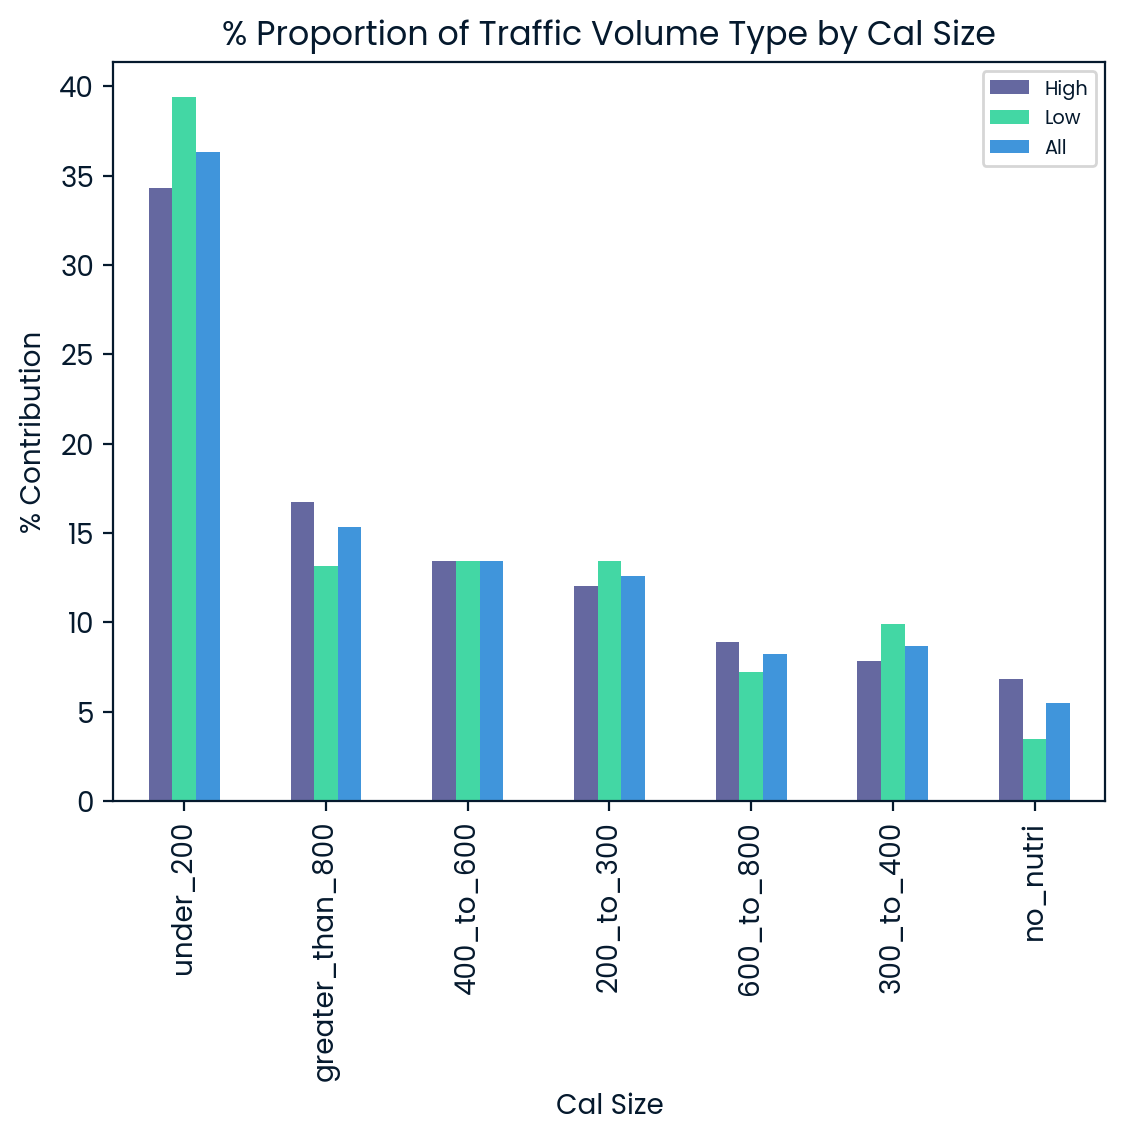

In [64]:

traffic_comp_graph(df,'cal_size', diff=False)

In [65]:

compare_traffic_norm_diff(df, 'cal_size')

% of High by Class  ...  Class % in Data
cal_size                              ...                 
under_200                    34.3206  ...          36.3252
greater_than_800             16.7247  ...          15.3115
400_to_600                   13.4146  ...          13.4108
200_to_300                   12.0209  ...          12.5660
600_to_800                    8.8850  ...           8.2365
300_to_400                    7.8397  ...           8.6589
no_nutri                      6.7944  ...           5.4910

[7 rows x 5 columns]

In [66]:
#create melted df where cont vars become variable name so we can do graphical analysis
cats_df = pd.melt(df, id_vars=['recipe', 'category', 'servings', 'high_traffic']
                  , value_vars= ['calories','protein','sugar','carbohydrate'])


In [67]:
diff_cat_check(df,'high_traffic', 'cal_size')

Cal Size is not likely associated with High Traffic status (chi2 independence test pval:0.11490148534137579)



- The distribution of calories across each of the 10 categories is positively skewed irrespective of traffic volume class. 
- This would suggest that the median would be more representative than the mean for category. 
- The distribution between standardized traffic volume within a category appears most visually significant in: Pork, Vegetable, Meat and Potato. 


Text(0.5, 1.02, 'Distribution of Calories by Category and Traffic Volume Type')

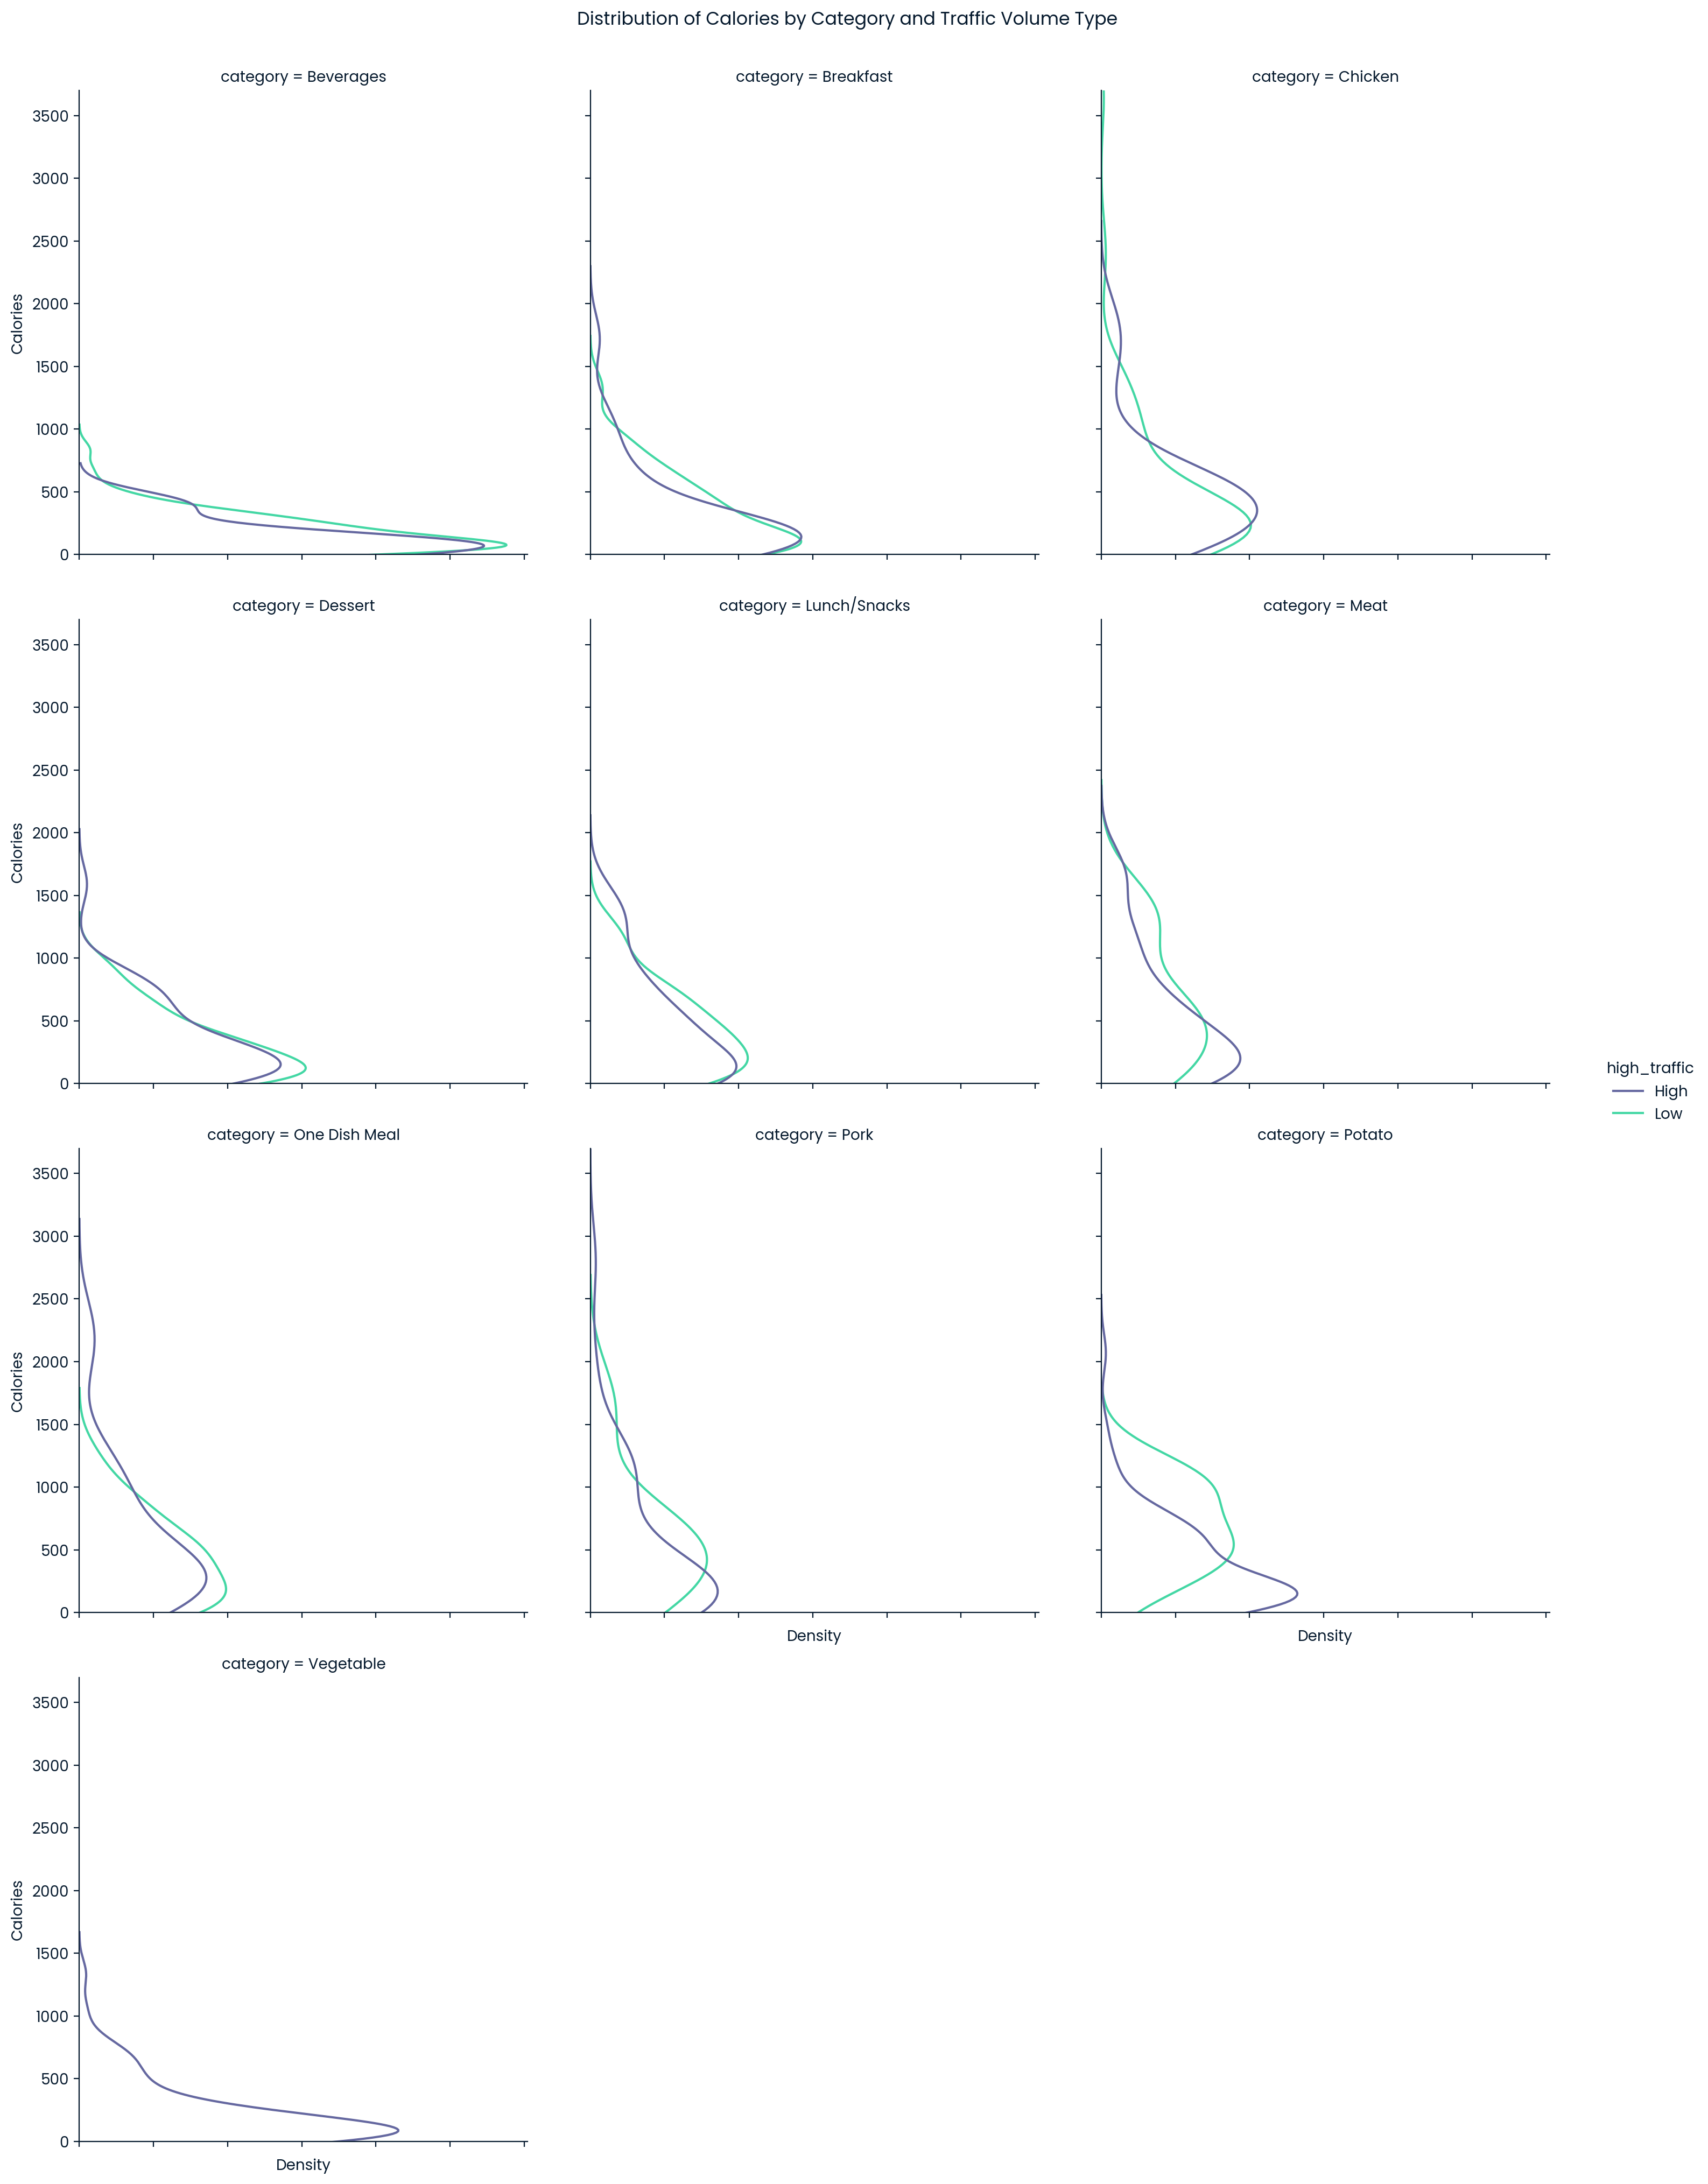

In [68]:
#distibution of calories by category, all appear to be 
g = sns.displot(data = cats_df.query('variable == "calories"'), col = 'category', col_wrap = 3,
                y= 'value',hue = 'high_traffic' , kind = 'kde',common_norm = False ).set( ylabel = 'Calories',ylim=(0,3700) )

#gets rid of some of the x ticks presenting
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle('Distribution of Calories by Category and Traffic Volume Type', y=1.02)

### high_protein_meal: Bool: meals with at least 40g of protein
- Meals with higher protein are considered more satiating, however consumption of meals greater than 40g of protein do not offer any additional value [MayoClinic, 2022](https://www.mayoclinichealthsystem.org/hometown-health/speaking-of-health/are-you-getting-too-much-protein#:~:text=General%20recommendations%20are%20to%20consume,your%20money%20on%20excessive%20amounts). 
- Thus we will create a boolean class flag (1 for true , 0 for false) that is calculated from setting a minimum threshold of 40g of protein
- Since the proportion of traffic volume is the same for both high vs non high protein meals, it's probably unlikely protein content is a deciding factor for users.
- We verified this with a lower threshold from our research set to at least 30g which also yielded the same result
- Since we are not certain about the accuracy of calorie column we have decided against creating calculated metrics regarding the % macro in a meal


In [69]:
#create high protein filter for greater than 40g protein
df['high_protein_meal'] = np.where(df['protein'] >=40, 1,0)

#check
#df[['high_protein_greater40g','protein']]


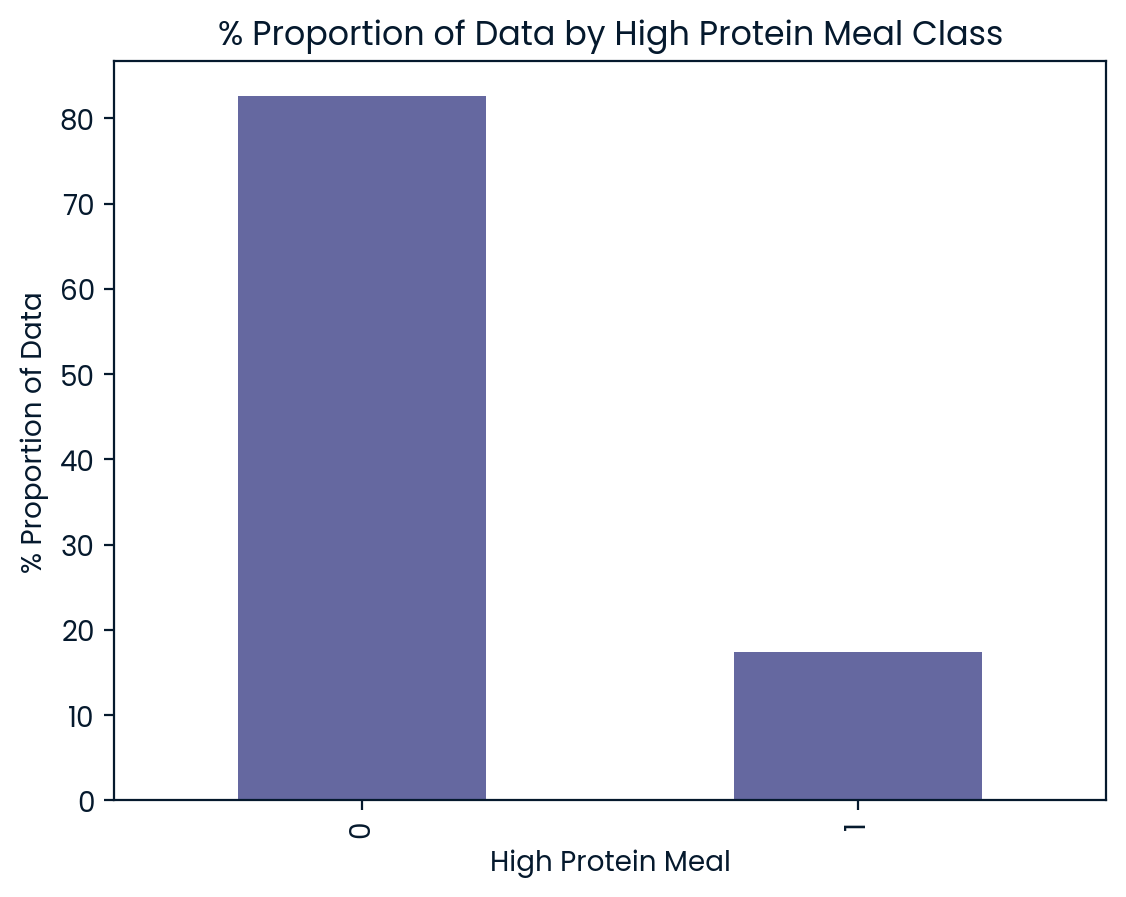

In [70]:
#high protein class split

prop_graph(df, 'high_protein_meal')

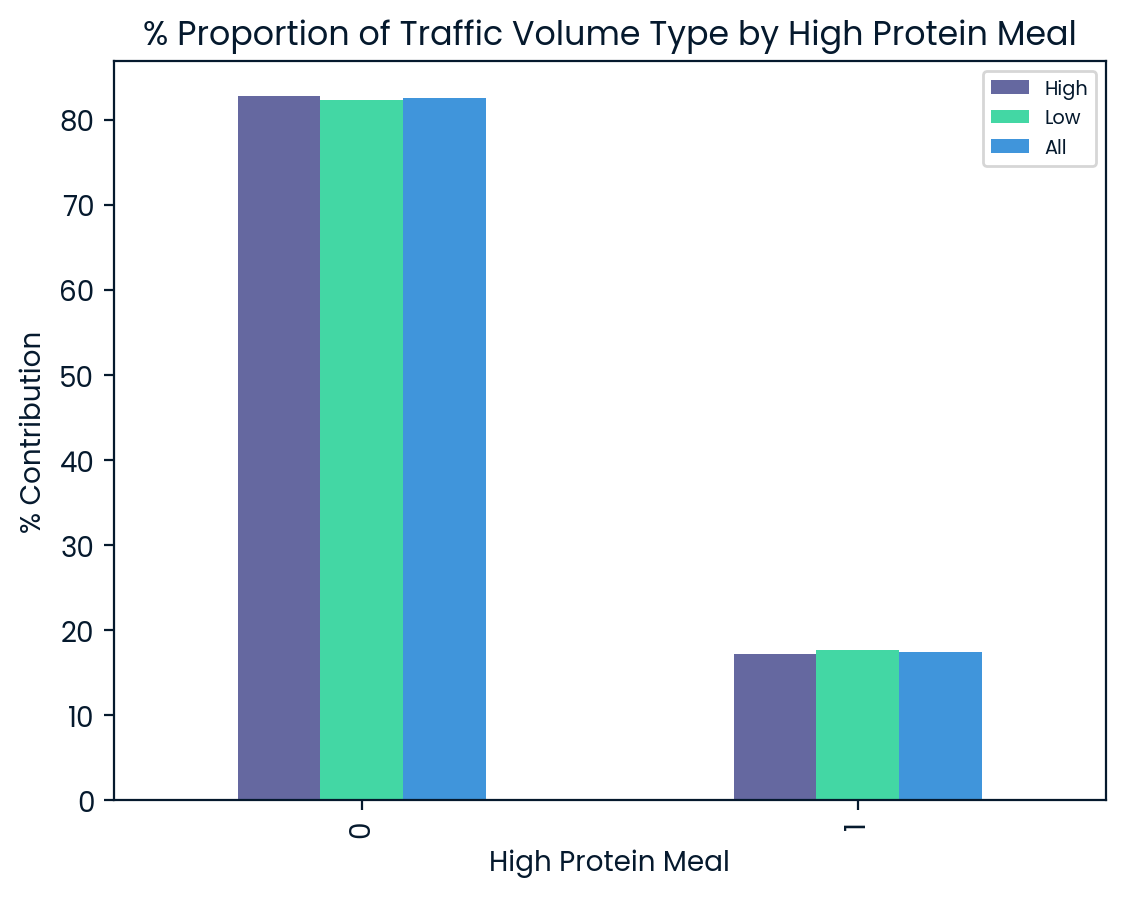

In [71]:
#high protein by traffic class split
traffic_comp_graph(df,'high_protein_meal',diff=False)

- High protein does not appear to impact traffic volume as the distribution of traffic type for high protein vs non high protein meal is the same. 
- This could indicate people do not choose recipes from a high protein health lens, or perhaps as mentioned in the prelude the nutritional info is not depicted on the recipe home page preview, but only on the recipe page itself.
- We have also lowered the threshold to 30g protein in the below analysis yielding no difference to our initial finding.  
- So whilst high traffic recipes tend to have more protein (Wilcoxon-Mann-Whitney pval: 9.25e-19 ) there does not appear to be a preference for high protein meals (chi-squared independence test gave a p-value : 0.928) 
- In further iterations of analysis it would be good to know what information is captured in the home page preview.


In [72]:
compare_traffic_norm_diff(df, 'high_protein_meal')

% of High by Class  ...  Class % in Data
high_protein_meal                      ...                 
0                             82.7526  ...          82.5766
1                             17.2474  ...          17.4234

[2 rows x 5 columns]

In [73]:
#create high protien filter for greater than 30g protein contribution to sense check if this change traffic class balance
df['high_protein_greater30g'] = np.where(df['protein'] >=30, 1,0)

#check
#df[['high_protein_greater30g','protein']]



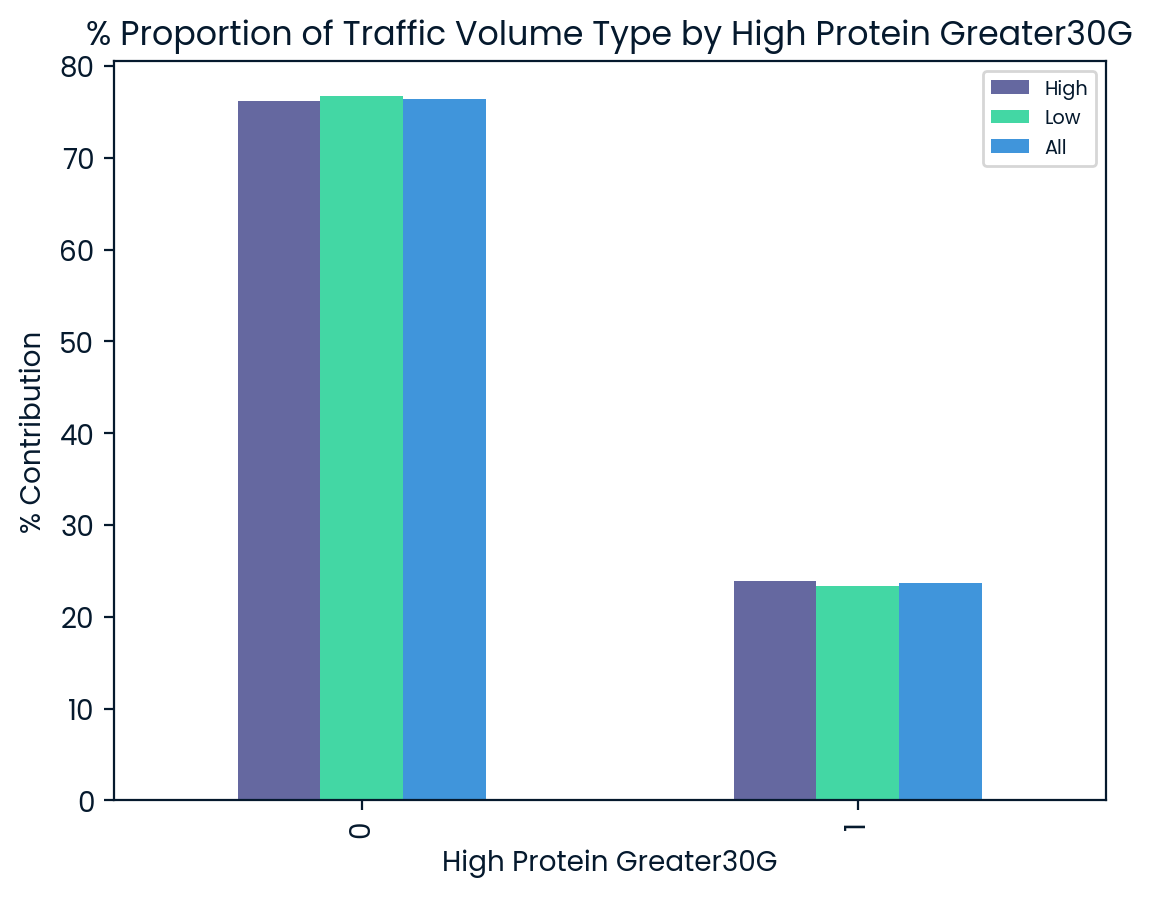

In [74]:
#"%Proportion of Traffic Volume Class for Meals with atleast 30g of Protein"
traffic_comp_graph(df,'high_protein_greater30g', diff=False)

In [75]:
compare_traffic_norm_diff(df, 'high_protein_greater30g')

% of High by Class  ...  Class % in Data
high_protein_greater30g                      ...                 
0                                   76.1324  ...          76.3464
1                                   23.8676  ...          23.6536

[2 rows x 5 columns]

In [76]:
diff_cat_check(df,'high_traffic', 'high_protein_meal')

High Protein Meal is not likely associated with High Traffic status (chi2 independence test pval:0.9286693667408557)



### low_sugar: Bool: beverages less than 5g sugar (but greater than 0 to account for missing nutri info) or non beverages with less than 13g sugar (but greater than 0 to account for missing nutri info)
- Research has shown that high sugar has been linked to poorer health outcomes [MayoClinic, 2022](https://www.mayoclinichealthsystem.org/hometown-health/speaking-of-health/are-you-getting-too-much-protein#:~:text=General%20recommendations%20are%20to%20consume,your%20money%20on%20excessive%20amounts). 
- The guidelines for sugar are complicated and involve calculations. 
- As a rough guideline, adults who consume less than 50 grams of added sugars a day as part of their estimated daily calorie intake of 2000 calories, are considered to be on low sugar diets [MayoClinic, 2022](https://www.mayoclinichealthsystem.org/hometown-health/speaking-of-health/are-you-getting-too-much-protein#:~:text=General%20recommendations%20are%20to%20consume,your%20money%20on%20excessive%20amounts). 
- The literature also suggests that beverages should have less than 5g of sugar per serving [MayoClinic, 2022](https://www.mayoclinichealthsystem.org/hometown-health/speaking-of-health/are-you-getting-too-much-protein#:~:text=General%20recommendations%20are%20to%20consume,your%20money%20on%20excessive%20amounts). 
-  Assuming that an individual has 2 low sugar beverages a day at 5g each. 
-  This leaves 40g sugar remaining (50 -2*5) for their other meals. 
-  Assuming that the average person has 3 meals a day this would average to be about 13g (40/3 = 13.33) per meal conservatively.
-  Thus we will create a boolean flag (1,0) that assigns 1 if the category is beverage and has less than 5 g of sugar (but greater than 0 to account for missing nutri info) and also 1 if the sugar is less than 13g (but greater than 0 to account for missing nutri info) for the other categories.



In [77]:
#create low filter for greater than 30% protein contribution
df['low_sugar'] = np.where((np.logical_and(df.sugar > 0 , df.sugar <=5) & (df.category == 'Beverages'))
                           |(np.logical_and(df.sugar > 0 , df.sugar <=13) & (df.category != 'Beverages')) ,1,0)


#check
#df.groupby(['low_sugar','category'])['sugar'].agg(np.max)
df[['low_sugar','category', 'sugar']]



low_sugar      category  sugar
0            0          Pork   0.00
1            1        Potato   0.66
2            1     Breakfast   3.09
3            0     Beverages  38.63
4            1     Beverages   0.80
..         ...           ...    ...
942          0  Lunch/Snacks  22.39
943          0        Potato   0.00
944          1          Pork   3.57
945          1        Potato   0.97
946          0     Beverages   6.20

[947 rows x 3 columns]

In [78]:
#low sugar distribution in data 
check_prop(df, 'low_sugar')

1    73.812
0    26.188
Name: Class % in Data, dtype: float64

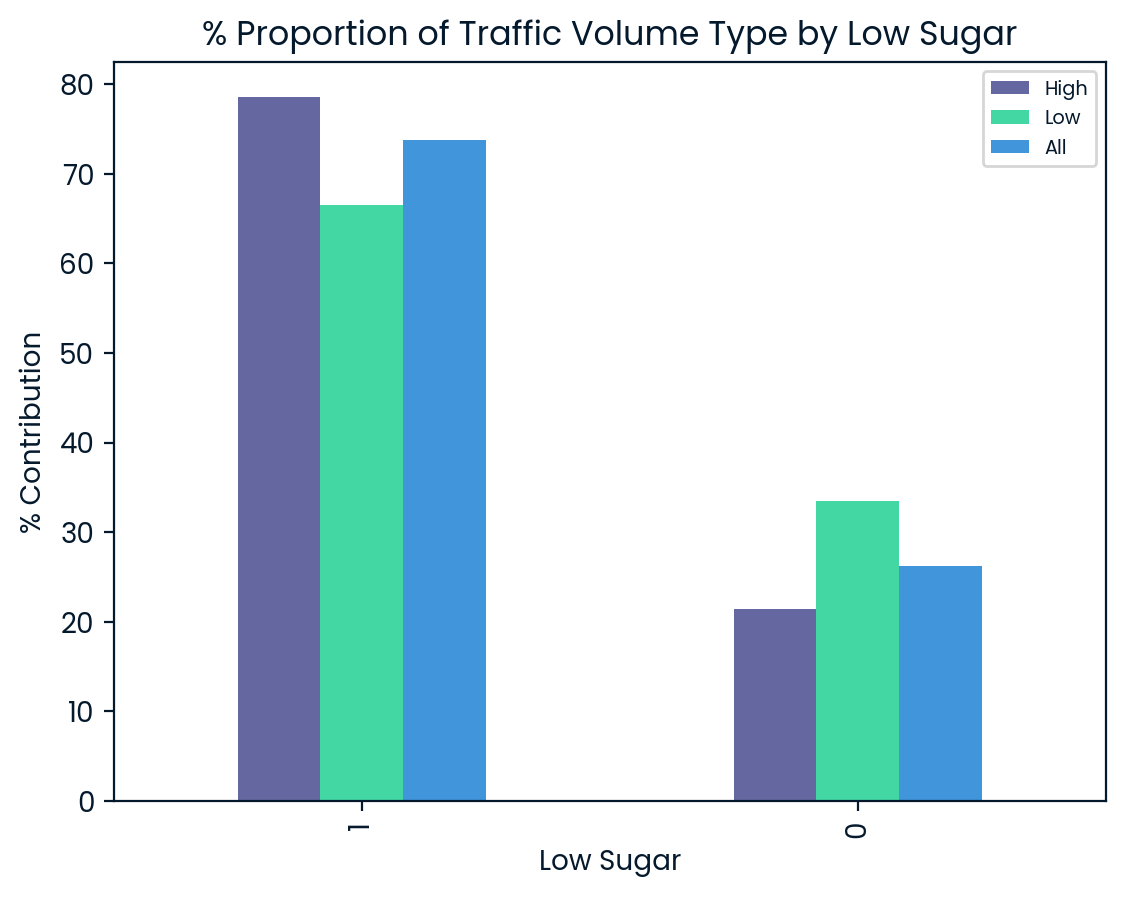

In [79]:
#check low sugar by traffic type
traffic_comp_graph(df,'low_sugar', diff=False)

- From the distribution of traffic by low sugar status it appears that low sugar could be positively correlated with traffic volume, but is hard to tell since the majority of the recipes meet the threshold to qualify as low sugar (~74%).
- Not only does low sugar contribute proportionally more high traffic volume (78.57%) compared to the non low sugar recipes (21.42%) the percentage distribution of traffic type for each class differs significantly indicating that low sugar status is not independent of traffic volume.
- Sense checking with a chi square independence test confirms this (pvalue: 4.97e-05).
- This could indicate people do not choose recipes from a low sugar health perspective, or perhaps as mentioned in the prelude the nutritional info is not depicted on the recipe home page preview, but only on the recipe page itself.
- In further iterations of analysis it would be good to know what information is captured in the home page preview.



In [80]:
#check low sugar by traffic type
compare_traffic_norm_diff(df, 'low_sugar')

% of High by Class  ...  Class % in Data
low_sugar                      ...                 
1                     78.5714  ...           73.812
0                     21.4286  ...           26.188

[2 rows x 5 columns]

In [81]:
diff_cat_check(df,'high_traffic', 'low_sugar')

Low Sugar is likely associated with High Traffic status (chi2 independence test pval:4.9734593262908406e-05)


- The distribution of sugar across each of the 10 categories is positively skewed irrespective of traffic volume class.
- This would suggest that the median would be a more representative measure of center than the mean for categories.
- When standardized for traffic volume type, there is a greater significant difference between the distribution of sugar in each category by traffic volume type than for calories.
- The differences in distribution between standardized traffic volume for sugar appears most pronounced in Lunch/Snacks, Potato and Vegetable.

Text(0.5, 1.02, 'Distribution of Sugar by Category and Traffic Volume Type')

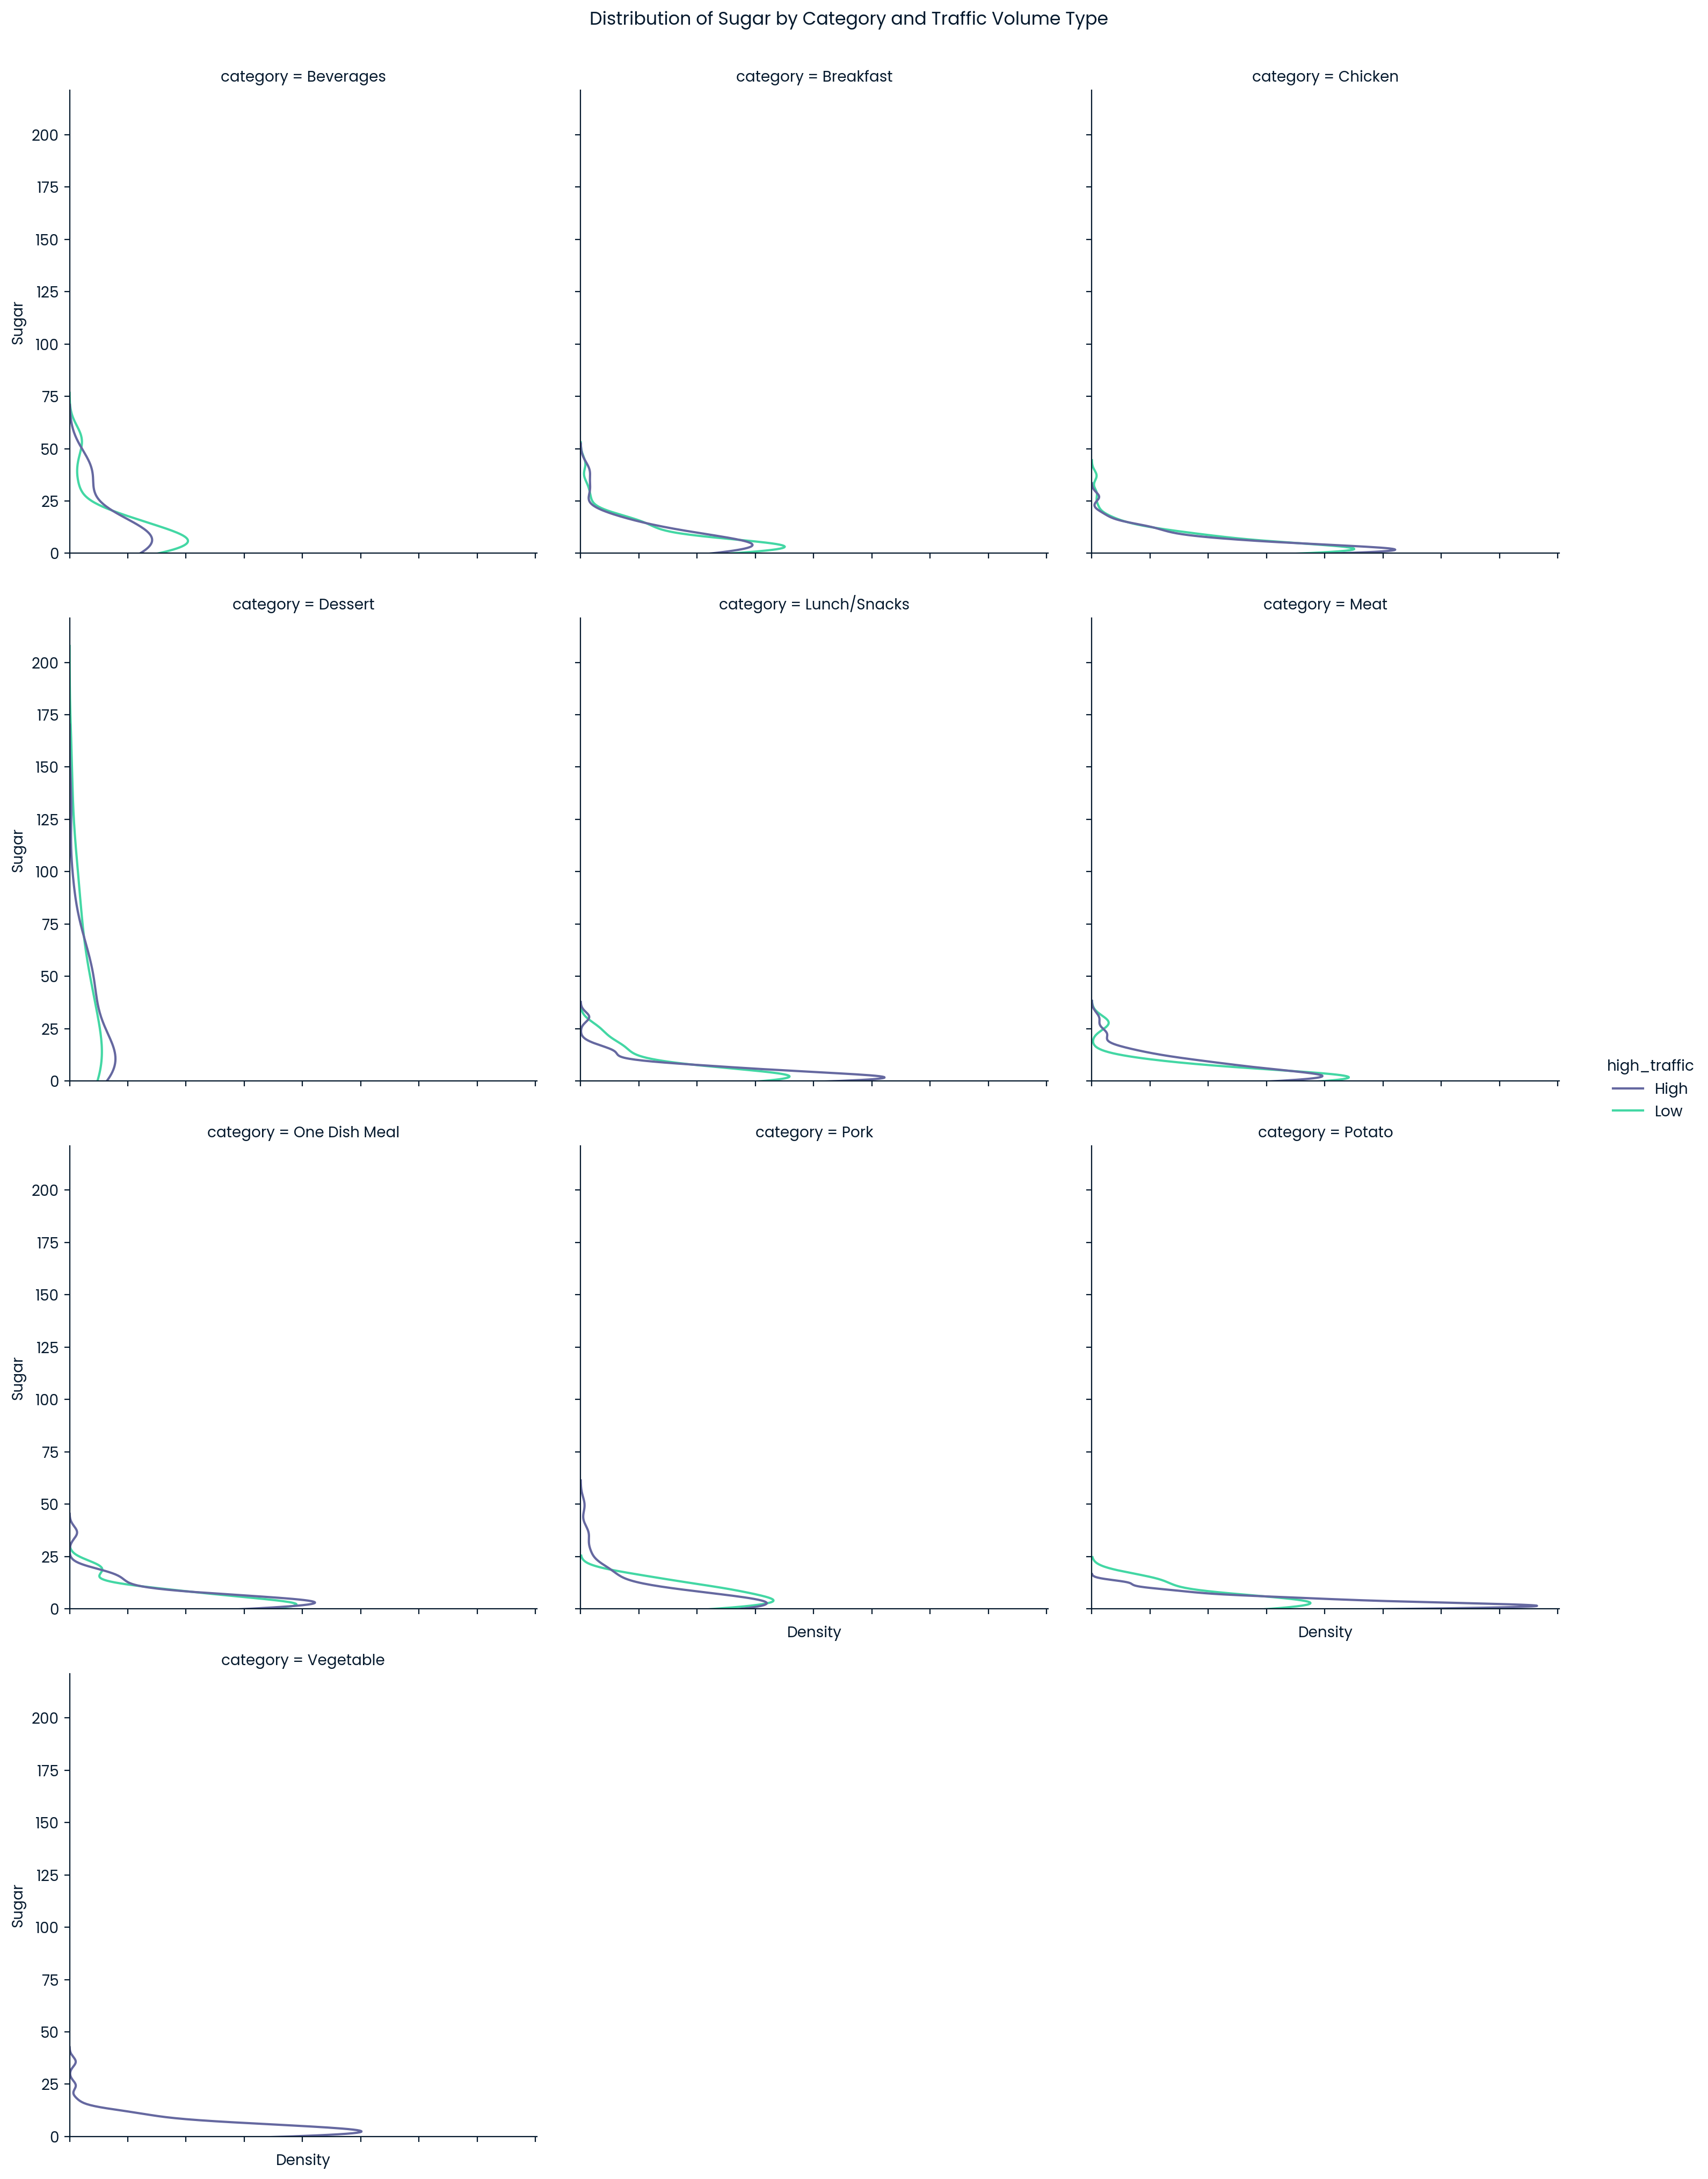

In [82]:
#distibution of calories by category, all appear to be 
g = sns.displot(data = cats_df.query('variable == "sugar"'), col = 'category', col_wrap = 3,
                y= 'value',hue = 'high_traffic' , kind = 'kde',common_norm = False ).set( ylabel = 'Sugar', ylim = 0 )

#gets rid of some of the x ticks presenting
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle('Distribution of Sugar by Category and Traffic Volume Type', y=1.02)


### low_carb_meal: Bool: beverages less than 5g carbs (but more than 0 to account for missing nutri info ) or non beverages with less than 40g carbs (but more than 0 to account for missing nutri info)

- Research has shown that limiting carbohydrate intake may help with weight management and weight loss due to the bioavailability of carbs as an energy source and also the thermogenics of protein that impact satiety [healthline, 2023](https://www.healthline.com/nutrition/low-carb-diet-meal-plan-and-menu#bottom-line).
- As a rough guideline adults on a daily 2000 cal intake and who consume less than 130 grams of carbs a day are considered to be on low carb diets [healthline, 2023](https://www.healthline.com/nutrition/low-carb-diet-meal-plan-and-menu#bottom-line)
- Assuming that the average person has 3 meals a day this would average to be about 40g (130/3 = 43.33) per meal conservatively.
- Thus we will create a boolean flag (1,0) that assigns 1 if the category is beverage and has less than 5 g or carbs (but greater than 0 to account for missing nutri info) and also 1 if the carbs is less than 40g (but greater than 0 to account for missing nutri info) for the other categories.



In [83]:
#low carb diet is defined as consuming less than 130g of carbs a day. 
df['low_carb_meal'] = np.where((np.logical_and(df.carbohydrate > 0 , df.carbohydrate <=5)  & (df.category == 'Beverages')) | 
                               (np.logical_and(df.carbohydrate > 0 , df.carbohydrate <=40) & (df.category != 'Beverages')) ,1,0)
#check
#df[['low_carb_meal', 'category','carbohydrate']]

In [84]:
#low carb distribution in data 
check_prop(df, 'low_carb_meal')

1    61.774
0    38.226
Name: Class % in Data, dtype: float64

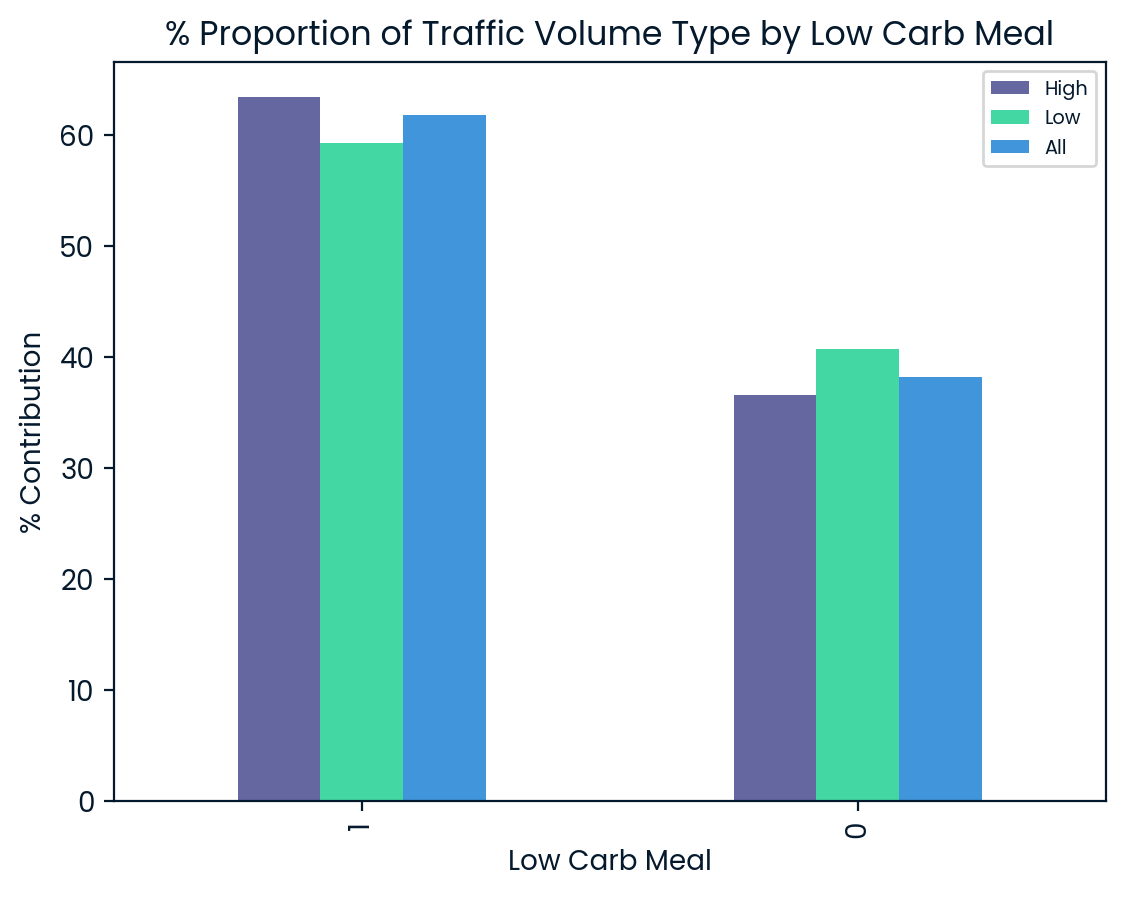

In [85]:
#check low carb by traffic type
traffic_comp_graph(df,'low_carb_meal', diff=False)

- From the distribution of traffic by low carb status it appears that low carb could have a small inverse impact on traffic volume.

- Whilst low carb recipes (62%) has proportionately more high traffic volume than low carb recipes (58%) the percentage distribution of traffic type irrespective of carb status does not appear to differ too significantly,  indicating that a recipe’s low carb status is likely to be independent of it’s traffic volume.

- This could indicate people do not choose recipes based on nutritional info, or perhaps as mentioned in the prelude the nutritional info is not depicted on the recipe home page preview, but only on the recipe page itself.

- In further iterations of analysis it would be good to know what information is captured in the home page preview.





In [86]:
#check low sugar by traffic type
compare_traffic_norm_diff(df, 'low_carb_meal')

% of High by Class  ...  Class % in Data
low_carb_meal                      ...                 
1                         63.4146  ...           61.774
0                         36.5854  ...           38.226

[2 rows x 5 columns]

In [87]:
diff_cat_check(df,'high_traffic','low_carb_meal') 

Low Carb Meal is not likely associated with High Traffic status (chi2 independence test pval:0.2223088585379737)


#### servings:

- The most popular serving size was 4 servings accounting for 40% 
- The remainder serving categories were pretty evenly split across the other 60%


In [88]:
check_prop(df, 'servings')

4    41.3939
6    20.8025
2    19.3242
1    18.4794
Name: Class % in Data, dtype: float64

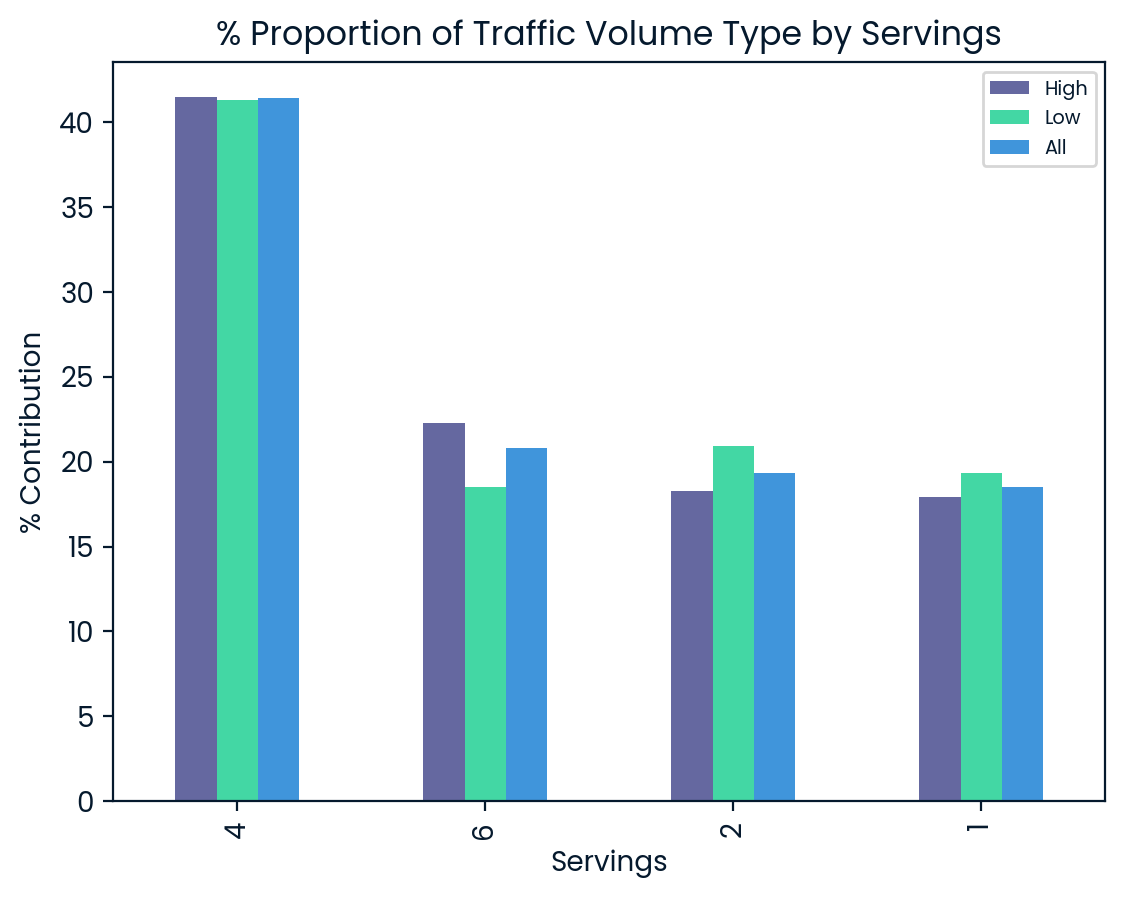

In [89]:
#check servings by traffic type
traffic_comp_graph(df,'servings', diff=False)

- The distribution of traffic type does not appear to differ too significantly across the servings sizes.
- Serving size 6 appears only marginally more favorable because despite only making up only 20% of recipes it makes up  22% of overall high traffic volume, however this effect looks very small. 
- This indicates that serving sizes are probably unlikely to be a deciding factor for users.
- Sense checking with a chi square independence test confirms this (pval:0.45)


In [90]:
#check servings by traffic type
compare_traffic_norm_diff(df, 'servings')

% of High by Class  ...  Class % in Data
servings                      ...                 
4                    41.4634  ...          41.3939
6                    22.2997  ...          20.8025
2                    18.2927  ...          19.3242
1                    17.9443  ...          18.4794

[4 rows x 5 columns]

In [91]:
diff_cat_check(df,'high_traffic', 'servings')

Servings is not likely associated with High Traffic status (chi2 independence test pval:0.45746671590169197)


# Model Fitting & Evaluation

Predicting whether or not a recipe will likely generate high traffic volume makes this problem a binary (high traffic vs low traffic) classification task.
As per the data validation, the raw data set contained a total of 8 columns.
When removed of the unique identifier column (recipe) and target feature (high_traffic) this left 6 remaining potential features to choose from. 


These are comprised of : 
- 4 continuous (calories, sugar, protein, carbohydrates)
- 2 categorical (category and servings)
    
    
    
To visualize the impact of the continuous variables on the target (high_traffic) we created 4 categorical features from calories, protein, sugar and carbohydrate respectively. : 
    1) calorie_size
    2) high_protein
    3) low_sugar 
    4) low_carb 
    
    
    
Since caloric information varies so much between recipes and is dependent on ingredients and volume I decided against removing outliers and to observe the continuous variables as they are. 

We have chosen to create 3 variations of the cleansed dataset, to help determine the most useful features and to minimize multicollinearity: 

Each variant set contains the one hot encoded categorical variables derived from servings and category and differ only in their modification of the continuous variables in the following ways:

- Variant 1: (cat_cont) : Categorical features: Categorical bins are defined with set thresholds (aforementioned 4 feature engineered features)
- Variant 2: (num_scaled) : Continuous Features are scaled using MinMaxScaler() 
- Variant 3: (num_norm) : Continuous Features are normalized using PowerTransformer() 



We have also dummy encoded our target feature.


Due to their ease of interpretation and ability to implement I have chosen the following classification models to compare: 
1.  Logistic Regression (lLinear)
2.  RandomForest (Non linear)
3.  SGD Classifier (Linear)
4.  Gradient Boosting Classifier (Non linear)


In [92]:
#set seeed
seed = 1111

# select relevent features for prediction
X = df[['cal_size', 'category', 'servings', 'high_protein_meal', 'high_protein_greater30g',
       'low_sugar','calories', 'carbohydrate', 'sugar', 'protein']]

#sense check X
print(X.columns)
#One hot encode y
y = df[['high_traffic']]



Index(['cal_size', 'category', 'servings', 'high_protein_meal',
       'high_protein_greater30g', 'low_sugar', 'calories', 'carbohydrate',
       'sugar', 'protein'],
      dtype='object')


In [93]:

#split our data strafiy by to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=seed)  
#check class of y_train
print(y_train.value_counts(normalize =True))
print(y_test.value_counts(normalize =True))
print(len(X_train)/len(X_test))



high_traffic
High            0.606341
Low             0.393659
dtype: float64
high_traffic
High            0.605263
Low             0.394737
dtype: float64
3.9842105263157896


In [94]:
#instantialize one hot encoder for dummy of y
y_encode =  OneHotEncoder(drop = ['Low'], sparse_output = False).set_output(transform = 'pandas')
y_train = y_encode.fit_transform(y_train)
y_test = y_encode.transform(y_test)

#check class of y after dummies encoding
print(y_train.value_counts(normalize =True))
print(y_test.value_counts(normalize =True))

high_traffic_High
1.0                  0.606341
0.0                  0.393659
dtype: float64
high_traffic_High
1.0                  0.605263
0.0                  0.394737
dtype: float64


In [95]:
print(X_train.head())

#perform one hot encoding on categorical data
cat_vars = ['category', 'cal_size', 'servings']

#numerical data, scaling required
num_vars = ['calories', 'carbohydrate', 'sugar', 'protein']     

#no need to dummy encode already dummy encoded 
x_dummies = ['high_protein_meal', 'high_protein_greater30g', 'low_sugar']

#create colum transformer object to pre process
ct =make_column_transformer( (OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_vars)
                            ,(PowerTransformer(), num_vars)
                            ,(MinMaxScaler(), num_vars)
                            ,remainder = 'passthrough').set_output(transform ='pandas')






             cal_size   category  servings  ...  carbohydrate  sugar  protein
173         under_200    Dessert         2  ...         12.40  24.65     5.08
445        300_to_400    Dessert         2  ...         15.19   9.22     2.49
432  greater_than_800    Chicken         4  ...         36.65   5.66    16.72
276         under_200  Vegetable         2  ...          1.90   3.76     0.05
398         under_200       Pork         4  ...         14.75   3.01    16.34

[5 rows x 10 columns]


In [96]:
#fit the column transformer on X_train
X_train_clean = ct.fit_transform(X_train)
X_train_clean.head()


onehotencoder__category_Beverages  ...  remainder__low_sugar
173                                0.0  ...                     0
445                                0.0  ...                     1
432                                0.0  ...                     1
276                                0.0  ...                     1
398                                0.0  ...                     1

[5 rows x 32 columns]

In [97]:
def clean_col_name(x):
    """cleans clean data columns"""
    x=str(x)
    return x.replace("onehotencoder__","").replace("powertransformer__","normalized_").replace("minmaxscaler__","scaled_").replace("remainder__","")
   

X_train_clean.columns= [clean_col_name(i) for i in X_train_clean.columns]



In [98]:
#sense check transformation
print(X_train_clean.head())
X_train_clean.describe()

     category_Beverages  category_Breakfast  ...  high_protein_greater30g  low_sugar
173                 0.0                 0.0  ...                        0          0
445                 0.0                 0.0  ...                        0          1
432                 0.0                 0.0  ...                        0          1
276                 0.0                 0.0  ...                        0          1
398                 0.0                 0.0  ...                        0          1

[5 rows x 32 columns]


category_Beverages  ...   low_sugar
count          757.000000  ...  757.000000
mean             0.095112  ...    0.751651
std              0.293564  ...    0.432341
min              0.000000  ...    0.000000
25%              0.000000  ...    1.000000
50%              0.000000  ...    1.000000
75%              0.000000  ...    1.000000
max              1.000000  ...    1.000000

[8 rows x 32 columns]

In [99]:
#fit the column transformer on X_test
X_test_clean = ct.fit_transform(X_test)
#clean column names
X_test_clean.columns= [clean_col_name(i) for i in X_test_clean.columns]
print(X_test_clean.head())
X_test_clean.describe()

     category_Beverages  category_Breakfast  ...  high_protein_greater30g  low_sugar
914                 0.0                 0.0  ...                        0          1
871                 0.0                 0.0  ...                        1          1
360                 0.0                 0.0  ...                        0          1
790                 0.0                 0.0  ...                        0          0
307                 0.0                 1.0  ...                        0          0

[5 rows x 32 columns]


category_Beverages  ...   low_sugar
count          190.000000  ...  190.000000
mean             0.105263  ...    0.684211
std              0.307703  ...    0.466058
min              0.000000  ...    0.000000
25%              0.000000  ...    0.000000
50%              0.000000  ...    1.000000
75%              0.000000  ...    1.000000
max              1.000000  ...    1.000000

[8 rows x 32 columns]

In [100]:
#
cat_cont = ['category_Beverages', 'category_Breakfast', 'category_Chicken',
       'category_Dessert', 'category_Lunch/Snacks', 'category_Meat',
       'category_One Dish Meal', 'category_Pork', 'category_Potato',
       'category_Vegetable', 'cal_size_200_to_300', 'cal_size_300_to_400',
       'cal_size_400_to_600', 'cal_size_600_to_800',
       'cal_size_greater_than_800', 'cal_size_no_nutri',
       'cal_size_under_200', 'servings_1', 'servings_2', 'servings_4',
       'servings_6','high_protein_meal',
       'high_protein_greater30g', 'low_sugar']

num_scale =['category_Beverages', 'category_Breakfast', 'category_Chicken',
       'category_Dessert', 'category_Lunch/Snacks', 'category_Meat',
       'category_One Dish Meal', 'category_Pork', 'category_Potato',
       'category_Vegetable','servings_1', 'servings_2', 'servings_4',
       'servings_6', 'scaled_calories', 'scaled_carbohydrate',
       'scaled_sugar', 'scaled_protein',
        ]

num_norm = ['category_Beverages', 'category_Breakfast', 'category_Chicken',
       'category_Dessert', 'category_Lunch/Snacks', 'category_Meat',
       'category_One Dish Meal', 'category_Pork', 'category_Potato',
       'category_Vegetable','servings_1', 'servings_2', 'servings_4',
       'servings_6',   'normalized_calories', 'normalized_carbohydrate',
       'normalized_sugar', 'normalized_protein',
        ]

In [101]:
def compare_models_graph_logreg( model, cols, vartype):
    """make graph for linear model by showcasing feature importance using coefs"""

    title = 'Feature Importance in ' + vartype + ' Var Group in '+  model[0] + ' Model'
    X_train_subset = X_train_clean.loc[:,cols]
    X_test_subset = X_test_clean.loc[:,cols]

    model_sub = model[1].fit( X_train_subset, y_train)

    coef_init = pd.DataFrame({'features': [i for i in model_sub.feature_names_in_], 'feature_importance': abs(np.reshape(np.exp(model_sub.coef_),-1))}).sort_values('feature_importance', ascending =False)
    
    prec_score = precision_score( y_test, model_sub.predict(X_test_subset))
    print(model[0] + ' Model with ' + vartype + ' Var Group has ' + "Precision score of {prec_score:.2f}".format(prec_score=prec_score))
    coef_init.plot(x = 'features', y ='feature_importance' , kind = 'bar').set(title= title, xlabel ='Features', ylabel = 'Feature Importance')
    plt.show()


        
     

In [102]:
def compare_models_graph_tree( model, cols, vartype):
    """make graph for free model by showcasing feature importance using feature importance"""
    
    title = 'Feature Importance of ' + vartype + ' Var Group in '+  model[0] + ' Model'
    X_train_subset = X_train_clean.loc[:,cols]
    X_test_subset = X_test_clean.loc[:,cols]

    model_sub = model[1].fit( X_train_subset, y_train)

    coef_init = pd.DataFrame({'features': [i for i in model_sub.feature_names_in_], 'feature_importance': [i for i in model_sub.feature_importances_]}).sort_values('feature_importance', ascending =False)
    prec_score = precision_score( y_test, model_sub.predict(X_test_subset))
    print(model[0] + ' Model with ' + vartype + ' Var Group has ' + "Precision score of {prec_score:.2f}".format(prec_score=prec_score))
    
    coef_init.plot(x = 'features', y ='feature_importance' , kind = 'bar').set(title= title, xlabel ='Features', ylabel = 'Feature Importance')
    plt.show()


In [103]:
def compare_models_graphs( model, cols, vartype):
    if model[0] in ['Logistic Regression', 'SGD Classifier']:
        return compare_models_graph_logreg( model, cols, vartype)
    else:
        return compare_models_graph_tree( model, cols, vartype)

In [104]:
#list of models to explore
classifiers = [("Logistic Regression", LogisticRegression( class_weight= {0:.39, 1:.61}, random_state = seed))
               ,('Random Forest Classifier', RandomForestClassifier(random_state = seed, max_depth = 9, n_estimators = 300))
              ,('SGD Classifier', SGDClassifier(class_weight= {0:.39, 1:.61}, random_state = seed)),
            ('GB Classifier', GradientBoostingClassifier( random_state = seed, max_depth = 5, n_estimators = 300 ))  ]


In [105]:
def make_model_comparsions_train(classifiers, variables , vartypes, metric) :
    """returns table of accuracy scores for list of models by diferent cateogries """
   
    
    
    def make_model_comparsions_train_inner(classifiers, cols, vartype):
   
        
        acc_scores = {}

        for name, model in classifiers:
            X_train_subset = X_train_clean.loc[:,cols]
            X_test_subset = X_test_clean.loc[:,cols]
            model_sub = model.fit( X_train_subset, y_train)
            acc_scores[name] =metric( y_train, model_sub.predict(X_train_subset))
            model_comp = pd.DataFrame(acc_scores, index=[vartype])
        
        return model_comp
    
    fin = pd.DataFrame()
    for cols, vartype in  zip(variables,vartypes):
        fin = fin.append(make_model_comparsions_train_inner(classifiers, cols, vartype))
        
        
        
    fin.rename_axis('var_type_fit', inplace = True)
    
    return fin

In [106]:
def make_model_comparsions_test(classifiers, variables , vartypes, metric) :
    """returns table of accuracy scores for list of models by diferent cateogries """
   
    
    
    def make_model_comparsions_test_inner(classifiers, cols, vartype):
   
        
        acc_scores = {}

        for name, model in classifiers:
            X_train_subset = X_train_clean.loc[:,cols]
            X_test_subset = X_test_clean.loc[:,cols]
            model_sub = model.fit( X_train_subset, y_train)
            acc_scores[name] =metric( y_test, model_sub.predict(X_test_subset))
            model_comp = pd.DataFrame(acc_scores, index=[vartype])
        
        return model_comp
    
    fin = pd.DataFrame()
    for cols, vartype in  zip(variables,vartypes):
        fin = fin.append(make_model_comparsions_test_inner(classifiers, cols, vartype))
        
        
        
    fin.rename_axis('var_type_test', inplace = True)
    
    return fin

In [107]:
def validate_model_comparsions(classifiers, variables , vartypes, metric):
    """returns table of accuracy scores for list of models by diferent cateogries """
    def validate_model_comparsions_inner(classifiers, cols, vartype):
        acc_scores = {}
        
        for name, model in classifiers:
            #create replcable Stratfied Kfold for binary classifcatoin
            skf =StratifiedKFold(shuffle=True, random_state =seed)
            X_train_subset = X_train_clean.loc[:,cols]
            X_test_subset = X_test_clean.loc[:,cols]
            #create 5 kfold cross val score
            metric_cv = cross_val_score(model,X_train_subset, y_train, cv = skf, scoring =make_scorer(metric) )
            #compare test to average cross vals core 
            acc_scores[name] =metric_cv.mean()
            model_comp = pd.DataFrame(acc_scores, index=[vartype])
            
        return model_comp
    fin = pd.DataFrame()
    
    for cols, vartype in  zip(variables,vartypes):
        fin = fin.append(validate_model_comparsions_inner(classifiers, cols, vartype))

    fin.rename_axis('var_type_cv', inplace = True)
    return fin

### Model Evaluation: Precision Score

- When fitted for all the features of a variant dataset we can see that the categorical data set has the most consistent results, producing not only the smallest difference between train, validate and test precision scores but also highest validate and test precision scores.
- The SGD Classifier fitted with the categorical data set gives the highest test precision score of 0.788, followed closely by the SGD Classifier fitted with the scaled data set (precision score: 0.784) then GB Classifier fitted with the categorical data (precision score :0.763)
- These results suggest that linear models (SGD Classifier) might be a better fit when including all features of a the data set.



In [108]:
prec_scores_train = make_model_comparsions_train(classifiers, [num_norm, num_scale, cat_cont], ["Normalized", "Scaled", "Categorical"],precision_score)
prec_scores_train

Logistic Regression  ...  GB Classifier
var_type_fit                       ...               
Normalized               0.717391  ...       0.995662
Scaled                   0.714286  ...       0.995662
Categorical              0.719799  ...       0.879747

[3 rows x 4 columns]

Text(0.5, 1.1, 'Train Precision Scores by Model by Data Variant')

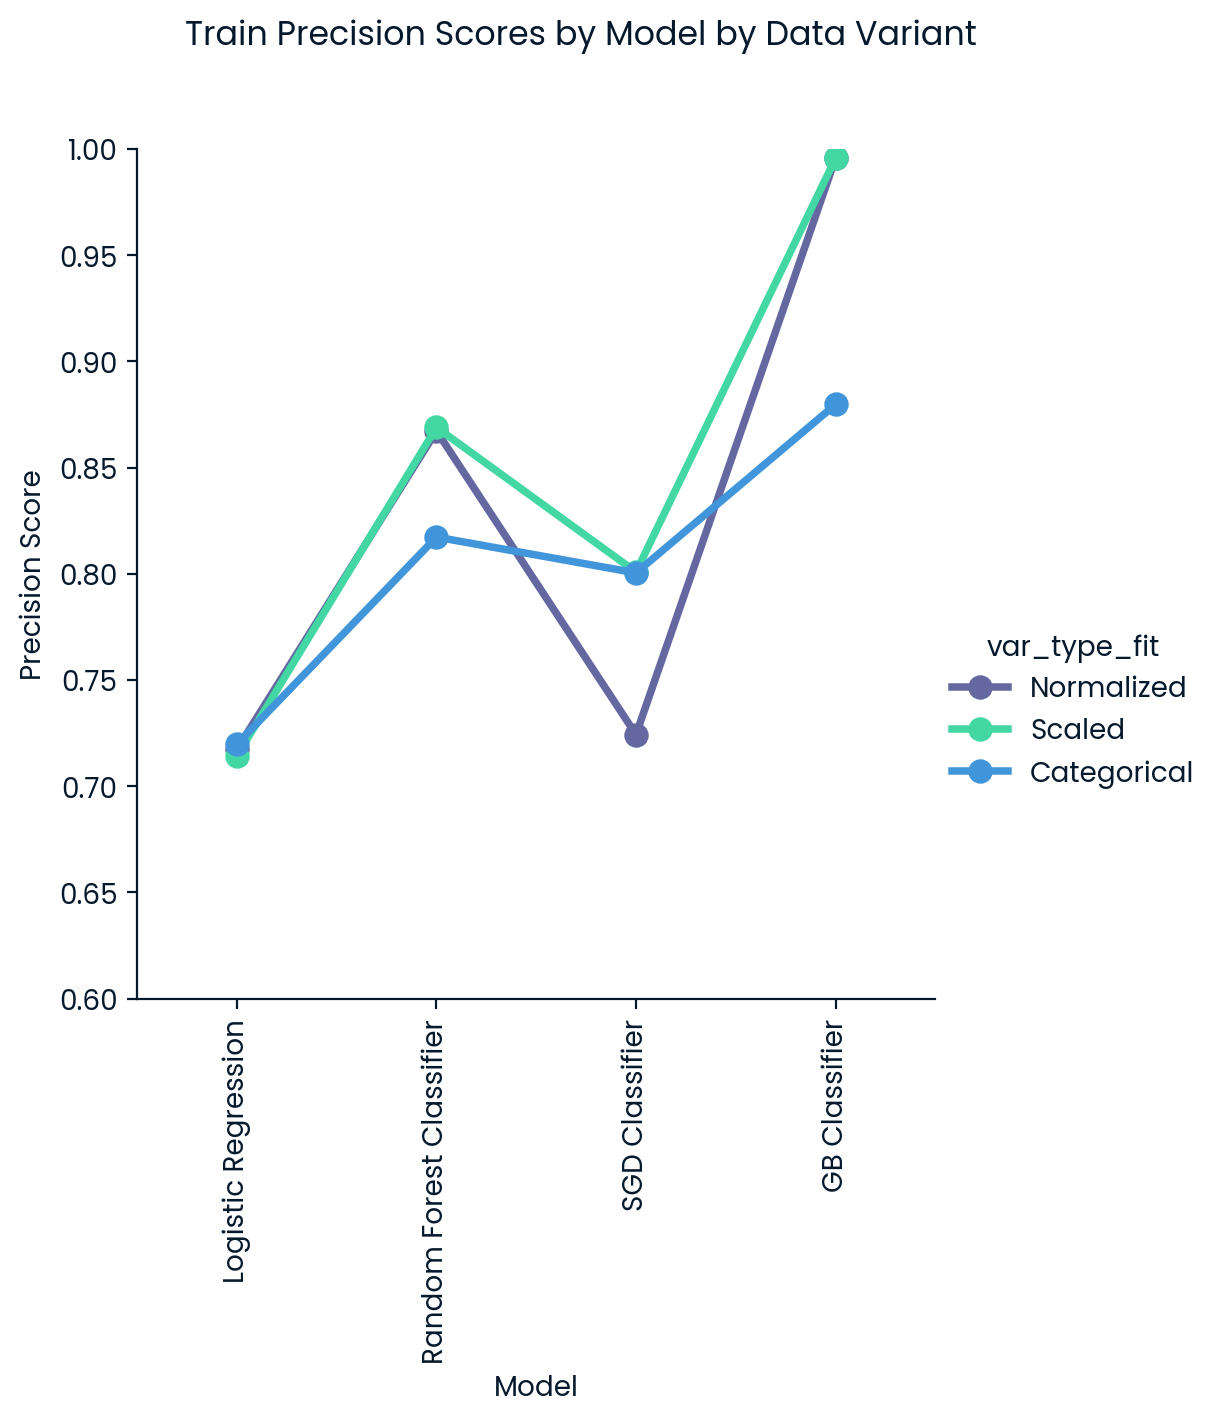

In [109]:
sns.catplot(data =pd.melt(prec_scores_train.reset_index(), id_vars = 'var_type_fit'), x = 'variable', y='value', hue = 'var_type_fit', kind ='point').set(ylim = (0.6,1), xlabel = 'Model', ylabel = 'Precision Score')
plt.xticks(rotation = 90)
plt.suptitle("Train Precision Scores by Model by Data Variant", y = 1.1)

In [110]:
prec_scores_cv = validate_model_comparsions(classifiers, [num_norm, num_scale, cat_cont], ["Normalized", "Scaled", "Categorical"],precision_score)
prec_scores_cv

Logistic Regression  ...  GB Classifier
var_type_cv                       ...               
Normalized              0.713178  ...       0.734538
Scaled                  0.711915  ...       0.733451
Categorical             0.706075  ...       0.745991

[3 rows x 4 columns]

Text(0.5, 1.1, 'Cross Validated Train Precision Scores by Model by Data Variant')

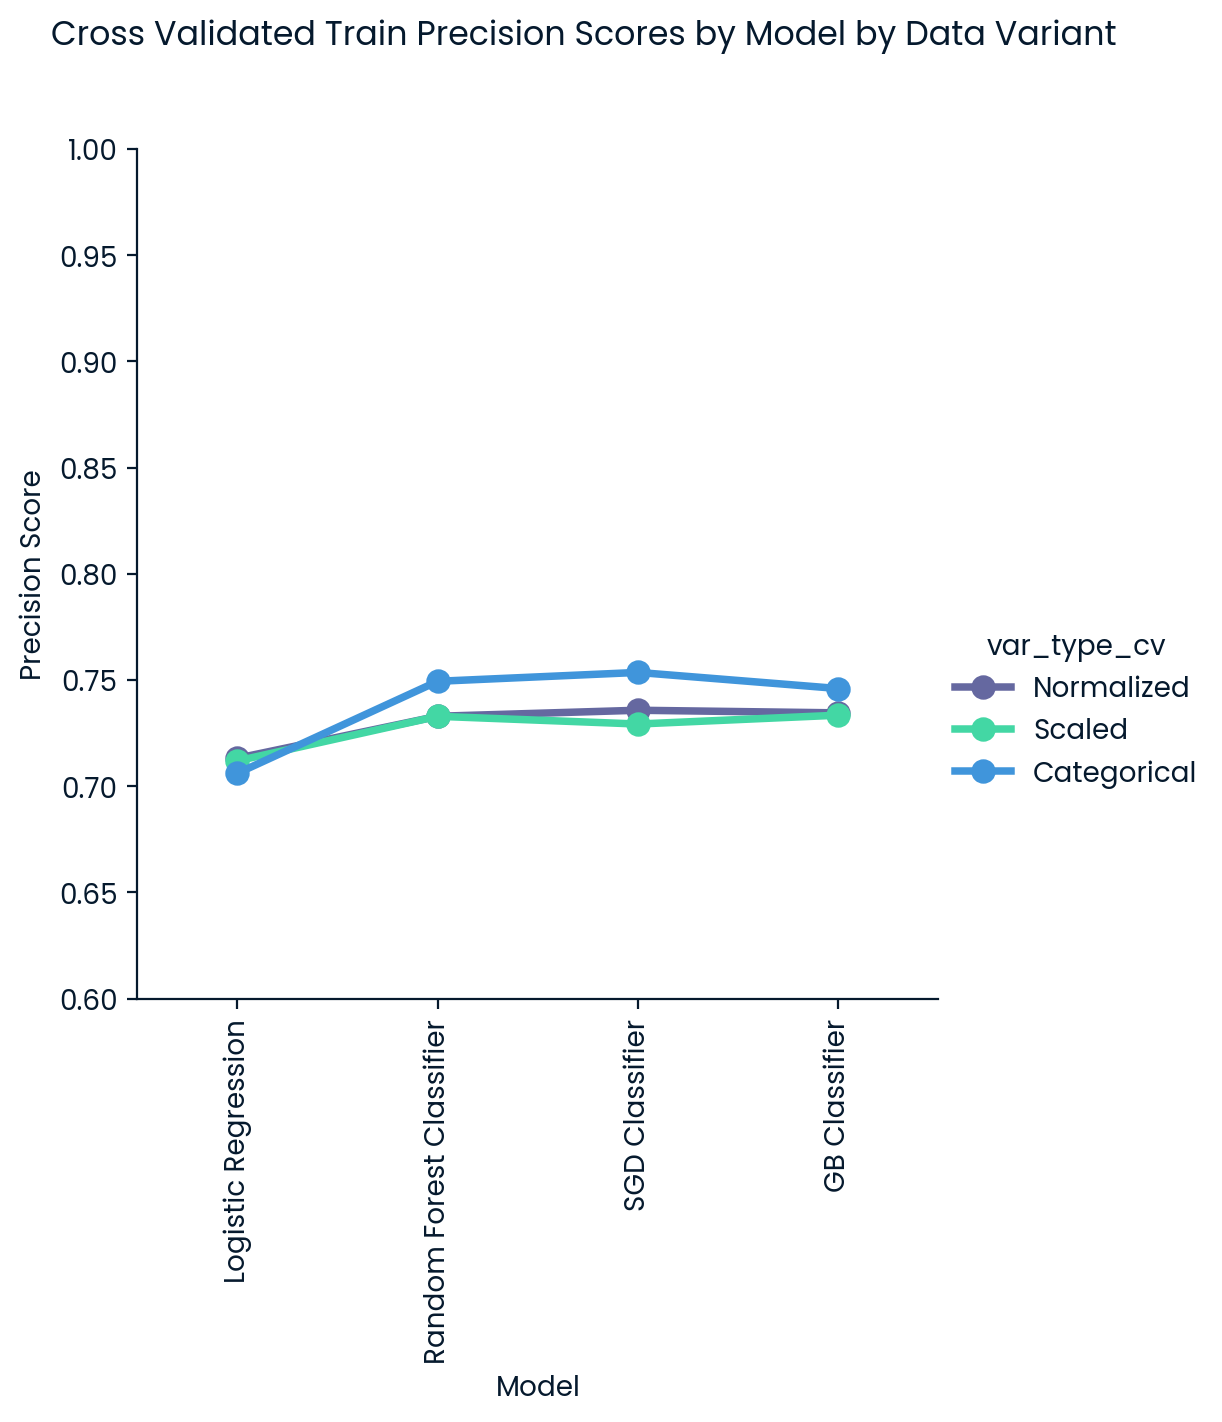

In [111]:
sns.catplot(data =pd.melt(prec_scores_cv.reset_index(), id_vars = 'var_type_cv'), x = 'variable', y='value', hue = 'var_type_cv', kind ='point').set(ylim = (0.6,1),xlabel = 'Model', ylabel = 'Precision Score')
plt.xticks(rotation = 90)
plt.suptitle("Cross Validated Train Precision Scores by Model by Data Variant", y = 1.1)

In [112]:
prec_scores_test = make_model_comparsions_test(classifiers, [num_norm, num_scale, cat_cont], ["Normalized", "Scaled", "Categorical"],precision_score)
prec_scores_test

Logistic Regression  ...  GB Classifier
var_type_test                       ...               
Normalized                0.721088  ...       0.710744
Scaled                    0.720000  ...       0.742188
Categorical               0.722973  ...       0.763780

[3 rows x 4 columns]

Text(0.5, 1.1, 'Test Precision Scores by Model by Data Variant')

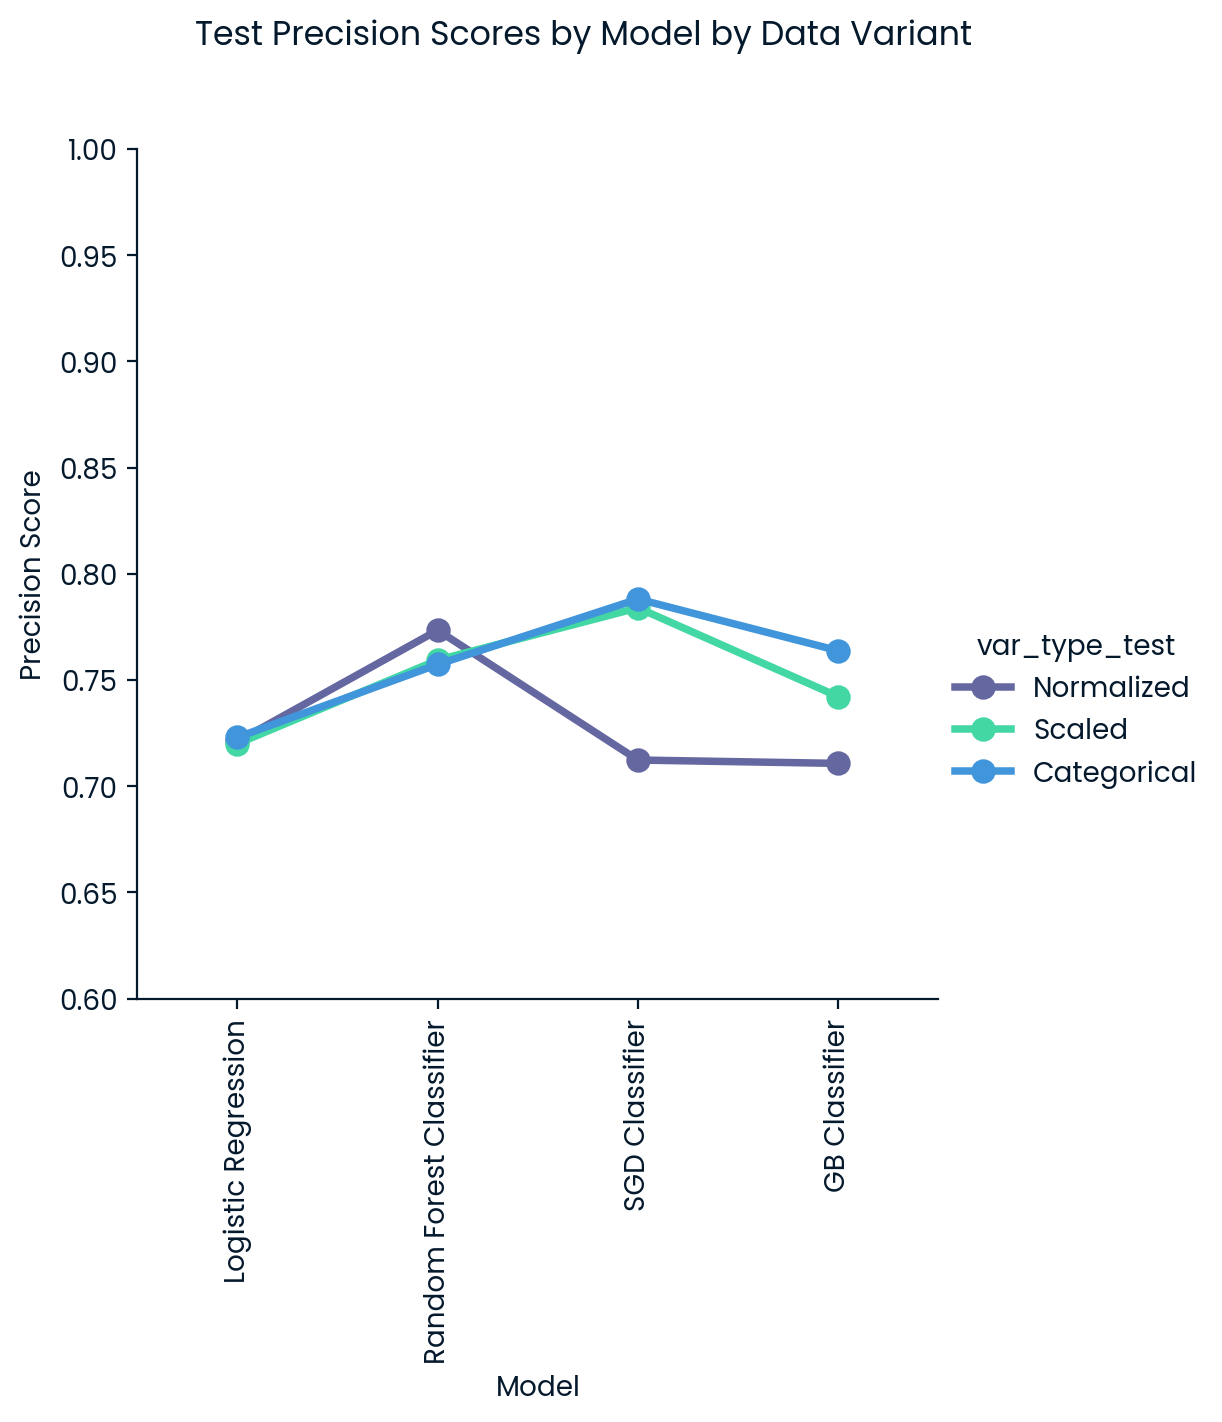

In [113]:
sns.catplot(data =pd.melt(prec_scores_test.reset_index(), id_vars = 'var_type_test'), x = 'variable', y='value', hue = 'var_type_test', kind ='point').set(ylim = (0.6,1),xlabel = 'Model', ylabel = 'Precision Score')
plt.xticks(rotation = 90)
plt.suptitle("Test Precision Scores by Model by Data Variant", y = 1.1)

### Model Evaluation: Accuracy Score

- When fitted for all the features of a variant dataset we can see that the categorical data set has the most consistent results, producing not only the smallest difference between train, validate and test scores but also highest validate and test scores.
- The SGD Classifier fitted with the scaled data set gives the highest test accuracy score of 0.768.
- The categorical data set test accuracy scores are pretty comparable for all models except the logistic regression model.
- The results suggest that the categorical data might be a better fit when including all features of the data set.


In [114]:
acc_scores_train = make_model_comparsions_train(classifiers, [num_norm, num_scale, cat_cont], ["Normalized", "Scaled", "Categorical"],accuracy_score)
acc_scores_train

Logistic Regression  ...  GB Classifier
var_type_fit                       ...               
Normalized               0.737120  ...       0.997358
Scaled                   0.734478  ...       0.997358
Categorical              0.739762  ...       0.869221

[3 rows x 4 columns]

Text(0.5, 1.1, 'Train Accuracy Scores by Model by Data Variant')

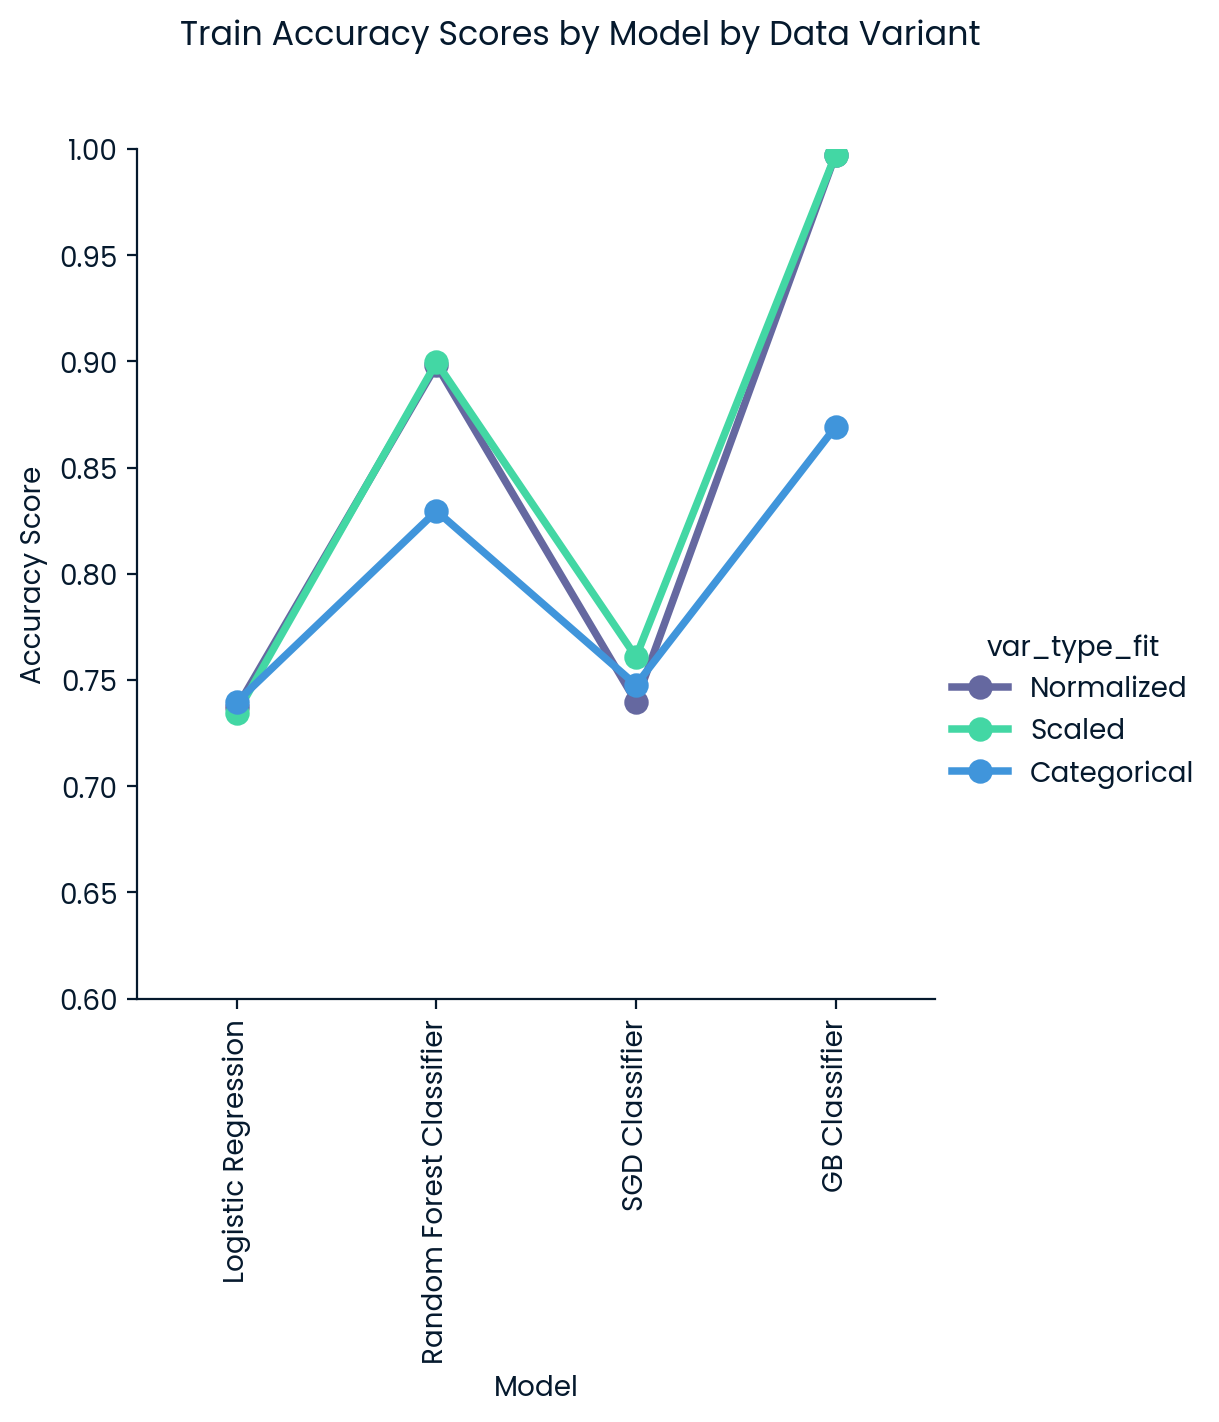

In [115]:
sns.catplot(data =pd.melt(acc_scores_train.reset_index(), id_vars = 'var_type_fit'), x = 'variable', y='value', hue = 'var_type_fit', kind ='point').set(ylim = (0.6,1),xlabel = 'Model', ylabel = 'Accuracy Score')
plt.xticks(rotation = 90)
plt.suptitle("Train Accuracy Scores by Model by Data Variant", y = 1.1)

In [116]:
acc_scores_cv = validate_model_comparsions(classifiers, [num_norm, num_scale, cat_cont], ["Normalized", "Scaled", "Categorical"],accuracy_score)
acc_scores_cv

Logistic Regression  ...  GB Classifier
var_type_cv                       ...               
Normalized              0.730516  ...       0.705429
Scaled                  0.733165  ...       0.702797
Categorical             0.721270  ...       0.700131

[3 rows x 4 columns]

Text(0.5, 1.1, 'Cross Validated Train Accuracy Scores by Model by Data Variant')

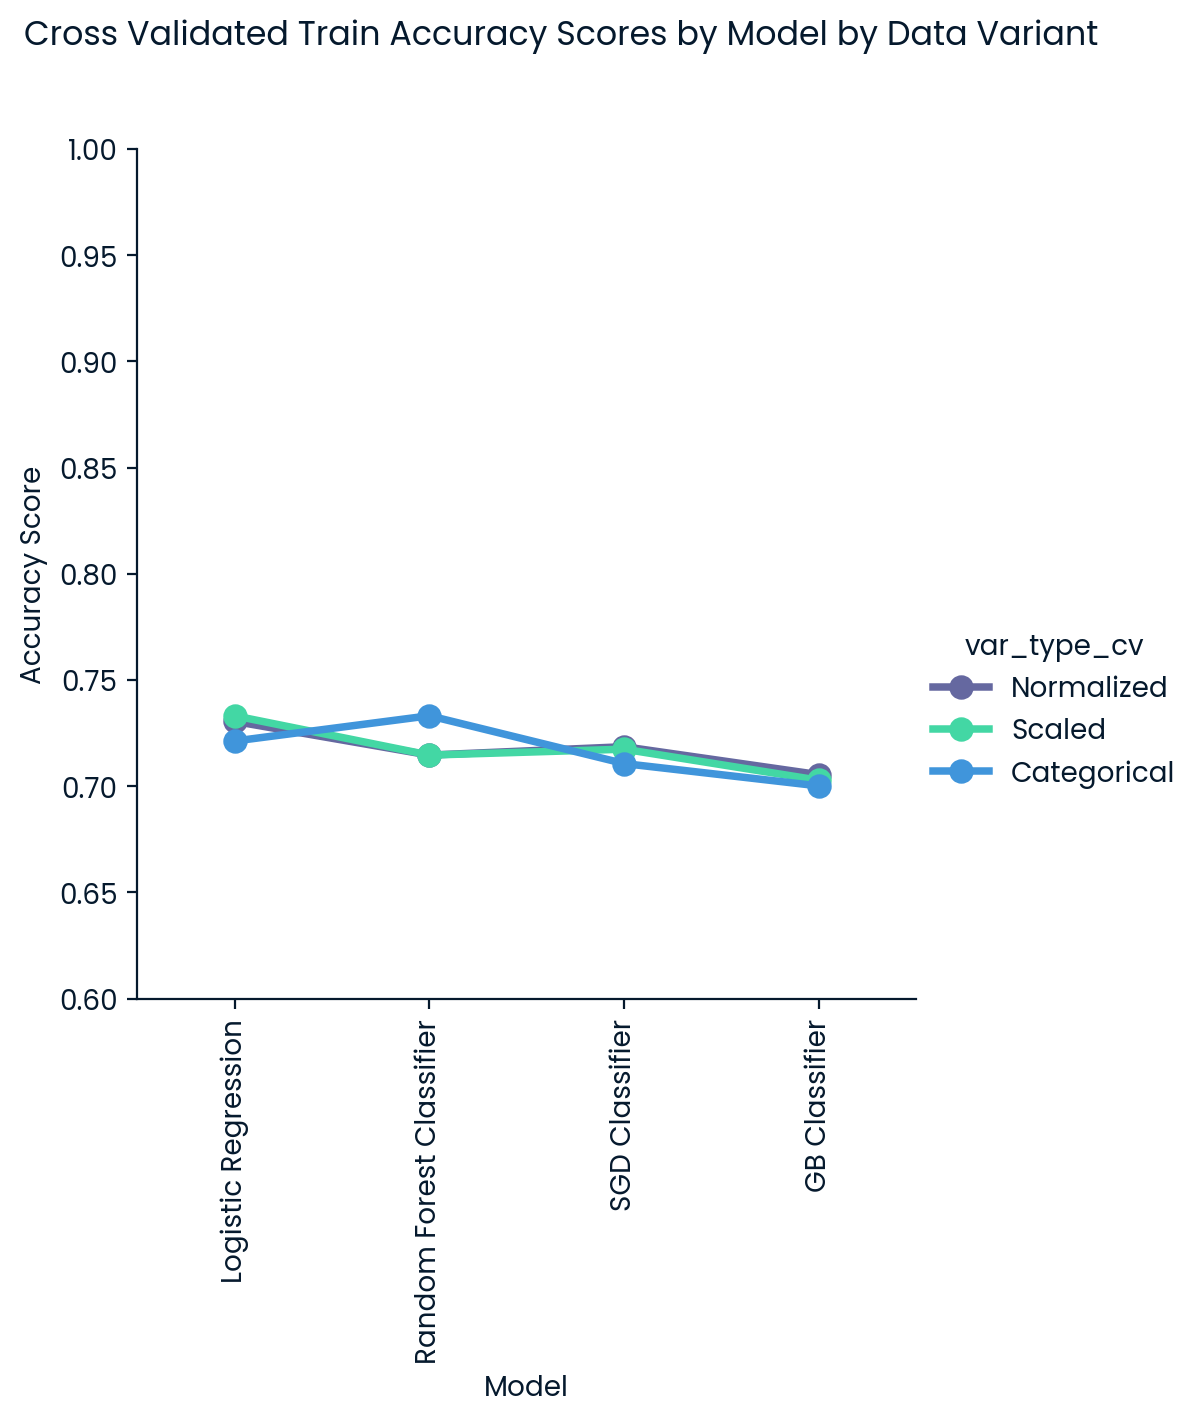

In [117]:
sns.catplot(data =pd.melt(acc_scores_cv.reset_index(), id_vars = 'var_type_cv'), x = 'variable', y='value', hue = 'var_type_cv', kind ='point').set(ylim = (0.6,1),xlabel = 'Model', ylabel = 'Accuracy Score', alpha = .5)
plt.xticks(rotation = 90)
plt.suptitle("Cross Validated Train Accuracy Scores by Model by Data Variant", y = 1.1)

In [118]:
acc_scores_test = make_model_comparsions_test(classifiers, [num_norm, num_scale, cat_cont], ["Normalized", "Scaled", "Categorical"],accuracy_score)
acc_scores_test

Logistic Regression  ...  GB Classifier
var_type_test                       ...               
Normalized                0.736842  ...       0.663158
Scaled                    0.742105  ...       0.721053
Categorical               0.742105  ...       0.747368

[3 rows x 4 columns]

Text(0.5, 1.1, 'Test Accuracy Scores by Model by Data Variant')

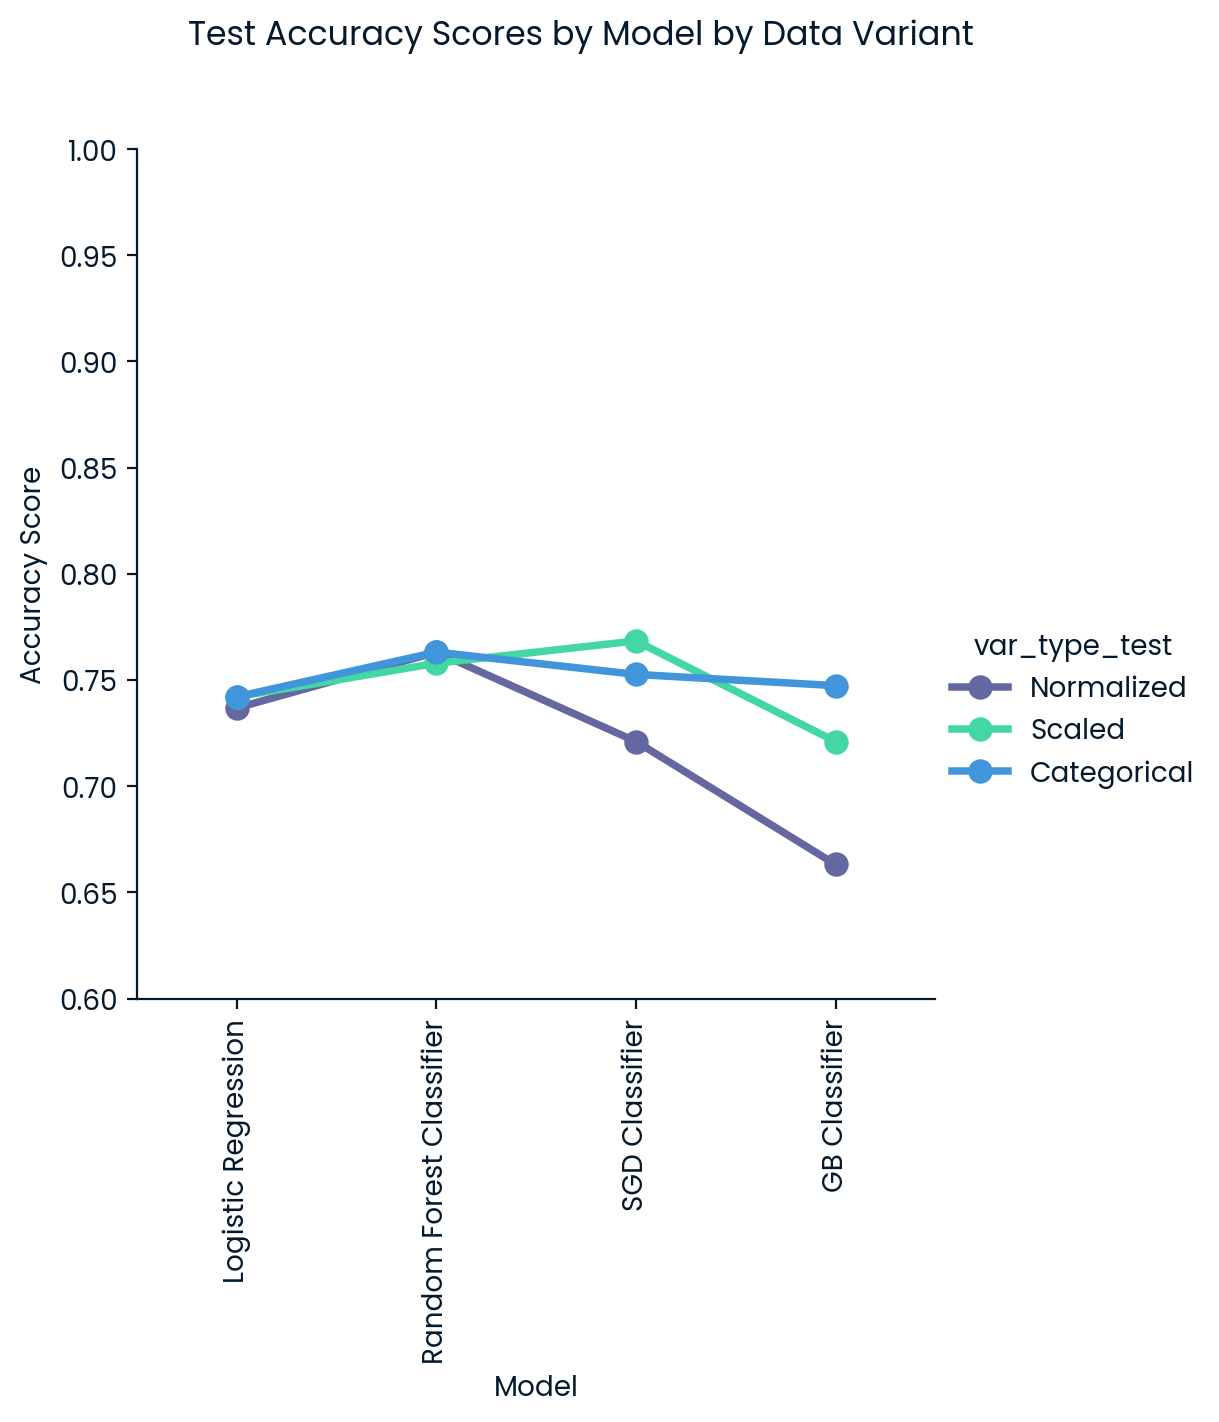

In [119]:
sns.catplot(data =pd.melt(acc_scores_test.reset_index(), id_vars = 'var_type_test'), x = 'variable', y='value', hue = 'var_type_test', kind ='point').set(ylim = (0.6,1),xlabel = 'Model', ylabel = 'Accuracy Score')
plt.xticks(rotation = 90)
plt.suptitle("Test Accuracy Scores by Model by Data Variant", y =1.1)

### Model Evaluation: Feature Selection

- Recursive feature elimination across the 3 data sets shows that the optimal number of features to include is between 4 and 7 .
- The categorical data set produced the most models with a test precision score over 0.8 (11 models) using the least number of features, resulting from all non linear models.
- The scaled data set did not produce any test precision scores over 0.8 .
- SGD Classifier was the only model that produced a test precision score of over 0.8 using the Normalized data set.
- Thus the models included for final consideration will be the 
    1) Normalized SGD Classifier 
    2) Categorical GB Classifier 
    3) Categorical  Random Forest Classifier 


In [120]:
def make_model_comparsions_score(classifiers, cols, metrics, feat_num):
    def make_model_comparsions_score_inner(model, cols, metric, feat_num):    
        scores = {}
        X_train_subset = X_train_clean.loc[:,cols]
        X_test_subset = X_test_clean.loc[:,cols]
        rfe = RFE(estimator= model[1], n_features_to_select =feat_num)
        scores['model'] = model[0]
        scores['metric'] =metric.__name__
        model_sub = rfe.fit( X_train_subset, y_train)
        scores['score'] = metric( y_test, model_sub.predict(X_test_subset))
        scores['feature_num'] = feat_num
        features = {k:v for k,v in zip(model_sub.feature_names_in_,model_sub.ranking_)}
        top_features= [key for key, value in features.items() if value == 1]
        scores['top_features'] = ''
        model_comp = pd.DataFrame(scores, index = [0])  
        model_comp.at[0,'top_features'] = top_features
   
        return model_comp

    fin = pd.DataFrame()
    for model in classifiers:
        for metric in metrics:
            fin = fin.append(make_model_comparsions_score_inner(model, cols, metric, feat_num))
    return fin
                

In [121]:
def best_feature_num(classifiers, cols, metrics,start,end):
    nums = np.arange(start,end)
    fin = pd.DataFrame()
    
    for i in nums:
        fin = fin.append(make_model_comparsions_score(classifiers, cols, metrics, i))
        
    return fin

In [122]:
best_feat_cat_cont = best_feature_num(classifiers, cat_cont, [precision_score, accuracy_score],4,11)

Text(0.5, 1.1, 'Test Precision Scores by Model and Number of Features for Categorical Data Set ')

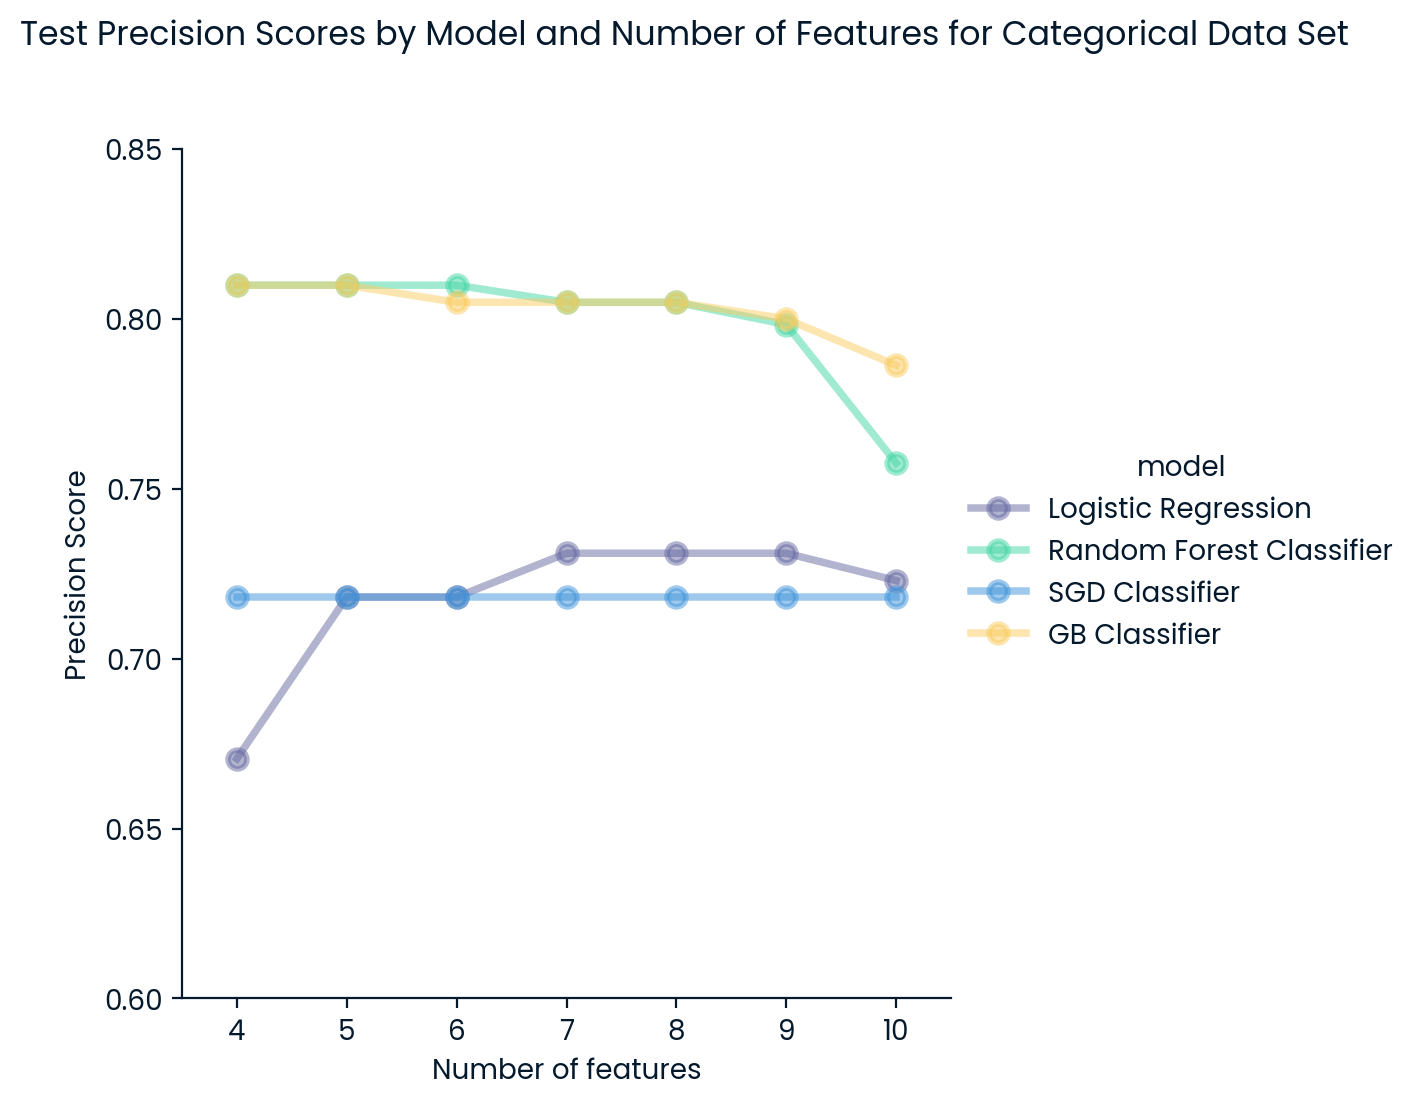

In [123]:
sns.catplot(best_feat_cat_cont[best_feat_cat_cont.metric == 'precision_score'], x= 'feature_num', y = 'score', hue = 'model', kind = 'point', alpha =.5).set(ylim = (0.6,.85),xlabel = 'Number of features', ylabel = 'Precision Score')
plt.suptitle("Test Precision Scores by Model and Number of Features for Categorical Data Set ", y =1.1)

In [124]:
# filter cat data for scores over .8
best_cats = best_feat_cat_cont[best_feat_cat_cont.score >= .8]
best_cats

model  ...                                       top_features
0  Random Forest Classifier  ...  [category_Beverages, category_Breakfast, categ...
0             GB Classifier  ...  [category_Beverages, category_Breakfast, categ...
0  Random Forest Classifier  ...  [category_Beverages, category_Breakfast, categ...
0             GB Classifier  ...  [category_Beverages, category_Breakfast, categ...
0  Random Forest Classifier  ...  [category_Beverages, category_Breakfast, categ...
0             GB Classifier  ...  [category_Beverages, category_Breakfast, categ...
0  Random Forest Classifier  ...  [category_Beverages, category_Breakfast, categ...
0             GB Classifier  ...  [category_Beverages, category_Breakfast, categ...
0  Random Forest Classifier  ...  [category_Beverages, category_Breakfast, categ...
0             GB Classifier  ...  [category_Beverages, category_Breakfast, categ...
0             GB Classifier  ...  [category_Beverages, category_Breakfast, categ...

[11 rows x 5 columns]

In [125]:
best_feat_scale_cont = best_feature_num(classifiers, num_scale, [precision_score, accuracy_score],4,11)

Text(0.5, 1.1, 'Test Precision Scores by Model and Number of Features for Scaled Data Set ')

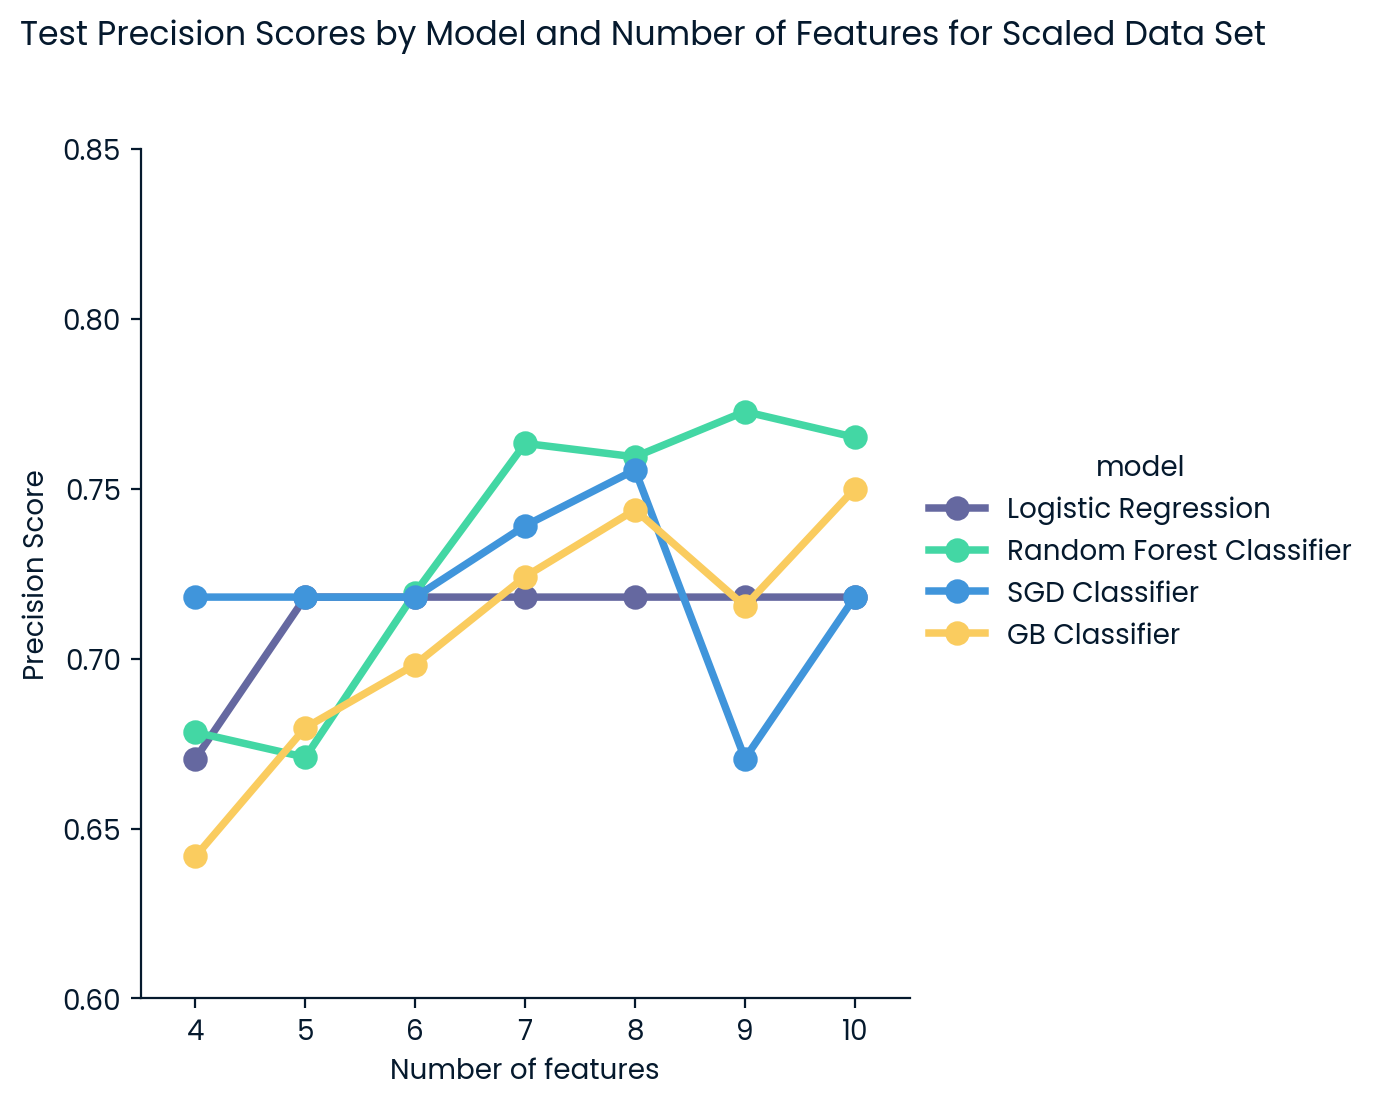

In [126]:
sns.catplot(best_feat_scale_cont[best_feat_scale_cont.metric == 'precision_score'], x= 'feature_num', y = 'score', hue = 'model', kind = 'point').set(ylim = (0.6,.85),xlabel = 'Number of features', ylabel = 'Precision Score')
plt.suptitle("Test Precision Scores by Model and Number of Features for Scaled Data Set ", y =1.1)

In [127]:
# filter scaled data for scores over .8
best_scale = best_feat_scale_cont[best_feat_scale_cont.score >= .8]
best_scale

Empty DataFrame
Columns: [model, metric, score, feature_num, top_features]
Index: []

In [128]:
best_feat_norm_cont = best_feature_num(classifiers, num_norm, [precision_score, accuracy_score],4,11)

Text(0.5, 1.1, 'Test Precision Scores by Model and Number of Features for Normalized Data Set ')

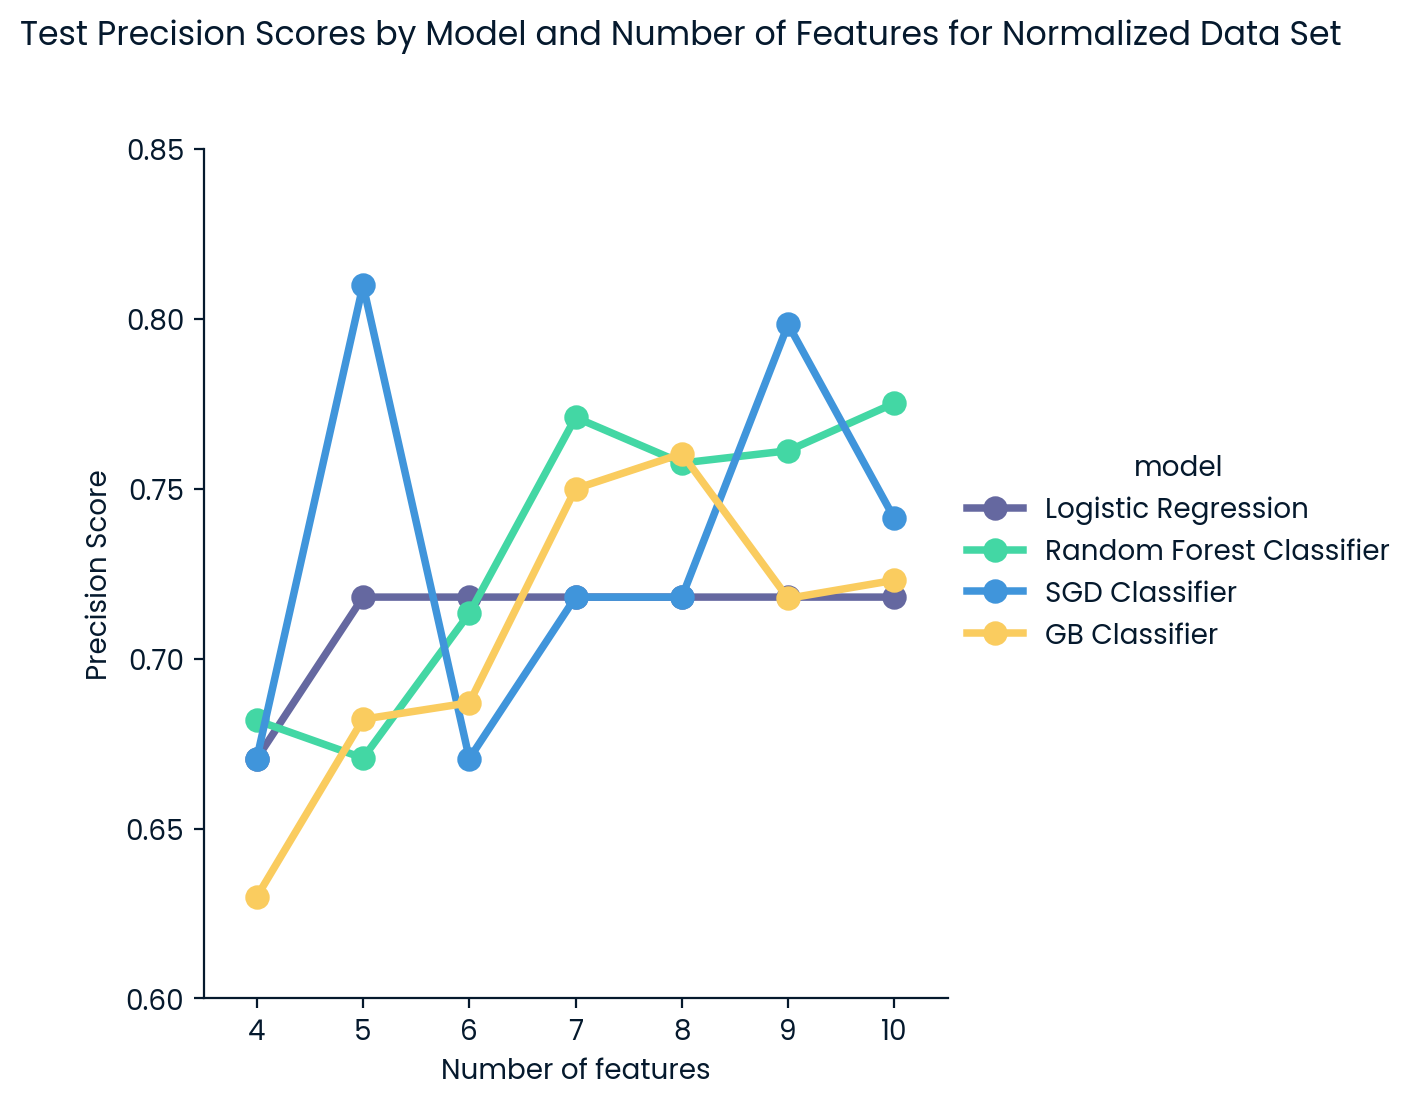

In [129]:
sns.catplot(best_feat_norm_cont[best_feat_norm_cont.metric == 'precision_score'], x= 'feature_num', y = 'score', hue = 'model', kind = 'point').set(ylim = (0.6,.85),xlabel = 'Number of features', ylabel = 'Precision Score')
plt.suptitle("Test Precision Scores by Model and Number of Features for Normalized Data Set ", y =1.1)

In [130]:
# filter normalized data for scores over .8
best_norm = best_feat_norm_cont[best_feat_norm_cont.score >=.8]
best_norm

model  ...                                       top_features
0  SGD Classifier  ...  [category_Beverages, category_Breakfast, categ...

[1 rows x 5 columns]

- When comparing the final models fitted for all features we can see that there is a preference for the category in decision making since the top 3 features for all models are category. 

GB Classifier Model with Categorical Var Group has Precision score of 0.76


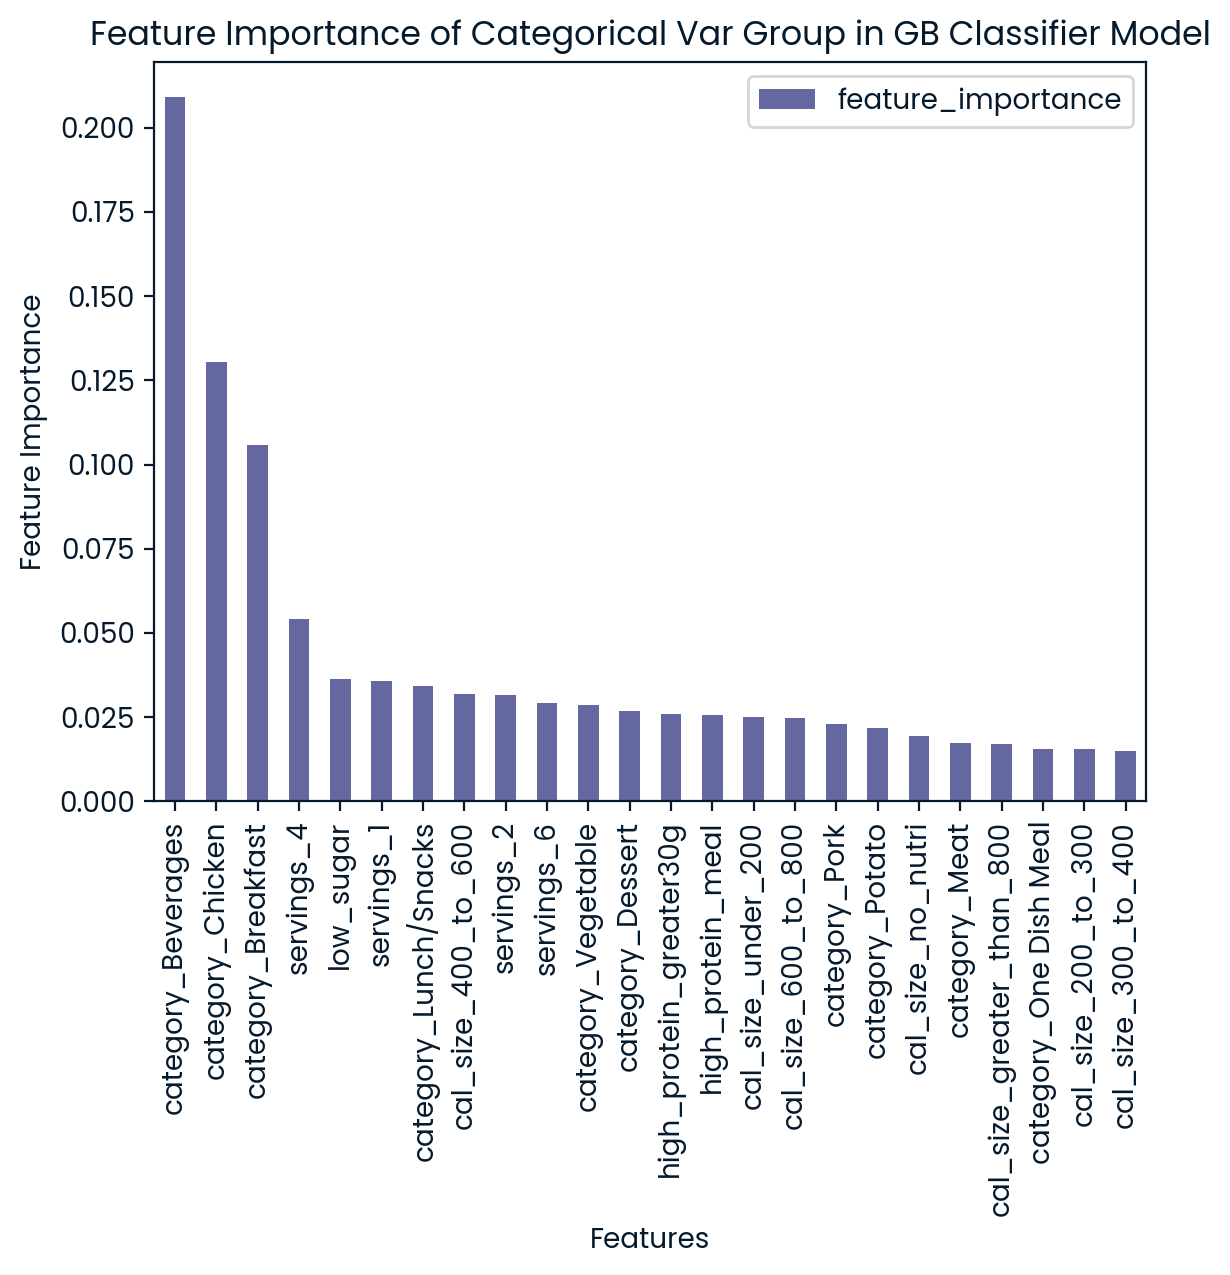

In [131]:
compare_models_graphs( classifiers[3],cat_cont, "Categorical")

Random Forest Classifier Model with Categorical Var Group has Precision score of 0.76


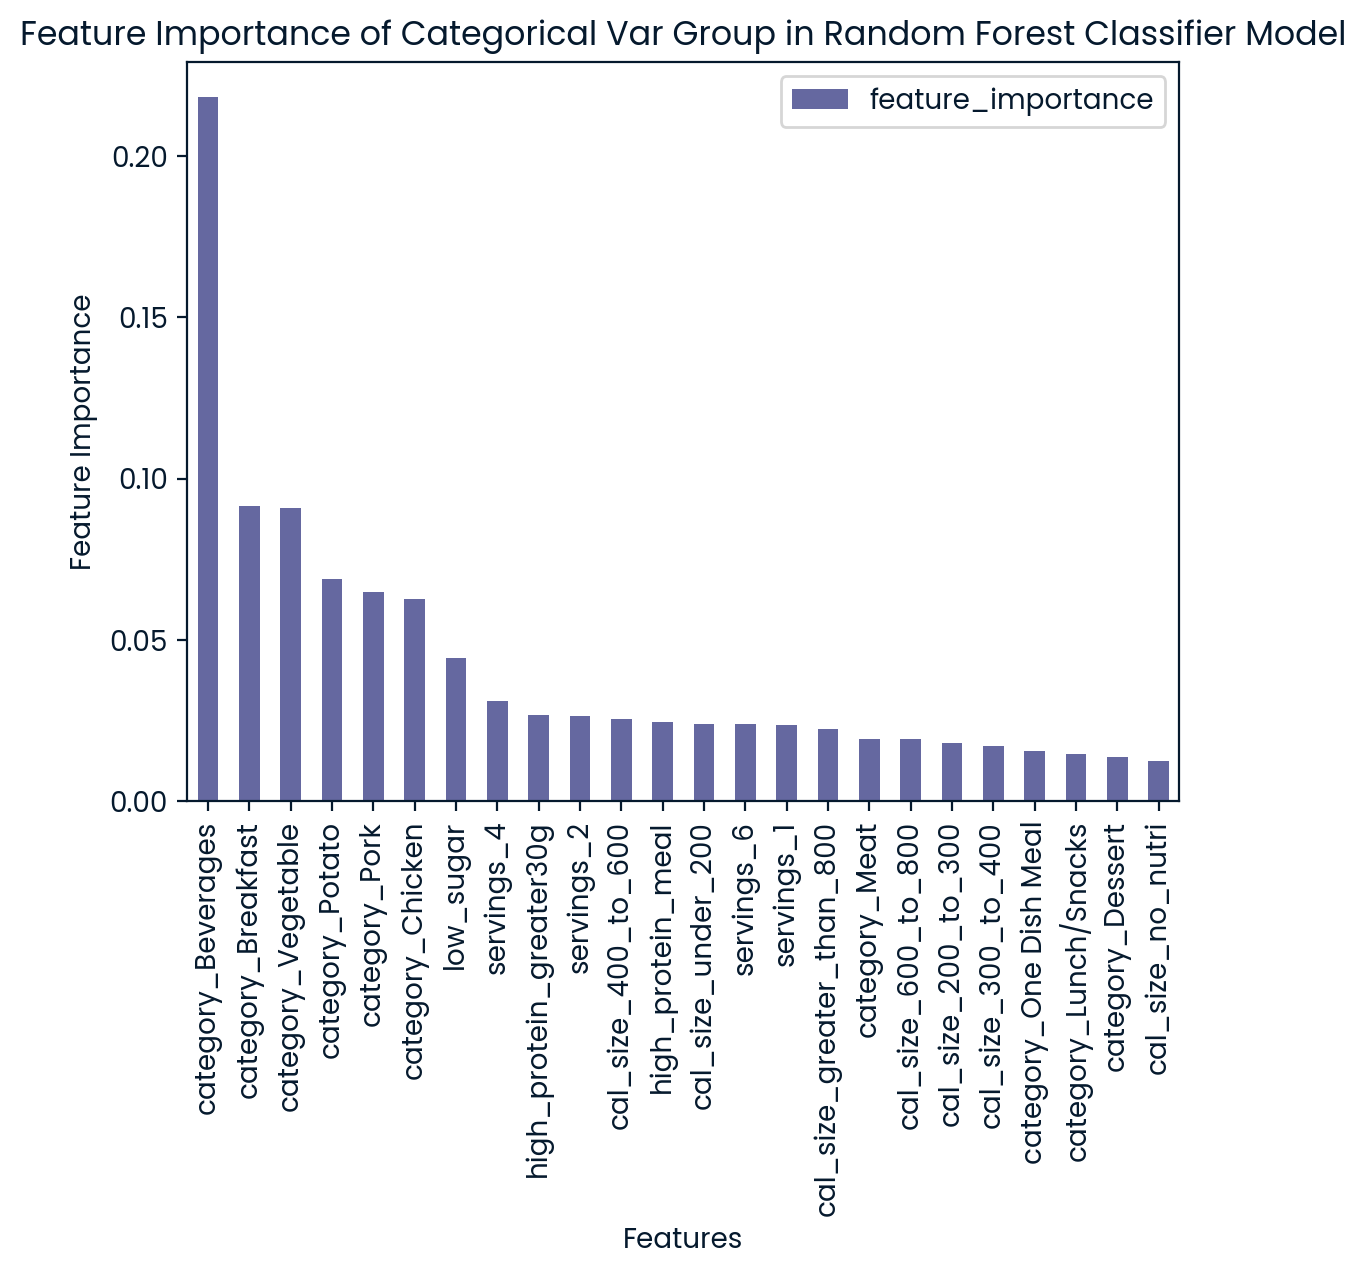

In [132]:
compare_models_graphs( classifiers[1],cat_cont, "Categorical")

SGD Classifier Model with Normalized Var Group has Precision score of 0.71


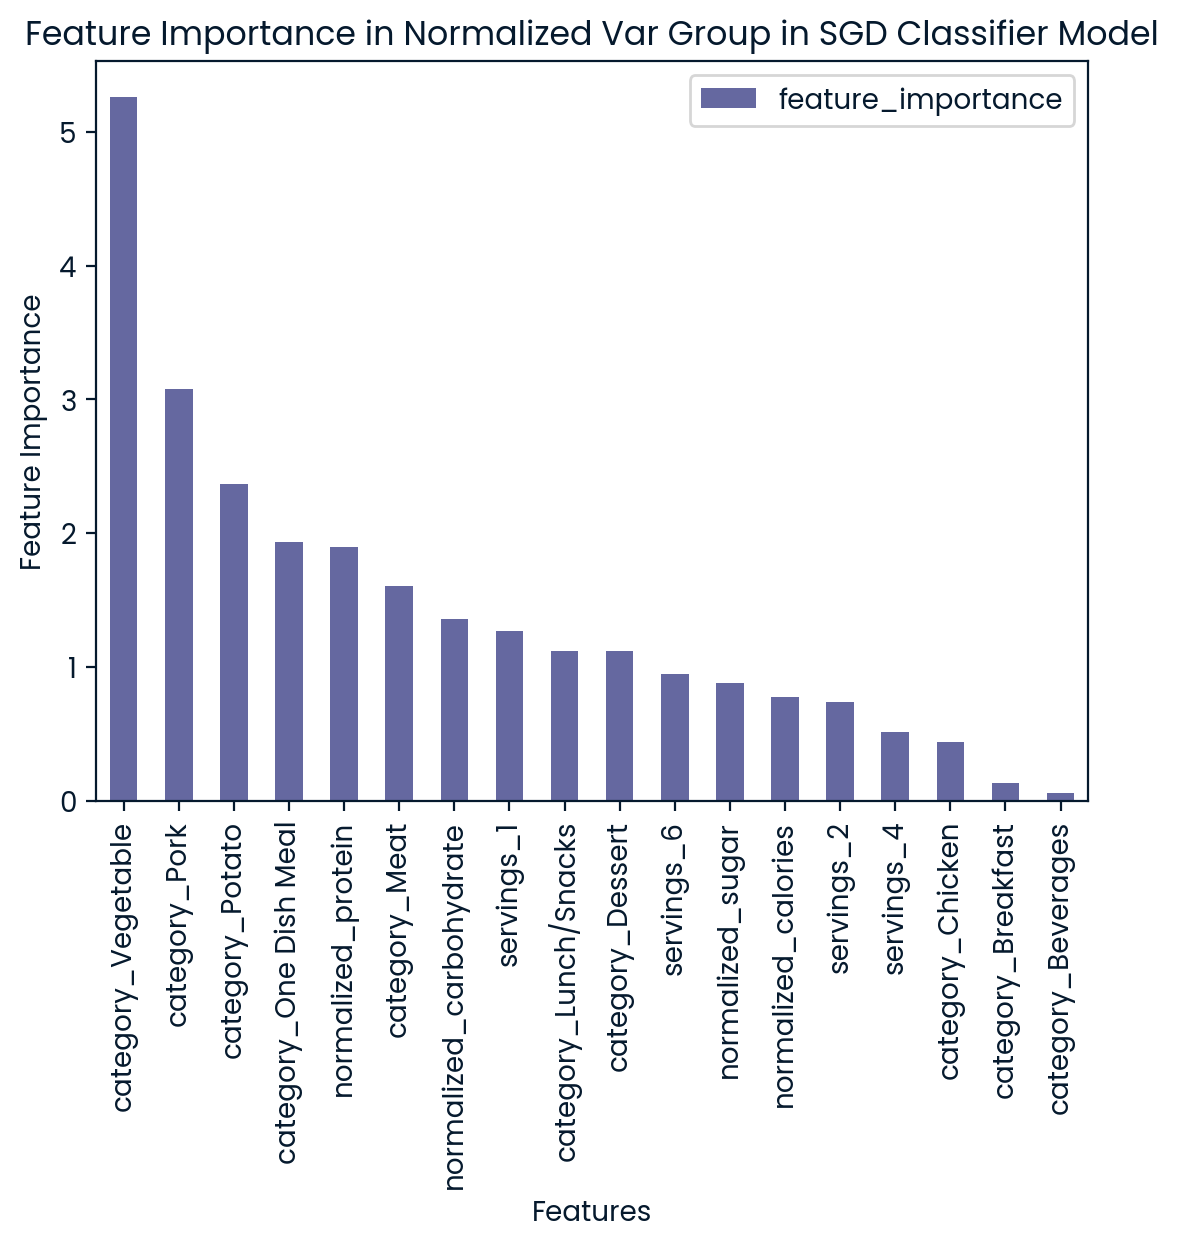

In [133]:
compare_models_graphs( classifiers[2], num_norm, "Normalized")

In [134]:
best_norm[['feature_num','model','top_features']]

feature_num  ...                                       top_features
0            5  ...  [category_Beverages, category_Breakfast, categ...

[1 rows x 3 columns]

In [135]:

best_cats[np.logical_and(best_cats.feature_num <=6, best_cats.metric == 'precision_score')][['model','top_features']]

model                                       top_features
0  Random Forest Classifier  [category_Beverages, category_Breakfast, categ...
0             GB Classifier  [category_Beverages, category_Breakfast, categ...
0  Random Forest Classifier  [category_Beverages, category_Breakfast, categ...
0             GB Classifier  [category_Beverages, category_Breakfast, categ...
0  Random Forest Classifier  [category_Beverages, category_Breakfast, categ...
0             GB Classifier  [category_Beverages, category_Breakfast, categ...

- The results suggest that the easiest way to discern traffic volume status is using chicken, breakfast, beverages, and vegetable, since all 4 categories appear in all model variants.
- These findings are congruent with the results of the statistical tests conducted during exploratory data analysis which showed that category would impact traffic volume but the impact of the nutritional info might not be as strong because although high traffic recipes were associated with higher macronutrient levels the meaningful thresholds we set (informed by our research) were not.


In [136]:
best_vars_7 = ["category_Beverages","category_Breakfast","category_Chicken","category_Pork","category_Vegetable","cal_size_400_to_600", "category_Potato"]
best_vars_6 = ["category_Beverages","category_Breakfast","category_Chicken","category_Pork","category_Vegetable", "category_Potato"]
best_vars_5_pork = ["category_Beverages","category_Breakfast","category_Chicken","category_Pork","category_Vegetable"]
best_vars_5_potato = ["category_Beverages","category_Breakfast","category_Chicken","category_Potato","category_Vegetable"]
best_vars_4 = ["category_Beverages","category_Breakfast","category_Chicken","category_Vegetable"]

- Based on the results of the RFE we have selected and refitted all 4 models for one final comparison
- GB Classifier and Random Forest Classifier are the most robust models, producing the highest test precision score regardless of features. 
- The results also suggest that Pork could be more helpful than potato as an additional feature since the SGD Classifier performs better with it included.

In [137]:
best_vars_train= make_model_comparsions_train(classifiers, [best_vars_7,best_vars_6, best_vars_5_pork, best_vars_5_potato, best_vars_4], ['best_vars_7','best_vars_6', 'best_vars_5_pork', 'best_vars_5_potato', 'best_vars_4'],precision_score)
best_vars_train

Logistic Regression  ...  GB Classifier
var_type_fit                             ...               
best_vars_7                       0.715  ...       0.789256
best_vars_6                       0.715  ...       0.800439
best_vars_5_pork                  0.715  ...       0.800439
best_vars_5_potato                0.715  ...       0.800439
best_vars_4                       0.715  ...       0.800439

[5 rows x 4 columns]

In [138]:
best_vars_cv= validate_model_comparsions(classifiers, [best_vars_7,best_vars_6, best_vars_5_pork, best_vars_5_potato, best_vars_4], ['best_vars_7','best_vars_6', 'best_vars_5_pork', 'best_vars_5_potato', 'best_vars_4'],precision_score)
best_vars_cv

Logistic Regression  ...  GB Classifier
var_type_cv                              ...               
best_vars_7                     0.71537  ...       0.793179
best_vars_6                     0.71537  ...       0.803753
best_vars_5_pork                0.71537  ...       0.803753
best_vars_5_potato              0.71537  ...       0.803753
best_vars_4                     0.71537  ...       0.803753

[5 rows x 4 columns]

In [139]:
best_vars_test= make_model_comparsions_test(classifiers, [best_vars_7,best_vars_6, best_vars_5_pork, best_vars_5_potato, best_vars_4], ['best_vars_7','best_vars_6', 'best_vars_5_pork', 'best_vars_5_potato', 'best_vars_4'],precision_score)
best_vars_test

Logistic Regression  ...  GB Classifier
var_type_test                            ...               
best_vars_7                    0.718121  ...       0.804878
best_vars_6                    0.718121  ...       0.809917
best_vars_5_pork               0.718121  ...       0.809917
best_vars_5_potato             0.718121  ...       0.809917
best_vars_4                    0.718121  ...       0.809917

[5 rows x 4 columns]

- For the final model I have chosen the GB Classifier since all the top performing features are categorical, and the drop off for test precision score as number of features increases is less steep than second best model.  
- It is interesting that the primary method of class distinction is by using categories with the highest proportion of low traffic volume


Text(0.5, 1.1, 'Test Precision Scores by Model by Final Data Variants')

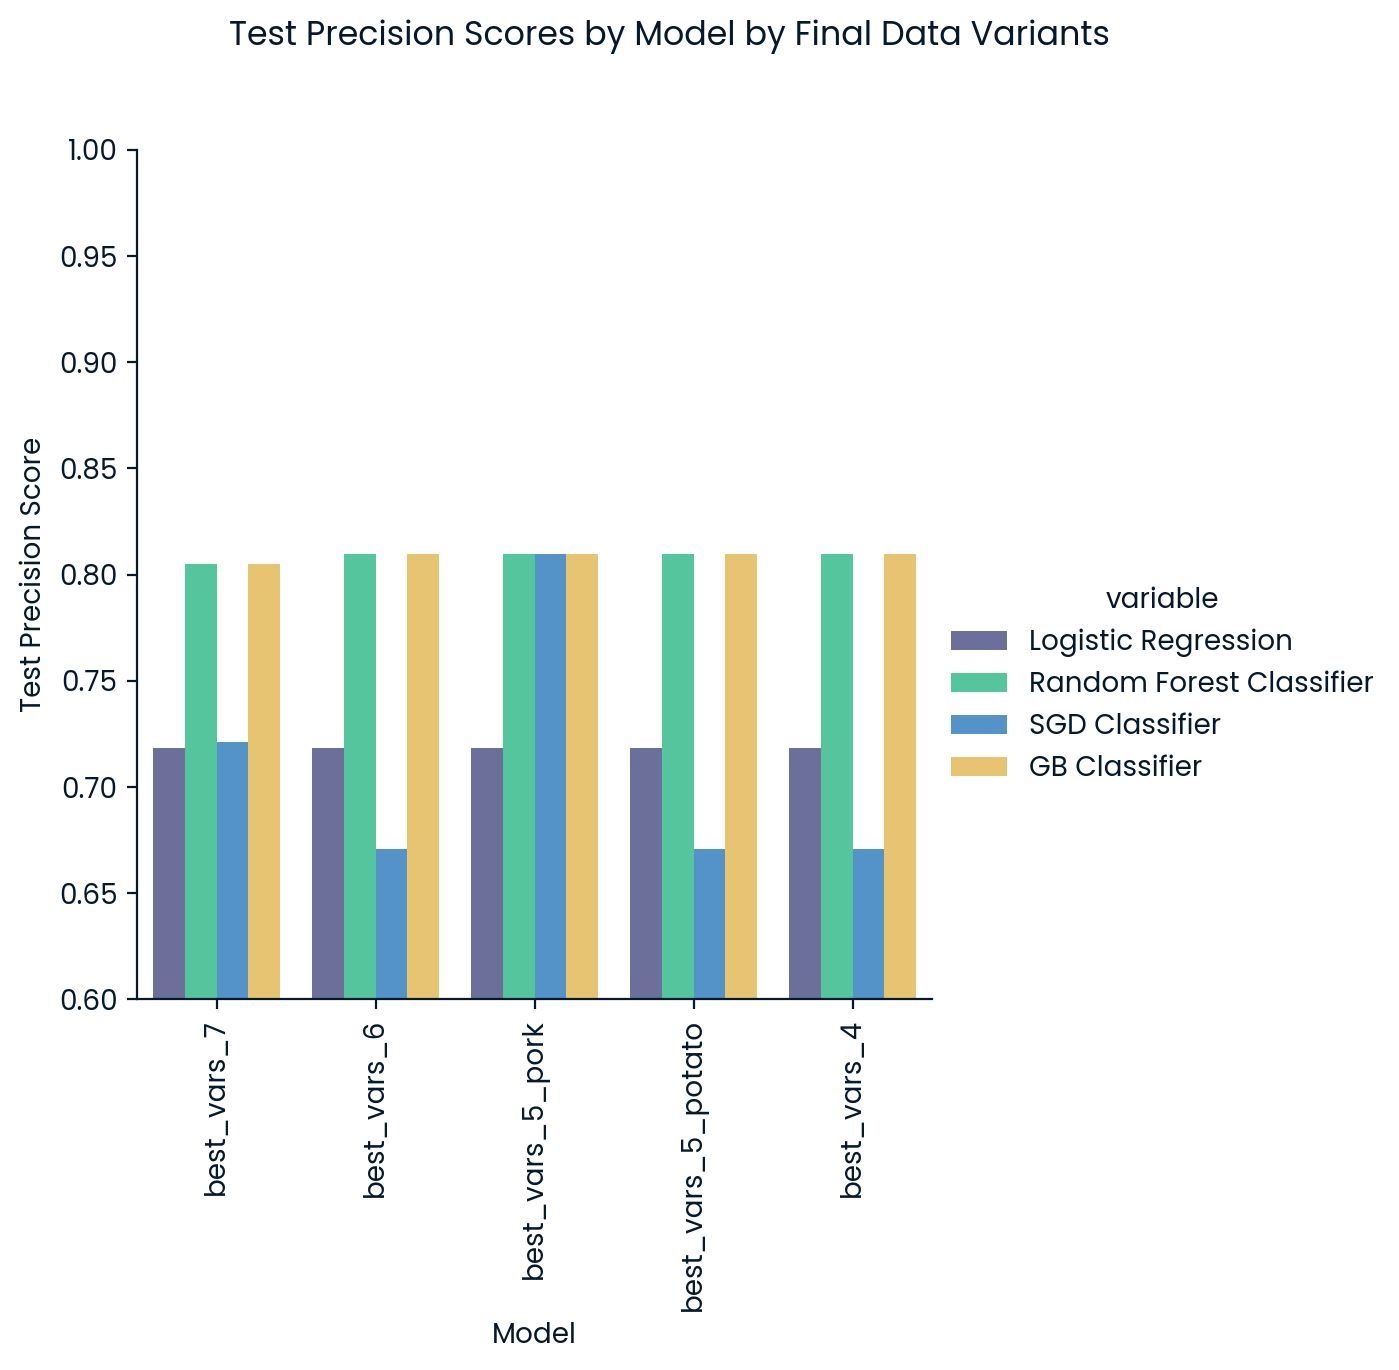

In [140]:
sns.catplot(data =pd.melt(best_vars_test.reset_index(), id_vars = 'var_type_test'), x = 'var_type_test', y='value', hue = 'variable', kind ='bar').set(ylim = (0.6,1),xlabel = 'Model', ylabel = 'Test Precision Score', alpha = .2)
plt.xticks(rotation = 90)
plt.suptitle("Test Precision Scores by Model by Final Data Variants", y = 1.1)

In [141]:
best_vars_test_acc= make_model_comparsions_test(classifiers, [best_vars_7,best_vars_6, best_vars_5_pork, best_vars_5_potato, best_vars_4], ['best_vars_7','best_vars_6', 'best_vars_5_pork', 'best_vars_5_potato', 'best_vars_4'],accuracy_score)
best_vars_test_acc

Logistic Regression  ...  GB Classifier
var_type_test                            ...               
best_vars_7                    0.736842  ...       0.789474
best_vars_6                    0.736842  ...       0.789474
best_vars_5_pork               0.736842  ...       0.789474
best_vars_5_potato             0.736842  ...       0.789474
best_vars_4                    0.736842  ...       0.789474

[5 rows x 4 columns]

Text(0.5, 1.1, 'Test Accuracy Scores by Model by Final Data Variants')

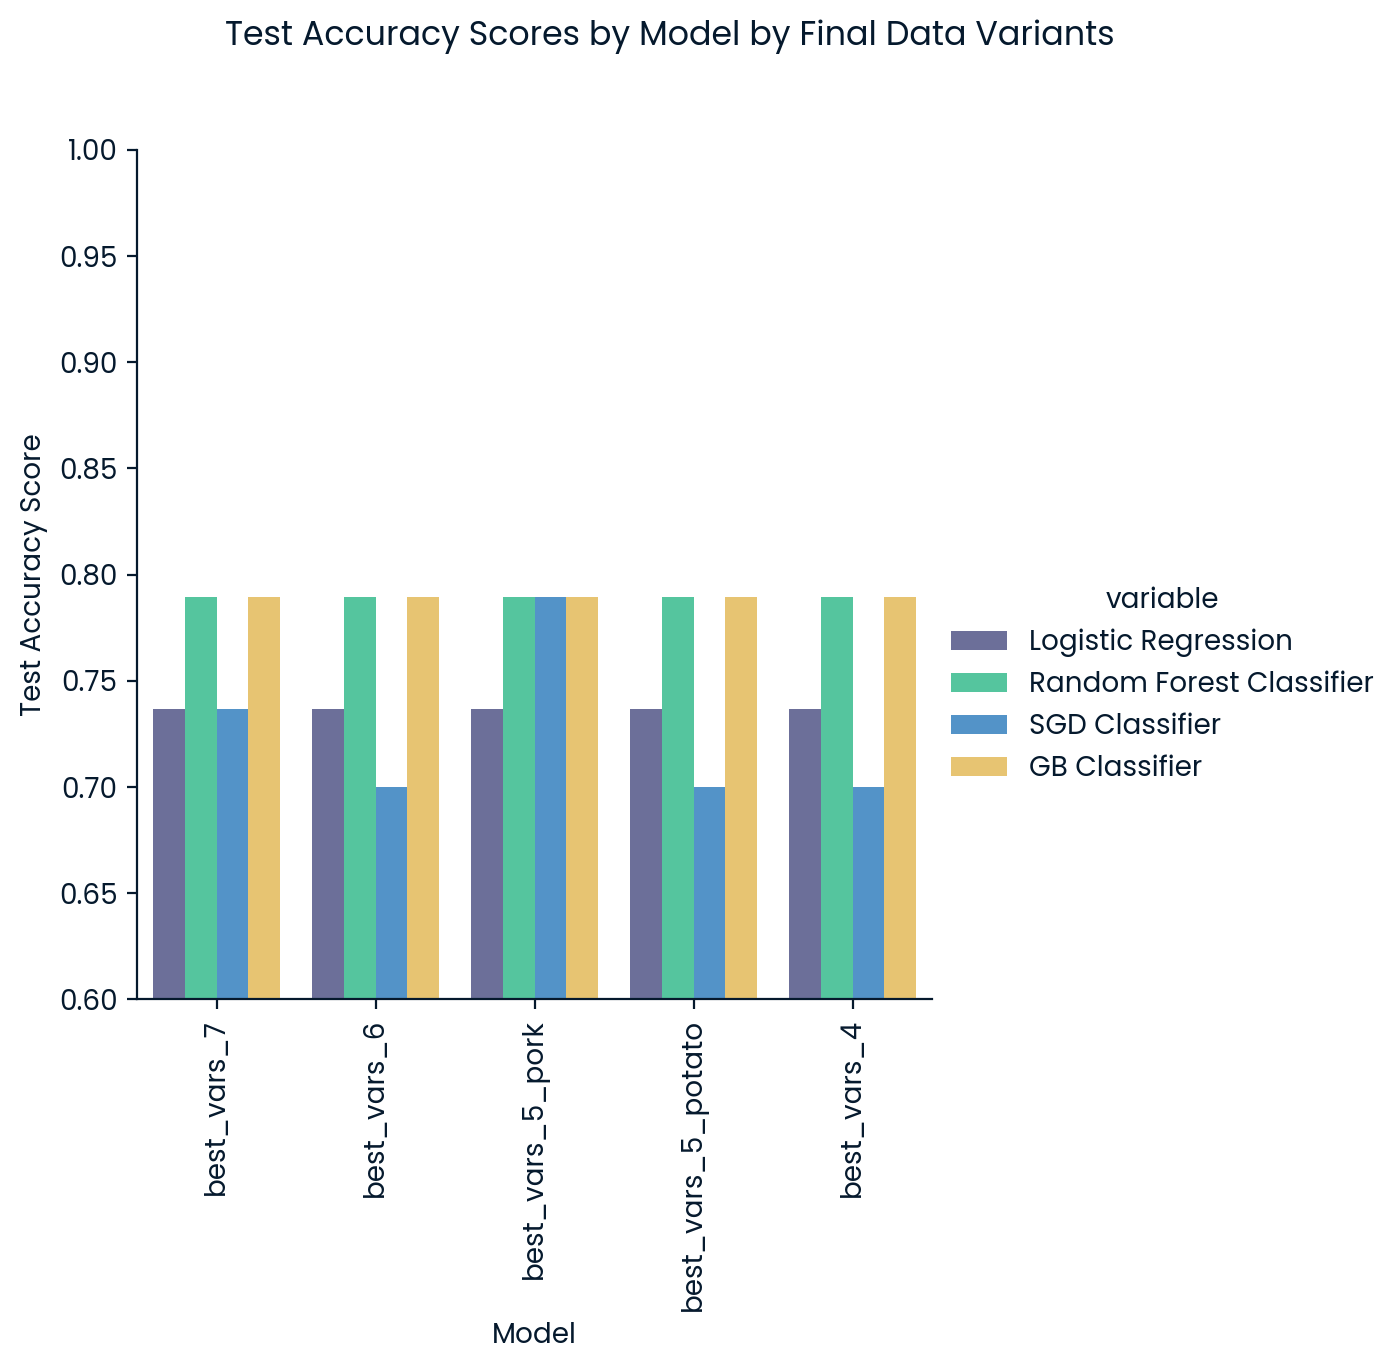

In [142]:
sns.catplot(data =pd.melt(best_vars_test_acc.reset_index(), id_vars = 'var_type_test'), x = 'var_type_test', y='value', hue = 'variable', kind ='bar').set(ylim = (0.6,1),xlabel = 'Model', ylabel = 'Test Accuracy Score', alpha = .2)
plt.xticks(rotation = 90)
plt.suptitle("Test Accuracy Scores by Model by Final Data Variants", y = 1.1)

In [143]:
def var_recomendations_df(cols, model):
    """plots graph of model features by model class"""
    
    #subsets celaned data
    X_train_subset = X_train_clean.loc[:,cols]
    X_test_subset = X_test_clean.loc[:,cols]
    
    #fit model
    model_sub = model[1].fit( X_train_subset, y_train)
    #get predicitons
    y_pred = model_sub.predict(X_test_subset)
    
    #merge predictions to test features
    results = X_test_subset.assign(y_pred = y_pred)
    #filter for positive class and sum along column to see most frequently used feature for positive class 
    results_pos = results[results.y_pred ==1].iloc[:,:-1].sum(axis = 0)
    results_pos.name = 'High'
    #filter for positive class and sum along column to see most frequently used feature for negative class 
    results_neg = results[results.y_pred ==0].iloc[:,:-1].sum(axis = 0)
    results_neg.name = 'Low'
    #merge classes and rename df
    fin_results = pd.merge(results_pos,results_neg, how = 'left', right_index = True, left_index = True).unstack().reset_index()
    fin_results.columns= ['Traffic Type', 'Feature', 'Var Count']
    print(str(model[0]) + " has test precision score of {prec_score:.2f}".format(prec_score=precision_score(y_test, y_pred)) )
    return fin_results
    


In [144]:
def var_recommendations_graph(cols, model):
    title = "Feature Use By Class for " + str(model[0])
    fin_results = var_recomendations_df(cols, model)
    sns.catplot(data = fin_results, kind = 'bar', hue = 'Traffic Type', x = 'Feature', y = 'Var Count')
    plt.xticks(rotation = 90)
    plt.suptitle(title, y = 1.1)
    

- The selected GB Classifier model would allow the team to predict traffic volume status with 80% accuracy using only 4 to 6 features: which are as follows: 
    - Chicken 
    - Beverages
    - Breakfast
    - Vegetables
    - Pork
    - Potato
- During exploratory data analysis the 3 most common recipes with the highest proportion of low traffic volume were Beverages, Breakfast and Chicken. 
- Thus recipes that are not one of the aforementioned 3 are more likely to be considered high traffic.
- Traits associated with high traffic include recipes belonging to the category: vegetable, followed by pork then potato. 
- When considering a calorie size of 400 to 800 the model's ability to discern between classes decreases. 



GB Classifier Model with Best Var Group has Precision score of 0.80


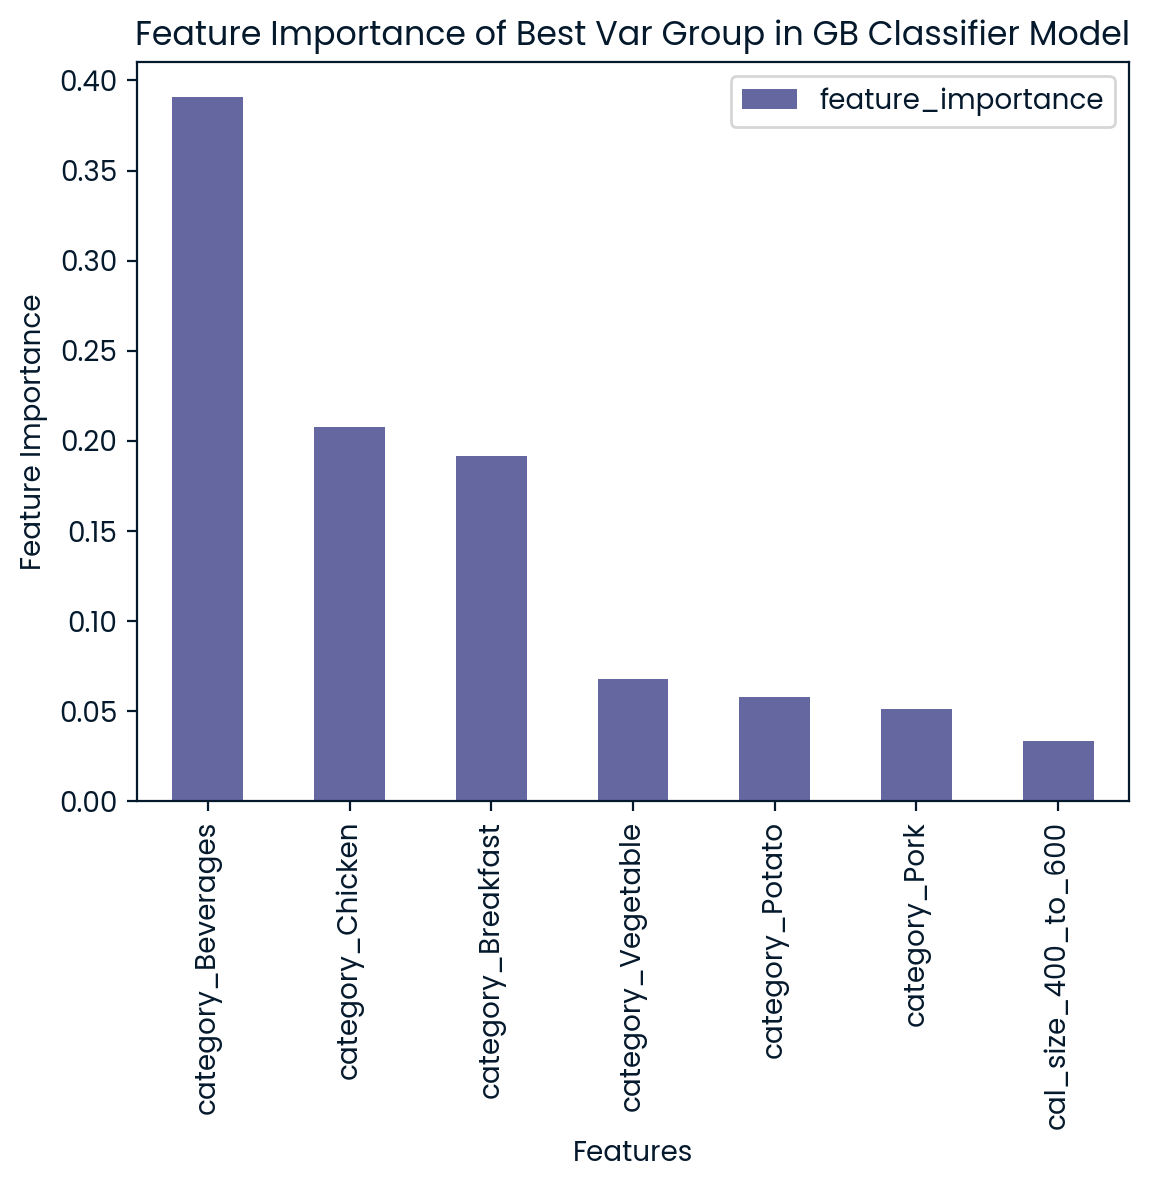

In [145]:
compare_models_graphs( classifiers[3], best_vars_7, "Best")

GB Classifier has test precision score of 0.81


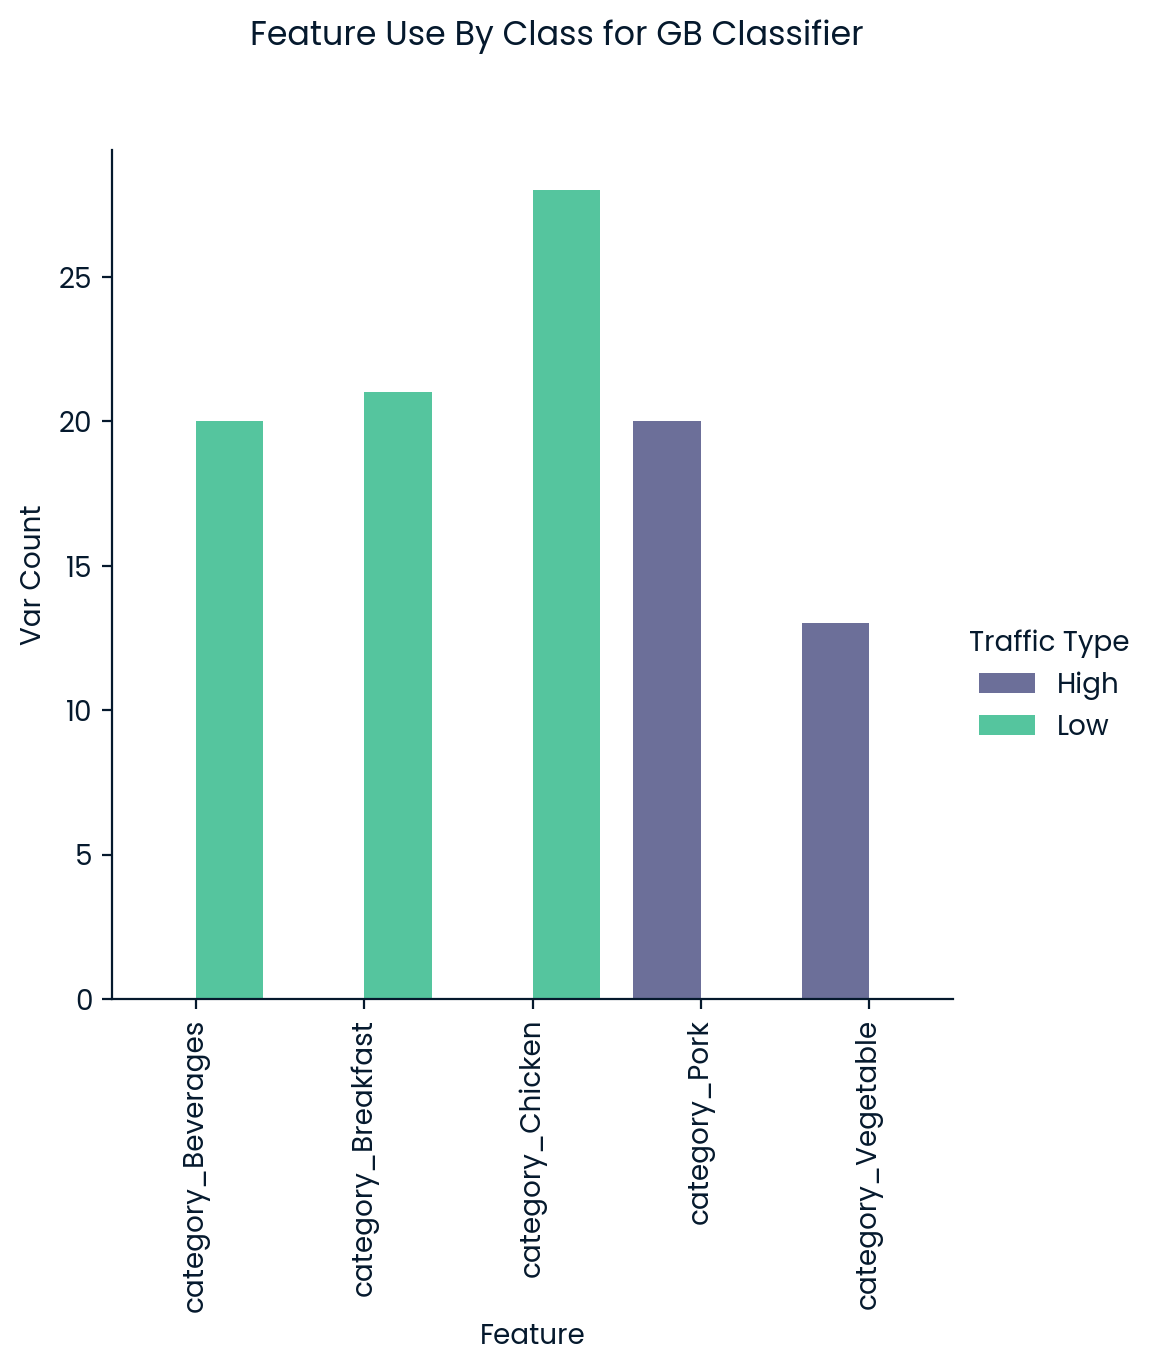

In [146]:
var_recommendations_graph(best_vars_5_pork, classifiers[3])

GB Classifier has test precision score of 0.81


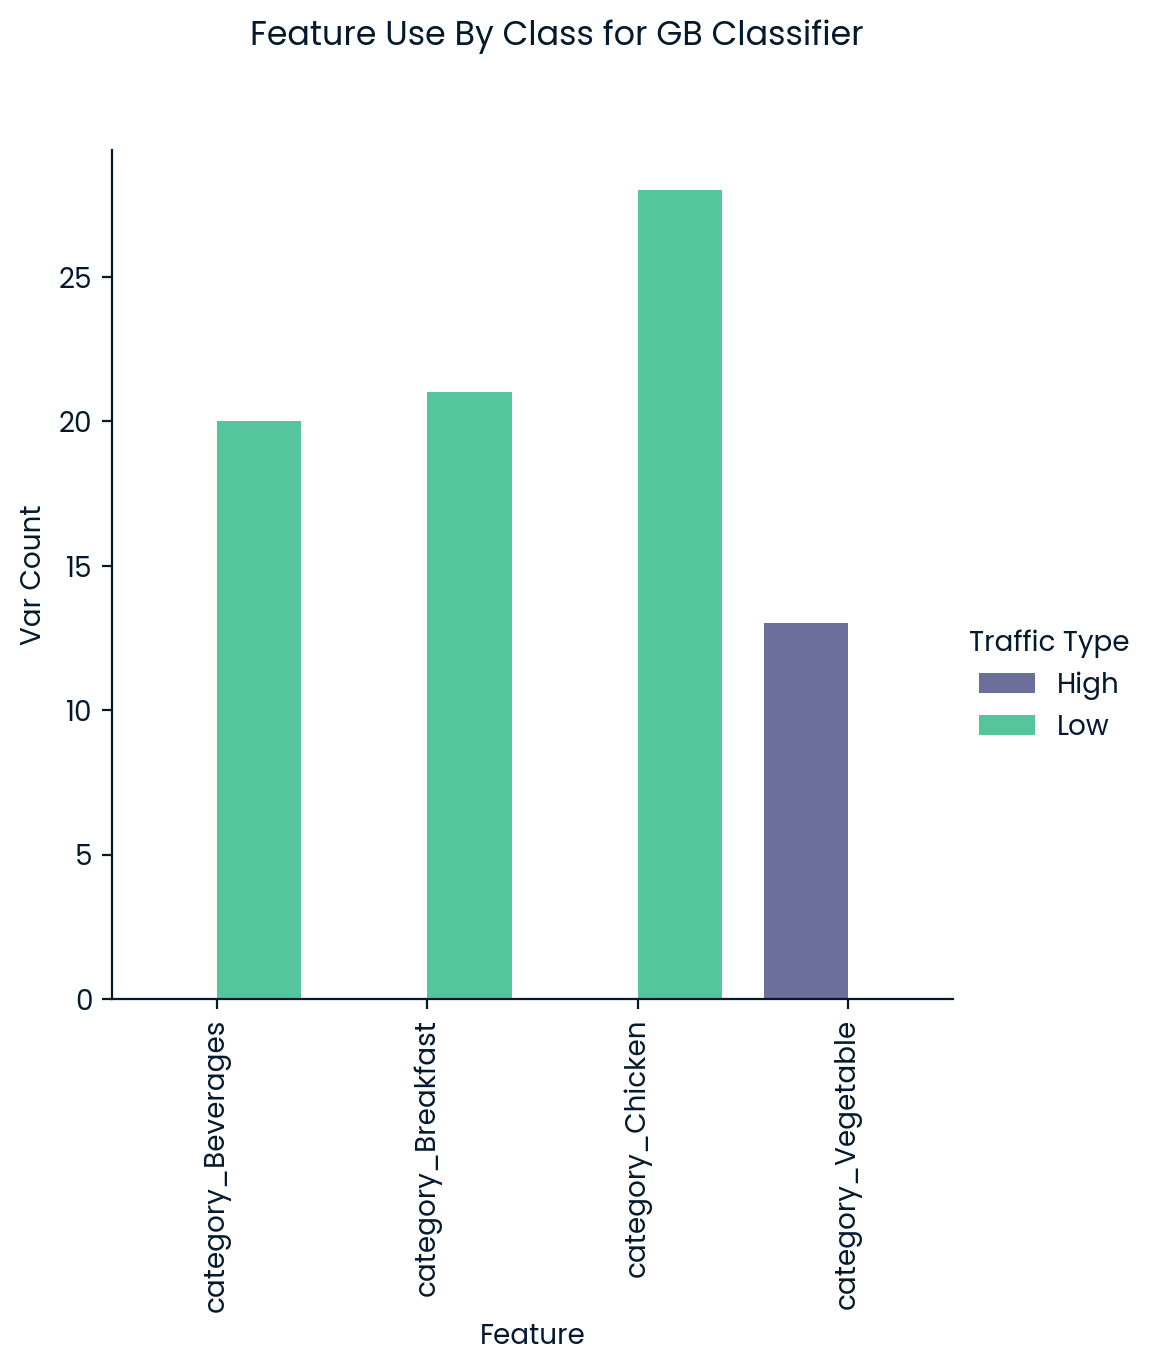

In [147]:
var_recommendations_graph(best_vars_4, classifiers[3])

GB Classifier has test precision score of 0.80


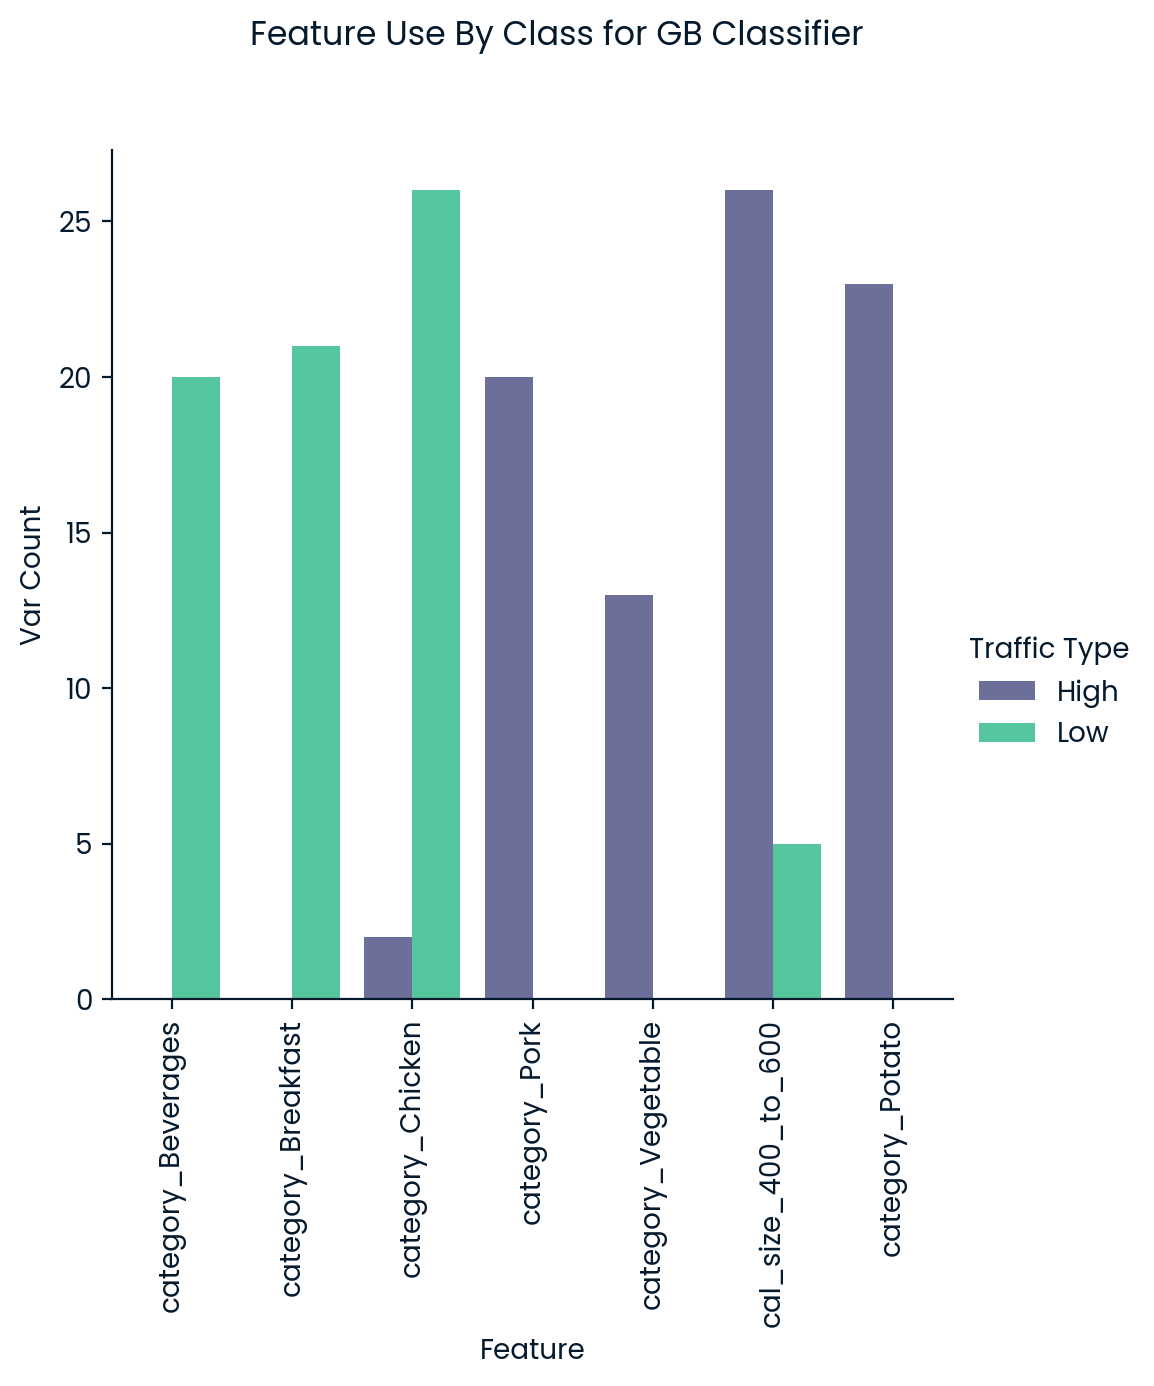

In [148]:
var_recommendations_graph(best_vars_7, classifiers[3])


### Recomendations


- The results of the model are congruent with our initial exploratory data analysis. 
- The propensity of the of the model to distinguish by features that are underperforming is probably the result of the slight class imbalance that favors the positive class (High: 60%)
- It is highly recommended that the model be fitted again but using a higher threshold for high traffic e.g. top 10% of recipes instead of top 60% if the team would like to understand what recipes drive traffic volume instead of the absence of traffic volume. 
- Alternatively the team could consider using site visitors and conduct a regression analysis instead.     
- To further improve model robustness,  including data points which allow us to distinguish which details are available on the homepage preview snippet vs actual recipe page might provide better insight
- Further analysis would be more beneficial since we have concerns about data validity. 
- As such we have not bothered to conduct hyper parameter tuning to further refine the model.  



## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation